# Group Assignment 4 - Group M - DSESM 2024

Members:
Mario, Marco, Nusrat, Yazan

## Libraries

In [9]:
from atlite.gis import ExclusionContainer
from atlite.gis import shape_availability
import atlite
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import country_converter as coco
import atlite
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Preparing Data for PyPSA

## Shapes & Regions

In [10]:
# Load the regions data
fn = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fgadm&files=gadm_410-levels-ADM_1-NLD.gpkg"
regions = gpd.read_file(fn)

In [11]:
# EEZ data, this will take a while
url_eez = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fmarineregions%2FWorld_EEZ_v11_20191118_gpkg&files=eez_v11.gpkg"
eez = gpd.read_file(url_eez)

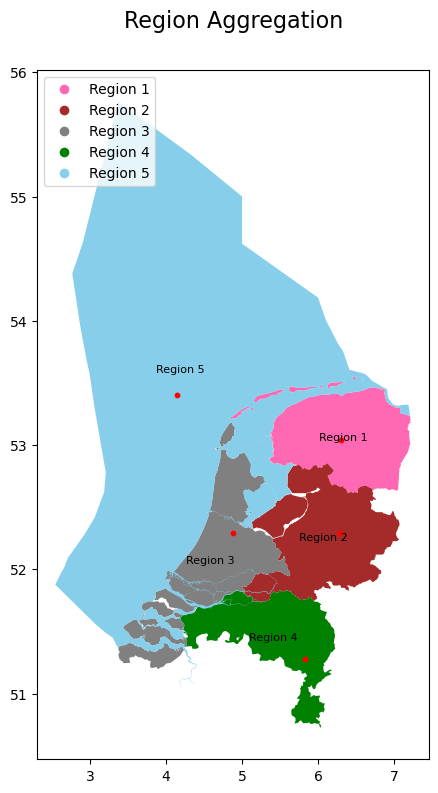

In [12]:
from matplotlib import colors
import matplotlib.colors as mcolors

# Define the region mapping
region_mapping = {
    'Groningen': 'Region 1', 'Fryslân': 'Region 1', 'Drenthe': 'Region 1', 'Overijssel': 'Region 2', 'Gelderland': 'Region 2', 
    'Flevoland': 'Region 2', 'Utrecht': 'Region 3', 'Noord-Holland': 'Region 3', 'NA': 'Region 3', 'Zeeland': 'Region 3',
    'Noord-Brabant': 'Region 4', 'Limburg': 'Region 4'
}
regions['Region'] = regions['NAME_1'].map(region_mapping)

# Dissolve regions by the new 'Region' column
combined_regions = regions.dissolve(by='Region')

# Reset index and select necessary columns
combined_regions.reset_index(inplace=True)
combined_regions = combined_regions[['Region', 'geometry']]

# Add the marine region (eez_nl)
eez_nl = eez[eez['TERRITORY1'] == 'Netherlands'].copy()
eez_nl.loc[216,"NAME_1"] = "North Sea"
eez_nl.loc[:, 'Region'] = 'Region 5'

# Combine land and marine regions
combined_regions = pd.concat([combined_regions, eez_nl[['Region', 'geometry']]], ignore_index=True)

# Define custom colors
custom_colors = ['hotpink', 'brown', 'grey', 'green', 'skyblue']
cmap = mcolors.ListedColormap(custom_colors)

# Plot the regions
fig, ax = plt.subplots(figsize=(10, 8))
combined_regions.plot(ax=ax, cmap=cmap, edgecolor='none')

# Add text labels to the regions
for idx, row in combined_regions.iterrows():
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, row['Region'], ha='center', va='center', fontsize=8)

# Plot representative points (for the original combined regions)
points = combined_regions.representative_point()
points.plot(ax=ax, color='red', markersize=10)

# Create a legend
labels = ['Region 1', 'Region 2', 'Region 3', 'Region 4', 'Region 5']
patches = [plt.Line2D([], [], marker='o', color='w', markerfacecolor=color, markersize=8) for color in custom_colors]
plt.legend(patches, labels, loc='upper left')

# Add title and display the plot
plt.title("Region Aggregation", fontsize=16, y=1.05)
plt.axis('on')
plt.tight_layout()
plt.show()


In [13]:
points

0    POINT (6.30770 53.03945)
1    POINT (6.29240 52.29567)
2    POINT (4.88280 52.28966)
3    POINT (5.83110 51.27609)
4    POINT (4.13744 53.40210)
dtype: geometry

In [14]:
regions = regions.to_crs(3035)
eez_nl = eez_nl.to_crs(3035)

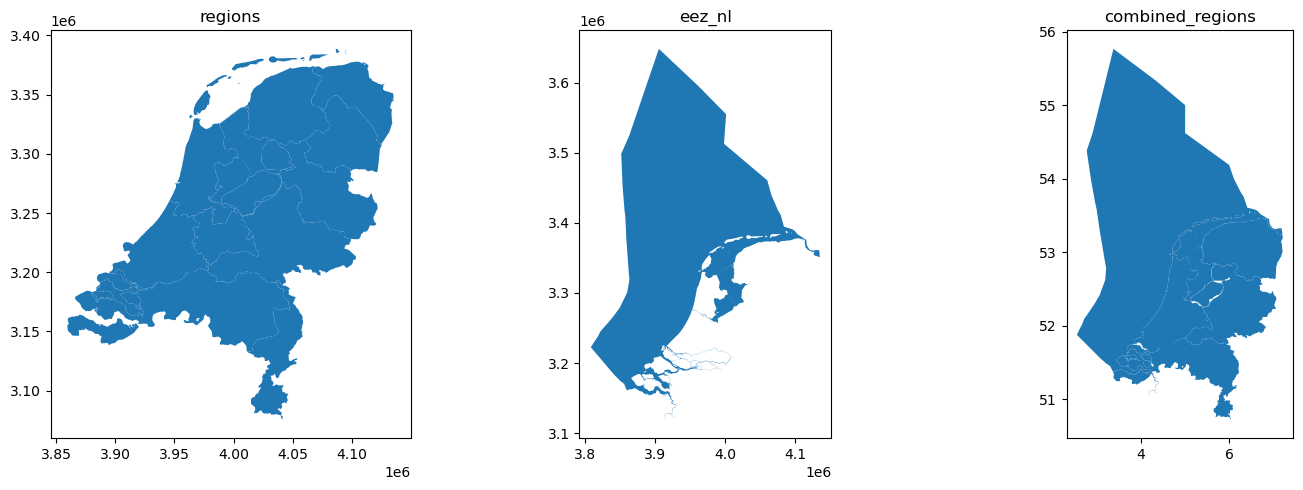

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 1 row and 3 columns

# Plotting the first subplot
axs[0].set_title('regions')
regions.plot(ax=axs[0])

# Plotting the second subplot
axs[1].set_title('eez_nl')
eez_nl.plot(ax=axs[1])

# Plotting the third subplot
axs[2].set_title('combined_regions')
combined_regions.plot(ax=axs[2])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## Inputs for PyPSA 

### **Spatial** resolution - **Done**

In [16]:
fn = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fgadm&files=gadm_410-levels-ADM_1-NLD.gpkg"
regions = gpd.read_file(fn)
regions["regions"]= [1,2,1,2,1,2,4,4,3,2,3,3,3,3] 
regions

GID_0     GID_1      COUNTRY         NAME_1  \
0    NLD   NLD.1_1  Netherlands        Drenthe   
1    NLD   NLD.2_1  Netherlands      Flevoland   
2    NLD   NLD.3_1  Netherlands        Fryslân   
3    NLD   NLD.4_1  Netherlands     Gelderland   
4    NLD   NLD.5_1  Netherlands      Groningen   
5    NLD   NLD.6_1  Netherlands     IJsselmeer   
6    NLD   NLD.7_1  Netherlands        Limburg   
7    NLD   NLD.8_1  Netherlands  Noord-Brabant   
8    NLD   NLD.9_1  Netherlands  Noord-Holland   
9    NLD  NLD.10_1  Netherlands     Overijssel   
10   NLD  NLD.11_1  Netherlands        Utrecht   
11   NLD  NLD.12_1  Netherlands        Zeeland   
12   NLD  NLD.13_1  Netherlands  Zeeuwse meren   
13   NLD  NLD.14_1  Netherlands             NA   

                                             geometry  regions  
0   MULTIPOLYGON (((6.52366 52.64551, 6.52366 52.6...        1  
1   MULTIPOLYGON (((5.30388 52.31247, 5.28622 52.3...        2  
2   MULTIPOLYGON (((6.23919 52.91320, 6.23615 52.9...        1  
3   MULTIPOLYGON (((5.13576 51.73854, 5.13544 51.7...        2  
4   MULTIPOLYGON (((6.91710 53.01160, 6.91460 53.0...        1  
5   MULTIPOLYGON (((5.26216 52.43537, 5.23710 52.4...        2  
6   MULTIPOLYGON (((6.01553 50.74829, 6.01326 50.7...        4  
7   MULTIPOLYGON (((5.50305 51.29579, 5.49979 51.2...        4  
8   MULTIPOLYGON (((4.83937 52.23358, 4.83403 52.2...        3  
9   MULTIPOLYGON (((6.87309 52.13272, 6.87284 52.1...        2  
10  MULTIPOLYGON (((5.15190 51.93248, 5.15337 51.9...        3  
11  MULTIPOLYGON (((3.67419 51.29042, 3.66687 51.2...        3  
12  MULTIPOLYGON (((3.86646 51.53969, 3.85926 51.5...        3  
13  MULTIPOLYGON (((4.36117 51.66149, 4.33181 51.6...        3

In [17]:
combined_regions[["geometry"]]

geometry
0  MULTIPOLYGON (((6.10234 52.84489, 6.10211 52.8...
1  MULTIPOLYGON (((5.13285 51.73853, 5.13139 51.7...
2  MULTIPOLYGON (((3.65546 51.29224, 3.64316 51.2...
3  POLYGON ((6.01326 50.75231, 6.01215 50.75426, ...
4  MULTIPOLYGON (((7.21028 53.24417, 7.20750 53.2...

### **Transmission Lines** crow-fly distances - **Done**

In [18]:
combined_regions = combined_regions.dissolve(by="Region")
points5 = combined_regions.representative_point()
points5 = points5.to_crs(3857)
distances = pd.concat({k: points5.distance(p) for k, p in points5.items()}, axis=1).div(1e3)

dict = {1: 'Region 1',
        2: 'Region 2',
        3: 'Region 3',
        4: 'Region 4',
        5: 'Region 5'}

distances.rename(columns=dict, inplace=True)
distances.rename(index=dict, inplace=True)
distances

Region 1    Region 2    Region 3    Region 4    Region 5
Region                                                              
Region 1    0.000000  136.544072  210.003021  324.389005  250.825506
Region 2  136.544072    0.000000  156.920050  190.537816  314.876284
Region 3  210.003021  156.920050    0.000000  210.740304  221.205661
Region 4  324.389005  190.537816  210.740304    0.000000  430.886255
Region 5  250.825506  314.876284  221.205661  430.886255    0.000000

### **Existing Power Plants** - one technology/region - **Done**

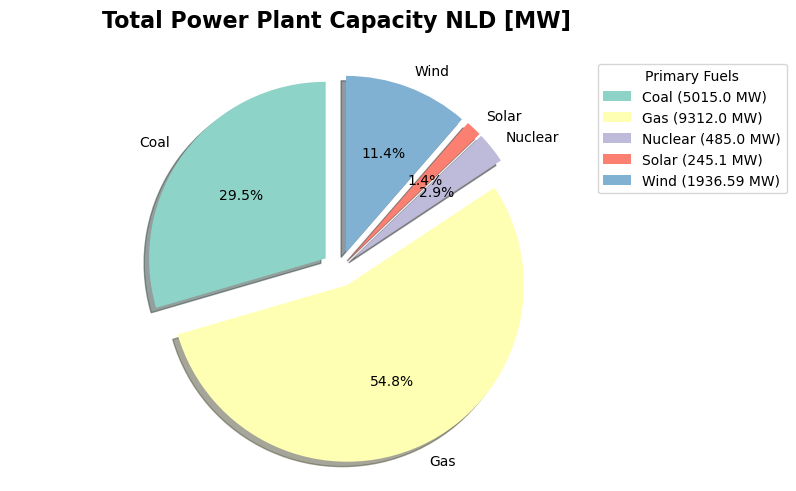

In [19]:
df = pd.read_csv("https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fglobal-power-plant-database&files=global_power_plant_database.csv", low_memory =False)

df_Netherlands = df[df['country'] == 'NLD']

# Aggregate capacity by primary fuel type
primary_fuel_agg = df_Netherlands.groupby('primary_fuel')['capacity_mw'].sum()

#Plotting the pie chart
plt.figure(figsize=(8, 5))
colors = plt.cm.Set3.colors
explode = [0.1] * len(primary_fuel_agg)  # Explode all slices equally

plt.pie(
    primary_fuel_agg,
    labels=primary_fuel_agg.index,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    explode=explode,  
    shadow=True,  
)

legend_labels = [f"{fuel} ({capacity} MW)" for fuel, capacity in zip(primary_fuel_agg.index, primary_fuel_agg)]
plt.legend(
    legend_labels,
    title='Primary Fuels',
    loc='upper right',
    bbox_to_anchor=(1.2, 1),
)

plt.title("Total Power Plant Capacity NLD [MW]", y=1.05, fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
#plt.savefig('primary_fuel_capacity_pie_chart.png', dpi=300)
plt.show()


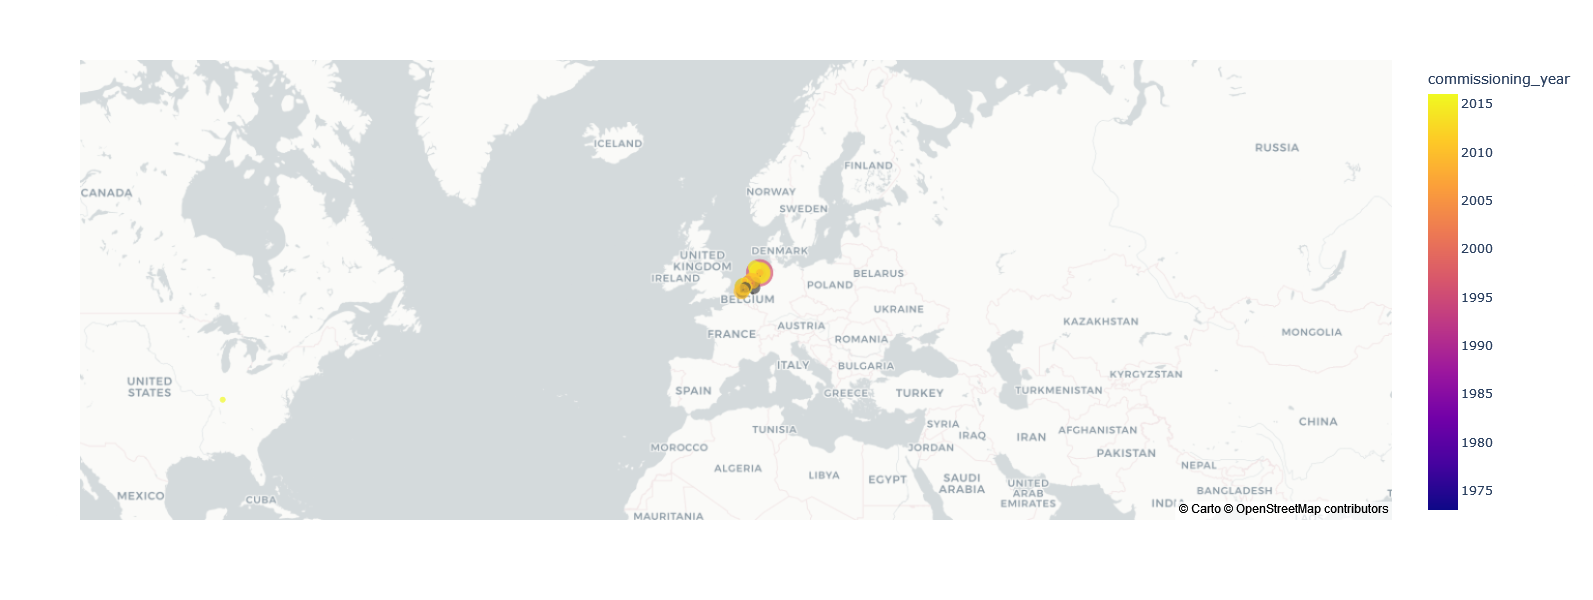

In [20]:
import plotly.express as px
px.scatter_mapbox(
    df_Netherlands,
    lat="latitude",
    lon="longitude",
    mapbox_style="carto-positron",
    color="commissioning_year",
    size="capacity_mw",
    zoom=2,
    height=600
)

In [21]:
df = pd.read_csv("global_power_plant_database.csv",low_memory=False)
df = df[df.country == 'NLD']
df = df.drop(df[(df.primary_fuel == "Solar")].index)
df = df.drop(df[(df.primary_fuel == "Wind")].index)
df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
df.reset_index(drop=True, inplace=True)
#df

In [22]:
df.set_crs(epsg=4326, inplace=True)
joined_data = gpd.sjoin(df, regions, how="left", predicate="within") #joining gdf powerplants and regions
#joined_data

In [23]:
df_pp_prepared = joined_data.groupby(["regions","primary_fuel"]).capacity_mw.sum().unstack().fillna(0)
df_pp_prepared #capacity conventional pp per region (per bus for PyPSA)
#there is no conventional pp in region 4 from the dataset given

primary_fuel    Coal     Gas  Nuclear
regions                              
1             1600.0  4306.0      0.0
2              590.0  2228.0      0.0
3             2825.0  2778.0    485.0

### **Load time series** - **Done**

In [24]:
population = {
    "Drenthe": 502051,"Flevoland": 444701, "Fryslân": 659551, "Gelderland": 2133708, "Groningen": 596075,
    "IJsselmeer":0, "Limburg": 1128367, "Noord-Brabant": 2626210,"Noord-Holland": 2952622, "Overijssel": 1184333, 
    "Utrecht": 1387643, "Zeeland": 391124, "Zeeuwse meren": 0, "NA": 3804906,} #source statista 2023

#NA -> South Holland

population = pd.DataFrame.from_dict(population, orient="index", columns=["regional_population"])
population["percentage"] = population["regional_population"] / population["regional_population"].sum() * 100
population["regions"] = [1,2,1,2,1,2,4,4,3,2,3,3,3,3]
population_aggregated = population.groupby("regions").agg({"percentage": "sum", "regional_population": "sum"})
population_aggregated.rename(index={1: "Region 1", 2: "Region 2", 3: "Region 3", 4: "Region 4", 5: "Region 5"}, inplace=True)
population_aggregated["percentage"] = population_aggregated["percentage"].round()
population_aggregated


percentage  regional_population
regions                                  
Region 1        10.0              1757677
Region 2        21.0              3762742
Region 3        48.0              8536295
Region 4        21.0              3754577

In [25]:
population_aggregated["regional_population"].sum()

17811291

In [26]:
#load /region / hour

fn="https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fgegis&files=load.csv"
ts = pd.read_csv(fn,index_col="time")
ts = ts["NL"]
ts = ts.to_frame()
ts.index = pd.to_datetime(ts.index)

for i in range(len(population_aggregated)):
      ts[population_aggregated.index[i]] = ts["NL"].values * population_aggregated.iloc[i,0]/100

ts = ts.drop(columns='NL')

#2013->2017
ts.index = ts.index.map(lambda x: x.replace(year=2017))

ts_load = ts
ts_load.head()

Region 1     Region 2     Region 3     Region 4
time                                                                   
2017-01-01 00:00:00  1240.058191  2604.122200  5952.279315  2604.122200
2017-01-01 01:00:00  1213.924039  2549.240482  5826.835387  2549.240482
2017-01-01 02:00:00  1210.941897  2542.977983  5812.521104  2542.977983
2017-01-01 03:00:00  1211.558978  2544.273854  5815.483095  2544.273854
2017-01-01 04:00:00  1265.347994  2657.230788  6073.670373  2657.230788

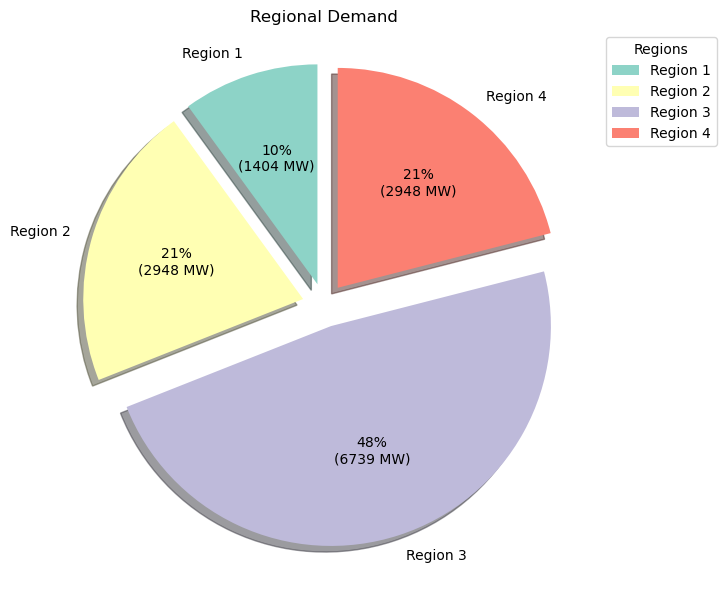

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

regional_load_mean = ts.mean()
regional_load_mean = pd.DataFrame(regional_load_mean, columns=['Average_Load'])
regional_load_mean['regions'] = ["Region 1", "Region 2", "Region 3", "Region 4"]

# Adjust explode to match the number of regions
explode = (0.1, 0.1, 0.1, 0.1)
colors = sns.color_palette("Set3")

plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(regional_load_mean['Average_Load'], labels=regional_load_mean['regions'], 
                                   autopct=lambda pct: f"{pct:.0f}%\n({round(pct/100*regional_load_mean['Average_Load'].sum())} MW)",
                                   explode=explode, colors=colors[:4], shadow=True, startangle=90)
plt.title('Regional Demand')
plt.legend(wedges, regional_load_mean['regions'], title="Regions", loc="best", bbox_to_anchor=(1, 1))
plt.tight_layout()
#plt.savefig('rdemand', dpi=300)
plt.show()


### **Temporal** resolution (resampling) - Done

In [28]:
resolution = 3
ts_load = ts_load.resample(f"{resolution}h").mean()
ts_load # timeseries resampled

Region 1     Region 2     Region 3     Region 4
time                                                                   
2017-01-01 00:00:00  1221.641375  2565.446888  5863.878602  2565.446888
2017-01-01 03:00:00  1308.258288  2747.342405  6279.639784  2747.342405
2017-01-01 06:00:00  1679.810468  3527.601982  8063.090245  3527.601982
2017-01-01 09:00:00  1740.948746  3655.992366  8356.553979  3655.992366
2017-01-01 12:00:00  1745.429526  3665.402005  8378.061725  3665.402005
...                          ...          ...          ...          ...
2017-12-31 09:00:00  1678.795823  3525.471228  8058.219951  3525.471228
2017-12-31 12:00:00  1658.584650  3483.027765  7961.206319  3483.027765
2017-12-31 15:00:00  1669.386195  3505.711010  8013.053736  3505.711010
2017-12-31 18:00:00  1612.097736  3385.405246  7738.069134  3385.405246
2017-12-31 21:00:00  1355.529347  2846.611628  6506.540865  2846.611628

[2920 rows x 4 columns]

### **Technology assumptions** (costs etc.) - Done

In [29]:
year = 2045
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0,1])
#costs 

In [30]:
technologies = costs.index.get_level_values('technology').unique()
for tech in technologies:
    print(tech)

Ammonia cracker
BEV Bus city
BEV Coach
BEV Truck Semi-Trailer max 50 tons
BEV Truck Solo max 26 tons
BEV Truck Trailer max 56 tons
Battery electric (passenger cars)
Battery electric (trucks)
BioSNG
BtL
CCGT
CH4 (g) fill compressor station
CH4 (g) pipeline
CH4 (g) submarine pipeline
CH4 (l) transport ship
CH4 evaporation
CH4 liquefaction
CO2 liquefaction
CO2 pipeline
CO2 storage tank
CO2 submarine pipeline
Charging infrastructure fast (purely) battery electric vehicles passenger cars
Charging infrastructure fuel cell vehicles passenger cars
Charging infrastructure fuel cell vehicles trucks
Charging infrastructure slow (purely) battery electric vehicles passenger cars
Compressed-Air-Adiabatic-bicharger
Compressed-Air-Adiabatic-store
Concrete-charger
Concrete-discharger
Concrete-store
Container feeder, ammonia
Container feeder, diesel
Container feeder, methanol
Container, ammonia
Container, diesel
Container, methanol
Diesel Bus city
Diesel Coach
Diesel Truck Semi-Trailer max 50 tons
Diese

In [31]:
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

#gas prices for OCGT & CCGT needs to be added manually
costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["CCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]
costs.at["CCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

#not for nuclear

#not for coal

In [32]:
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [33]:
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

In [34]:
costs.at["CCGT", "efficiency"] #check values

0.595

## Renewables Potential & Availability Matrix per Renewable Tech per Region

### maximum installabale potential per renewable tech per region **(p_nom_max)**

In [35]:
def plot_area(masked, transform, shape, title=None):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax = show(masked, transform=transform, cmap="Greens", vmin=0, ax=ax)
    shape.plot(ax=ax, edgecolor="k", color="None", linewidth=1)
    if title:
        ax.set_title(title)
    plt.show()

"For both wind and solar, assume a deployment density of **3 MW/km2**"

#### Onshore wind

In [36]:
#onshore wind criterias
excluder_onwind = ExclusionContainer(crs=3035, res=300)

#airports
excluder_onwind.add_geometry('ne_10m_airports.gpkg', buffer=10000)

#roads
excluder_onwind.add_geometry('ne_10m_roads.gpkg', buffer=300)

#protected areas
fn = "WDPA_Oct2022_Public_shp-NLD.tif"
excluder_onwind.add_raster(fn, crs=3035)

#elevation
fn = "GEBCO_2014_2D-NL(1).nc"
excluder_onwind.add_raster(fn, codes=lambda x: x > 2000, crs=4326)

#land classes
fn = "PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326-NL.tif"
excluder_onwind.add_raster(fn, codes=[50], buffer=1000, crs=4326)
excluder_onwind.add_raster(fn, codes=[20, 30, 40, 60], crs=4326, invert=True)

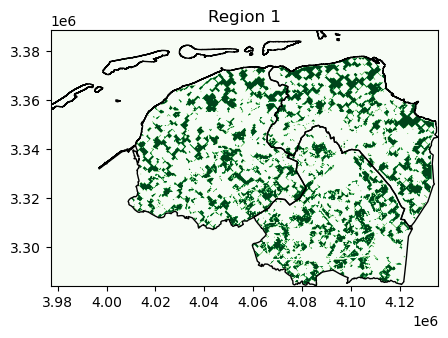

Eligible area for onwind in Region 1 = 2349630000 m²


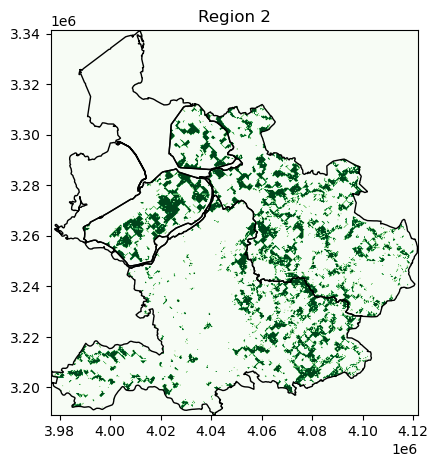

Eligible area for onwind in Region 2 = 1986750000 m²


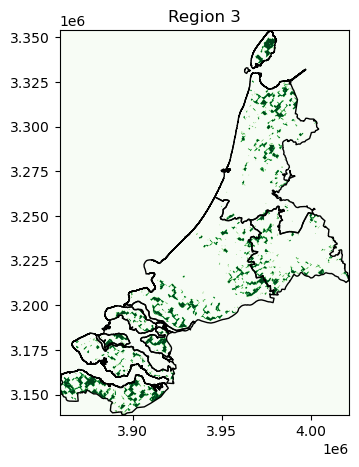

Eligible area for onwind in Region 3 = 1143810000 m²


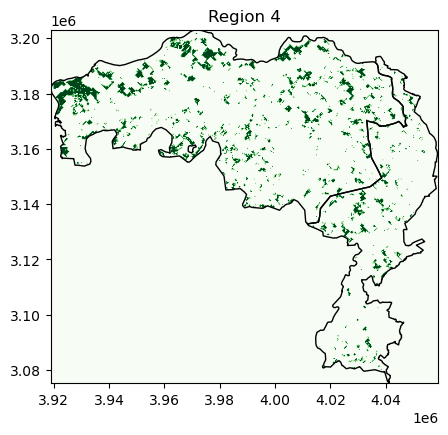

Eligible area for onwind in Region 4 = 675720000 m²
{'Region 1': 2349630000, 'Region 2': 1986750000, 'Region 3': 1143810000, 'Region 4': 675720000}

p_nom_max_onwind [MW]:
{'Region 1': 7048.89, 'Region 2': 5960.25, 'Region 3': 3431.4300000000003, 'Region 4': 2027.16}


In [37]:
eligible_areas_onwind ={}

for i in range (1,5): #basically done -> if there's time, make a dict of {region# : m2 eligible land}
    
    # plotting
    masked, transform = shape_availability(regions[regions["regions"] == i].to_crs(3035).geometry, excluder_onwind)
    plot_area(masked, transform, regions[regions["regions"] == i].to_crs(3035).geometry, title=f"Region {i}")
    
    # area calculation
    eligible_cells = masked.sum()
    cell_area = excluder_onwind.res**2
    eligible_area = np.multiply(cell_area, eligible_cells, dtype=object)

    # Store eligible area in the dictionary
    eligible_areas_onwind[f'Region {i}'] = eligible_area
    
    print(f"Eligible area for onwind in Region {i} = {eligible_area} m²")

print(eligible_areas_onwind)

# 3MW/km2
p_nom_max_onwind = {region: area * (3 / 1000000) for region, area in eligible_areas_onwind.items()} 

print ()
print ("p_nom_max_onwind [MW]:")
print (p_nom_max_onwind)

#### Solar PV

In [38]:
#solar criterias
excluder_solar = ExclusionContainer(crs=3035, res=300)

#protected areas
fn = "WDPA_Oct2022_Public_shp-NLD.tif"
excluder_solar.add_raster(fn, crs=3035)

#land classes
fn = "PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326-NL.tif"
excluder_solar.add_raster(fn, codes=[20, 30, 40, 50, 60], crs=4326, invert=True)

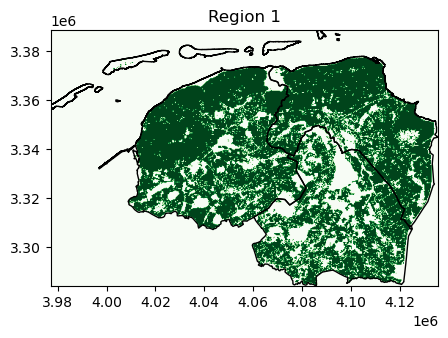

Eligible area for solar_pv in Region 1 = 6049170000 m²


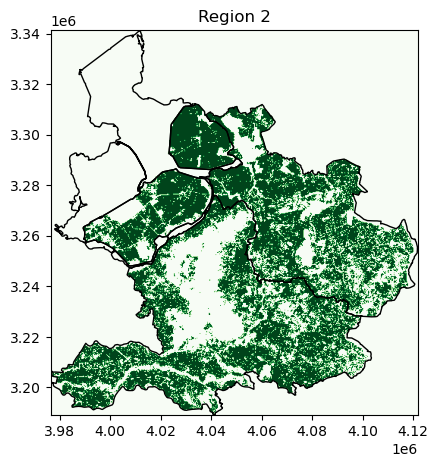

Eligible area for solar_pv in Region 2 = 5905170000 m²


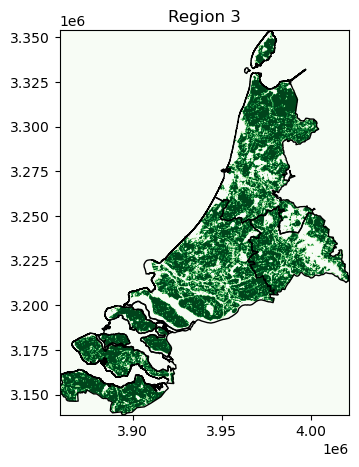

Eligible area for solar_pv in Region 3 = 6295320000 m²


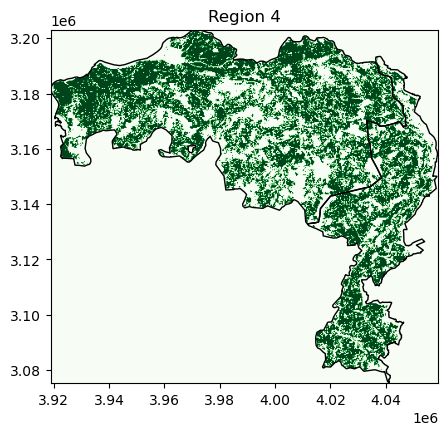

Eligible area for solar_pv in Region 4 = 4082400000 m²
{'Region 1': 6049170000, 'Region 2': 5905170000, 'Region 3': 6295320000, 'Region 4': 4082400000}

p_nom_max_solar [MW]:
{'Region 1': 18147.510000000002, 'Region 2': 17715.510000000002, 'Region 3': 18885.96, 'Region 4': 12247.2}


In [39]:
eligible_areas_solar ={}

for i in range (1,5):
    
    # plotting
    masked, transform = shape_availability(regions[regions["regions"] == i].to_crs(3035).geometry, excluder_solar)
    plot_area(masked, transform, regions[regions["regions"] == i].to_crs(3035).geometry, title=f"Region {i}")
    
    # area calculation
    eligible_cells = masked.sum()
    cell_area = excluder_onwind.res**2
    eligible_area = np.multiply(cell_area, eligible_cells, dtype=object)
    
    # Store eligible area in the dictionary
    eligible_areas_solar[f'Region {i}'] = eligible_area
    
    print(f"Eligible area for solar_pv in Region {i} = {eligible_area} m²")

print(eligible_areas_solar)

# 3MW/km2
p_nom_max_solar = {region: area * (3 / 1000000) for region, area in eligible_areas_solar.items()} 

print ()
print ("p_nom_max_solar [MW]:")
print (p_nom_max_solar)

#### Offshore Wind

In [40]:
url = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fmarineregions%2FWorld_EEZ_v11_20191118_gpkg&files=eez_boundaries_v11.gpkg&downloadStartSecret=pp62f5nih1o"
eez_boundaries = gpd.read_file(url)
shoreline_nl = eez_boundaries.loc[2159]

shoreline_nl_gdf = gpd.GeoDataFrame({'geometry': [shoreline_nl.geometry]}, crs="EPSG:4326")

shoreline_nl_gdf = shoreline_nl_gdf.to_crs(3035)

In [41]:
#offshore wind criterias
excluder_offwind = ExclusionContainer(crs=3035, res=300)

#protected areas
fn = "WDPA_Oct2022_Public_shp-NLD.tif"
excluder_offwind.add_raster(fn, crs=3035)

#elevation
fn = "GEBCO_2014_2D-NL(1).nc"
excluder_offwind.add_raster(fn, codes=lambda x: (x<50) & (x>-50), crs=4326, invert=True)

#10km distance to shore
excluder_offwind.add_geometry(shoreline_nl_gdf, buffer=10000)

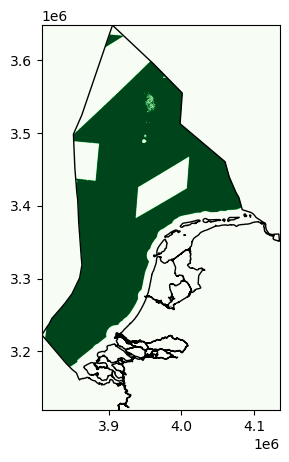

eligible area for offshore wind = 45106020000 m_squared


135318.06

In [42]:
masked, transform = shape_availability(eez_nl.to_crs(3035).geometry, excluder_offwind)
plot_area(masked, transform, eez_nl.to_crs(3035).geometry)
eligible_cells = masked.sum()
cell_area = excluder_onwind.res**2
eligible_area = np.multiply(cell_area, eligible_cells, dtype=object)
print ("eligible area for offshore wind =", eligible_area, "m_squared")

#3MW/km2
p_nom_max_offwind = eligible_area * (3 / 1000000)

#[MW]
p_nom_max_offwind

### capacity factor time series per technology per region **(p_max_pu)**

In [43]:
cutout = atlite.Cutout("era5-2017-NL.nc")
cutout

<Cutout "era5-2017-NL">
 x = 3.25 ⟷ 7.25, dx = 0.25
 y = 50.50 ⟷ 53.75, dy = 0.25
 time = 2017-01-01 ⟷ 2017-12-31, dt = h
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

In [44]:
combined_regions

geometry
Region                                                     
Region 1  MULTIPOLYGON (((5.27139 53.25236, 5.27139 53.2...
Region 2  MULTIPOLYGON (((5.12990 51.74391, 5.13257 51.7...
Region 3  MULTIPOLYGON (((3.62041 51.29810, 3.62015 51.2...
Region 4  POLYGON ((6.01326 50.75231, 6.01215 50.75426, ...
Region 5  POLYGON ((7.21028 53.24417, 7.20750 53.24234, ...

#### onshore wind

In [45]:
indices_to_drop = ["Region 5"] # region 5 is offshore
#i dropped region 3 and 4, for now, just to make the code run faster
regions_onshore_wind = combined_regions.drop(indices_to_drop)

In [46]:
#Availability- & capacity matrix (atlite function)
A_onwind = cutout.availabilitymatrix(regions_onshore_wind, excluder_onwind)

cap_per_sqkm = 3  # MW/km2
area = cutout.grid.set_index(["y", "x"]).to_crs(3035).area / 1e6
area = xr.DataArray(area, dims=("spatial"))

capacity_matrix = A_onwind.stack(spatial=["y", "x"]) * area * cap_per_sqkm

#capacity factor time series per region
onwind = cutout.wind(
    atlite.windturbines.Vestas_V112_3MW,
    matrix=capacity_matrix,
    index=regions_onshore_wind.index,
    per_unit=True,
)

#resampling 3hours and averaging
onwind = onwind.to_pandas()
onwind = onwind.resample('3h').mean()
ts_onwind = onwind

Compute availability matrix: 100%|███████████████████████████████████████████████| 4/4 [02:22<00:00, 35.69s/ gridcells]
C:\Users\hiero\miniconda3\envs\esm-2024\Lib\site-packages\atlite\resource.py:72: FutureWarning:

'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.13.



[########################################] | 100% Completed | 29.23 s


In [47]:
ts_onwind.mean()

Region
Region 1    0.375457
Region 2    0.297305
Region 3    0.356730
Region 4    0.267765
dtype: float64

#### solar

In [48]:
indices_to_drop = ["Region 5"] # region 5 is offshore
#i dropped region 3 and 4, for now, just to make the code run faster
regions_onshore_solar = combined_regions.drop(indices_to_drop)

In [49]:
#Availability- & capacity matrix (atlite function)
A_solar = cutout.availabilitymatrix(regions_onshore_solar, excluder_solar)

cap_per_sqkm = 3  # MW/km2
area = cutout.grid.set_index(["y", "x"]).to_crs(3035).area / 1e6
area = xr.DataArray(area, dims=("spatial"))

capacity_matrix = A_solar.stack(spatial=["y", "x"]) * area * cap_per_sqkm

#capacity factor time series per region
pv = cutout.pv(
    atlite.solarpanels.CdTe,
    matrix=capacity_matrix,
    orientation="latitude_optimal",
    index=regions_onshore_solar.index,
    per_unit=True,
)

#resampling 3hours and averaging
pv = pv.to_pandas()
pv = pv.resample('3h').mean()
ts_pv = pv

Compute availability matrix: 100%|███████████████████████████████████████████████| 4/4 [00:03<00:00,  1.30 gridcells/s]


[########################################] | 100% Completed | 105.70 s


In [50]:
pv.mean()

Region
Region 1    0.130208
Region 2    0.127631
Region 3    0.136954
Region 4    0.130872
dtype: float64

#### Offshore Wind, **from ERA5**

In [51]:
cutout = atlite.Cutout("era5-2017-NL-offshore.nc") #download the data from cloud
cutout #i decided to use ERA5 data, not renewable.ninjas, because...

<Cutout "era5-2017-NL-offshore">
 x = 2.50 ⟷ 7.25, dx = 0.25
 y = 51.00 ⟷ 56.00, dy = 0.25
 time = 2017-01-01 ⟷ 2017-12-31, dt = h
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

In [52]:
regions_offshore_wind = combined_regions.iloc[4]
regions_offshore_wind = gpd.GeoDataFrame(regions_offshore_wind, geometry="Region 5")

In [53]:
cutout = atlite.Cutout("era5-2017-NL-offshore.nc")

#regions_offshore_wind = combined_regions.iloc[4]

#Availability- & capacity matrix (atlite function)
A_offwind = cutout.availabilitymatrix(regions_offshore_wind, excluder_offwind)

cap_per_sqkm = 3  # MW/km2
area = cutout.grid.set_index(["y", "x"]).to_crs(3035).area / 1e6
area = xr.DataArray(area, dims=("spatial"))

capacity_matrix = A_offwind.stack(spatial=["y", "x"]) * area * cap_per_sqkm

#capacity factor time series per region
offwind = cutout.wind(
    atlite.windturbines.NREL_ReferenceTurbine_5MW_offshore,
    matrix=capacity_matrix,
    index=regions_offshore_wind.index,
    per_unit=True,
)

#resampling 3hours and averaging
offwind = offwind.to_pandas()
offwind = offwind.resample('3h').mean()
offwind.rename(columns={"geometry":"cf"}, inplace=True)
offwind.head()

Compute availability matrix: 100%|███████████████████████████████████████████████| 1/1 [00:01<00:00,  1.89s/ gridcells]
C:\Users\hiero\miniconda3\envs\esm-2024\Lib\site-packages\atlite\resource.py:72: FutureWarning:

'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.13.



[########################################] | 100% Completed | 4.78 s


dim_0                      cf
time                         
2017-01-01 00:00:00  0.985014
2017-01-01 03:00:00  0.955993
2017-01-01 06:00:00  0.904404
2017-01-01 09:00:00  0.716472
2017-01-01 12:00:00  0.581204

In [54]:
offwind.mean()

dim_0
cf    0.551368
dtype: float64

# PyPSA - Model Building

### Time Series

In [47]:
ts_load.head() #unit should be in MW

Region 1     Region 2     Region 3     Region 4
time                                                                   
2017-01-01 00:00:00  1221.641375  2565.446888  5863.878602  2565.446888
2017-01-01 03:00:00  1308.258288  2747.342405  6279.639784  2747.342405
2017-01-01 06:00:00  1679.810468  3527.601982  8063.090245  3527.601982
2017-01-01 09:00:00  1740.948746  3655.992366  8356.553979  3655.992366
2017-01-01 12:00:00  1745.429526  3665.402005  8378.061725  3665.402005

In [48]:
ts_onwind = onwind
ts_onwind.head()

Region               Region 1  Region 2  Region 3  Region 4
time                                                       
2017-01-01 00:00:00  0.844861  0.595096  0.640060  0.333262
2017-01-01 03:00:00  0.834669  0.605223  0.654885  0.329491
2017-01-01 06:00:00  0.862035  0.609657  0.620084  0.289855
2017-01-01 09:00:00  0.588202  0.305539  0.437291  0.234530
2017-01-01 12:00:00  0.484451  0.266586  0.443103  0.269457

In [49]:
ts_pv = pv
ts_pv.head()

Region               Region 1  Region 2  Region 3  Region 4
time                                                       
2017-01-01 00:00:00  0.000000  0.000000  0.000000  0.000000
2017-01-01 03:00:00  0.000000  0.000000  0.000000  0.000000
2017-01-01 06:00:00  0.000000  0.000000  0.000000  0.000000
2017-01-01 09:00:00  0.030120  0.043884  0.054316  0.104023
2017-01-01 12:00:00  0.040878  0.082200  0.087663  0.191991

In [50]:
ts_offwind = offwind
ts_offwind.head()

dim_0                      cf
time                         
2017-01-01 00:00:00  0.985014
2017-01-01 03:00:00  0.955993
2017-01-01 06:00:00  0.904404
2017-01-01 09:00:00  0.716472
2017-01-01 12:00:00  0.581204

### Points

In [51]:
points

0    POINT (6.30770 53.03945)
1    POINT (6.29240 52.29567)
2    POINT (4.88280 52.28966)
3    POINT (5.83110 51.27609)
4    POINT (4.13744 53.40210)
dtype: geometry

### existing power plants

In [52]:
df_pp_prepared

primary_fuel    Coal     Gas  Nuclear
regions                              
1             1600.0  4306.0      0.0
2              590.0  2228.0      0.0
3             2825.0  2778.0    485.0

## Model Building

In [53]:
import pypsa
import gurobipy as gp

In [155]:
n = pypsa.Network()

In [156]:
n.set_snapshots(ts_load.index)
n.snapshot_weightings.loc[:,:] = resolution
n.snapshot_weightings.head(3)

objective  stores  generators
snapshot                                          
2017-01-01 00:00:00        3.0     3.0         3.0
2017-01-01 03:00:00        3.0     3.0         3.0
2017-01-01 06:00:00        3.0     3.0         3.0

In [157]:
#add busses
n.add("Bus", "Region 1", y=6.3 , x=53.04)
n.add("Bus", "Region 2", y=6.29, x=52.29)
n.add("Bus", "Region 3", y=4.88, x=52.28)
n.add("Bus", "Region 4", y=5.83, x=51.27)
n.add("Bus", "Region 5", y=4.13, x=53.40)

In [158]:
#add generators
carriers = [
    "onwind",
    "offwind",
    "solar",
    "OCGT",
    "coal",
    "nuclear",
    "hydrogen storage underground",
    "battery storage",
]

n.madd(
    "Carrier",
    carriers,
    color = ["dodgerblue", "aquamarine", "gold", "indianred", "magenta", "yellowgreen", "darkslategray", "orchid"],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)

n.add(
    "Carrier",
    "HVAC",
    color = "brown",
    co2_emissions = 0
)

In [159]:
#add onwind

for r in range(1,5):
    n.add(
        "Generator",
        f"onwind region {r}",
        bus=f"Region {r}",
        carrier="onwind",
        p_max_pu=ts_onwind[f"Region {r}"],
        capital_cost=costs.at["onwind", "capital_cost"],
        marginal_cost=costs.at["onwind", "marginal_cost"],
        efficiency=costs.at["onwind", "efficiency"],
        p_nom_extendable=True,
        p_nom_max=p_nom_max_onwind[f"Region {r}"],
    )

In [160]:
#add solar pv

for r in range(1,5):
    n.add(
        "Generator",
        f"solar_pv region {r}",
        bus=f"Region {r}",
        carrier="solar",
        p_max_pu=ts_pv[f"Region {r}"],
        capital_cost=costs.at["solar", "capital_cost"],
        marginal_cost=costs.at["solar", "marginal_cost"],
        efficiency=costs.at["solar", "efficiency"],
        p_nom_extendable=True,
        p_nom_max=p_nom_max_solar[f"Region {r}"],
    )

In [161]:
#add offwind

n.add(
    "Generator",
    "Offshore region 5",
    bus="Region 5",
    carrier="offwind",
    p_max_pu=ts_offwind["cf"],
    capital_cost=costs.at["offwind", "capital_cost"],
    marginal_cost=costs.at["offwind", "marginal_cost"],
    efficiency=costs.at["offwind", "efficiency"],
    p_nom_extendable=True,
    p_nom_max=p_nom_max_offwind
)

In [162]:
#add coal

for r in range(1,4):
    n.add(
        "Generator",
        f"coal region {r}",
        bus=f"Region {r}",
        carrier="coal",
        p_nom=df_pp_prepared.loc[r,"Coal"],
        capital_cost=0,#costs.at["coal", "capital_cost"],
        marginal_cost=costs.at["coal", "marginal_cost"],
        efficiency=costs.at["coal", "efficiency"],
        p_nom_extendable=False, #?
        
    )

In [163]:
#add gas/OCGT

for r in range(1,4):
    n.add(
        "Generator",
        f"gas region {r}",
        bus=f"Region {r}",
        carrier="OCGT",
        p_nom=df_pp_prepared.loc[r,"Gas"],
        capital_cost=0,#costs.at["OCGT", "capital_cost"],
        marginal_cost=costs.at["OCGT", "marginal_cost"],
        efficiency=costs.at["OCGT", "efficiency"],
        p_nom_extendable=False, #?
        #p_nom_min=0,
    )

In [164]:
#add nuclear

n.add(
    "Generator",
    "Nuclear region 3",
    bus="Region 3",
    carrier="nuclear",
    p_nom=df_pp_prepared.loc[3,"Nuclear"],
    capital_cost=0,#costs.at["nuclear", "capital_cost"],
    marginal_cost=costs.at["nuclear", "marginal_cost"],
    efficiency=costs.at["nuclear", "efficiency"],
    p_nom_extendable=False,
)

In [165]:
#add loads

for r in range(1,5):
    n.add(
        "Load",
        f"load region {r}",
        bus=f"Region {r}",
        p_set=ts_load[f"Region {r}"],
        #carrier="electricity",
    )

#add transmission LINE

transmission = pd.DataFrame({
    'Start': ['Region 5', 'Region 5', 'Region 3', 'Region 2', 'Region 2', 'Region 1'],
    'End': ['Region 1', 'Region 3', 'Region 4', 'Region 3', 'Region 4', 'Region 2']
})

for _, row in transmission.iterrows():
    n.add(
        "Line",
        f"{row['Start']}-{row['End']}",
        bus0=row['Start'],
        bus1=row['End'],
        x=1,
        r=1,
    )

In [166]:
#add transmission LINKS

transmission = pd.DataFrame({
    'Start': ['Region 5', 'Region 5', 'Region 3', 'Region 2', 'Region 2', 'Region 1'],
    'End': ['Region 1', 'Region 3', 'Region 4', 'Region 3', 'Region 4', 'Region 2']
})

for _, row in transmission.iterrows():
    start_region = row['Start']
    end_region = row['End']
    distance = distances.loc[start_region, end_region]
    
    n.add(
        "Link",
        f"{start_region}-{end_region}",
        bus0=start_region,
        bus1=end_region,
        efficiency=1,
        marginal_cost=0,
        p_min_pu=-1,
        length=distance * 1.5,
        capital_cost=600 * distance * 1.5,
        p_nom_extendable=True,
        carrier="HVAC",
    )

In [167]:
#add battery storage

for r in range(1,6):
    n.add(
        "StorageUnit",
        f"battery storage region {r}",
        bus=f'Region {r}',
        carrier="battery storage",
        max_hours=6,#given
        capital_cost=costs.at["battery inverter", "capital_cost"] + 6 * costs.at["battery storage", "capital_cost"],
        efficiency_store=costs.at["battery inverter", "efficiency"],
        efficiency_dispatch=costs.at["battery inverter", "efficiency"],
        p_nom_extendable=True,
        cyclic_state_of_charge=True,
    )
    

In [168]:
#add hydroge storage

capital_costs = (
    costs.at["electrolysis", "capital_cost"]
    + costs.at["fuel cell", "capital_cost"]
    + 300 * costs.at["hydrogen storage underground", "capital_cost"]
)

for r in range(1,6):
    n.add(
        "StorageUnit",
        f"hydrogen storage underground region {r}",
        bus=f'Region {r}',
        carrier="hydrogen storage underground",
        max_hours=300,
        capital_cost=capital_costs,
        efficiency_store=costs.at["electrolysis", "efficiency"],
        efficiency_dispatch=costs.at["fuel cell", "efficiency"],
        p_nom_extendable=True,
        cyclic_state_of_charge=True,
    )

In [169]:
n

PyPSA Network
Components:
 - Bus: 5
 - Carrier: 9
 - Generator: 16
 - Link: 6
 - Load: 4
 - StorageUnit: 10
Snapshots: 2920

## Optimize, no CO2 limit

In [170]:
#optimize
n.optimize(solver_name="gurobi")

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-07-15


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-07-15
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|█████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.51it/s]
INFO:linopy.io: Writing time: 12.23s


Read LP format model from file C:\Users\hiero\AppData\Local\Temp\linopy-problem-iaffmf8r.lp


INFO:gurobipy:Read LP format model from file C:\Users\hiero\AppData\Local\Temp\linopy-problem-iaffmf8r.lp


Reading time = 2.50 seconds


INFO:gurobipy:Reading time = 2.50 seconds


obj: 347514 rows, 151865 columns, 704704 nonzeros


INFO:gurobipy:obj: 347514 rows, 151865 columns, 704704 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: Intel(R) Pentium(R) CPU 4415Y @ 1.60GHz, instruction set [SSE2]


INFO:gurobipy:CPU model: Intel(R) Pentium(R) CPU 4415Y @ 1.60GHz, instruction set [SSE2]


Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 347514 rows, 151865 columns and 704704 nonzeros


INFO:gurobipy:Optimize a model with 347514 rows, 151865 columns and 704704 nonzeros


Model fingerprint: 0x8e257f98


INFO:gurobipy:Model fingerprint: 0x8e257f98


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-10, 3e+02]


INFO:gurobipy:  Matrix range     [2e-10, 3e+02]


  Objective range  [3e-02, 3e+05]


INFO:gurobipy:  Objective range  [3e-02, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [5e+02, 1e+05]


INFO:gurobipy:  RHS range        [5e+02, 1e+05]


Presolve removed 165524 rows and 10730 columns


INFO:gurobipy:Presolve removed 165524 rows and 10730 columns


Presolve time: 2.34s


INFO:gurobipy:Presolve time: 2.34s


Presolved: 181990 rows, 141135 columns, 590242 nonzeros


INFO:gurobipy:Presolved: 181990 rows, 141135 columns, 590242 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.81s


INFO:gurobipy:Ordering time: 0.81s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 25


INFO:gurobipy: Dense cols : 25


 Free vars  : 11680


INFO:gurobipy: Free vars  : 11680


 AA' NZ     : 6.039e+05


INFO:gurobipy: AA' NZ     : 6.039e+05


 Factor NZ  : 2.749e+06 (roughly 150 MB of memory)


INFO:gurobipy: Factor NZ  : 2.749e+06 (roughly 150 MB of memory)


 Factor Ops : 7.367e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 7.367e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.23138595e+13 -4.63530542e+13  1.18e+06 4.85e+03  6.82e+11     5s


INFO:gurobipy:   0   3.23138595e+13 -4.63530542e+13  1.18e+06 4.85e+03  6.82e+11     5s


   1   3.53693892e+13 -4.97632363e+13  9.31e+05 1.51e+06  5.00e+11     6s


INFO:gurobipy:   1   3.53693892e+13 -4.97632363e+13  9.31e+05 1.51e+06  5.00e+11     6s


   2   3.67753164e+13 -6.04098291e+13  7.86e+05 7.59e+05  3.29e+11     7s


INFO:gurobipy:   2   3.67753164e+13 -6.04098291e+13  7.86e+05 7.59e+05  3.29e+11     7s


   3   1.25217263e+13 -1.08603528e+14  2.72e+05 2.47e+05  1.19e+11     7s


INFO:gurobipy:   3   1.25217263e+13 -1.08603528e+14  2.72e+05 2.47e+05  1.19e+11     7s


   4   3.11066747e+12 -1.14376951e+14  4.92e+04 3.87e+04  2.05e+10     8s


INFO:gurobipy:   4   3.11066747e+12 -1.14376951e+14  4.92e+04 3.87e+04  2.05e+10     8s


   5   1.78228240e+12 -9.36828367e+13  1.78e+04 1.14e+04  7.15e+09     8s


INFO:gurobipy:   5   1.78228240e+12 -9.36828367e+13  1.78e+04 1.14e+04  7.15e+09     8s


   6   1.44029522e+12 -7.54747979e+13  9.62e+03 5.54e+03  3.76e+09     9s


INFO:gurobipy:   6   1.44029522e+12 -7.54747979e+13  9.62e+03 5.54e+03  3.76e+09     9s


   7   1.27927414e+12 -5.90107568e+13  5.84e+03 2.73e+03  2.11e+09     9s


INFO:gurobipy:   7   1.27927414e+12 -5.90107568e+13  5.84e+03 2.73e+03  2.11e+09     9s


   8   1.17826404e+12 -4.60306143e+13  3.58e+03 1.44e+03  1.22e+09    10s


INFO:gurobipy:   8   1.17826404e+12 -4.60306143e+13  3.58e+03 1.44e+03  1.22e+09    10s


   9   1.11481634e+12 -3.48572294e+13  2.29e+03 7.32e+02  7.15e+08    10s


INFO:gurobipy:   9   1.11481634e+12 -3.48572294e+13  2.29e+03 7.32e+02  7.15e+08    10s


  10   1.05306550e+12 -2.62575953e+13  1.36e+03 3.82e+02  4.08e+08    11s


INFO:gurobipy:  10   1.05306550e+12 -2.62575953e+13  1.36e+03 3.82e+02  4.08e+08    11s


  11   9.43175518e+11 -1.62042075e+13  4.86e+02 1.25e+02  1.52e+08    11s


INFO:gurobipy:  11   9.43175518e+11 -1.62042075e+13  4.86e+02 1.25e+02  1.52e+08    11s


  12   7.83537943e+11 -5.11032718e+12  1.81e+02 1.09e+01  3.63e+07    12s


INFO:gurobipy:  12   7.83537943e+11 -5.11032718e+12  1.81e+02 1.09e+01  3.63e+07    12s


  13   4.85213335e+11 -9.10154294e+11  7.34e+01 1.99e-01  7.38e+06    12s


INFO:gurobipy:  13   4.85213335e+11 -9.10154294e+11  7.34e+01 1.99e-01  7.38e+06    12s


  14   1.96335965e+11 -4.41264774e+11  2.12e+01 9.85e-02  2.61e+06    13s


INFO:gurobipy:  14   1.96335965e+11 -4.41264774e+11  2.12e+01 9.85e-02  2.61e+06    13s


  15   1.43034396e+11 -4.24772055e+11  1.47e+01 1.11e-01  2.19e+06    13s


INFO:gurobipy:  15   1.43034396e+11 -4.24772055e+11  1.47e+01 1.11e-01  2.19e+06    13s


  16   2.84505808e+10 -3.81706104e+10  1.00e+00 5.18e-02  2.16e+05    14s


INFO:gurobipy:  16   2.84505808e+10 -3.81706104e+10  1.00e+00 5.18e-02  2.16e+05    14s


  17   1.78521830e+10 -1.22618966e+10  4.83e-01 2.40e-02  9.65e+04    14s


INFO:gurobipy:  17   1.78521830e+10 -1.22618966e+10  4.83e-01 2.40e-02  9.65e+04    14s


  18   1.27986877e+10 -3.19174754e+09  2.64e-01 1.59e-02  5.10e+04    14s


INFO:gurobipy:  18   1.27986877e+10 -3.19174754e+09  2.64e-01 1.59e-02  5.10e+04    14s


  19   1.05628869e+10  1.20308133e+09  1.74e-01 1.63e-02  2.98e+04    15s


INFO:gurobipy:  19   1.05628869e+10  1.20308133e+09  1.74e-01 1.63e-02  2.98e+04    15s


  20   8.39941944e+09  3.39519826e+09  9.04e-02 1.87e-02  1.59e+04    15s


INFO:gurobipy:  20   8.39941944e+09  3.39519826e+09  9.04e-02 1.87e-02  1.59e+04    15s


  21   7.63587107e+09  4.40074784e+09  6.37e-02 1.46e-02  1.03e+04    16s


INFO:gurobipy:  21   7.63587107e+09  4.40074784e+09  6.37e-02 1.46e-02  1.03e+04    16s


  22   7.34596884e+09  4.68678810e+09  5.39e-02 1.24e-02  8.44e+03    16s


INFO:gurobipy:  22   7.34596884e+09  4.68678810e+09  5.39e-02 1.24e-02  8.44e+03    16s


  23   7.19250578e+09  4.85726189e+09  4.86e-02 1.11e-02  7.41e+03    17s


INFO:gurobipy:  23   7.19250578e+09  4.85726189e+09  4.86e-02 1.11e-02  7.41e+03    17s


  24   7.04846471e+09  4.96699907e+09  4.37e-02 1.02e-02  6.61e+03    17s


INFO:gurobipy:  24   7.04846471e+09  4.96699907e+09  4.37e-02 1.02e-02  6.61e+03    17s


  25   6.99464585e+09  5.10427552e+09  4.18e-02 8.97e-03  6.00e+03    18s


INFO:gurobipy:  25   6.99464585e+09  5.10427552e+09  4.18e-02 8.97e-03  6.00e+03    18s


  26   6.58388735e+09  5.35683812e+09  2.67e-02 6.81e-03  3.89e+03    19s


INFO:gurobipy:  26   6.58388735e+09  5.35683812e+09  2.67e-02 6.81e-03  3.89e+03    19s


  27   6.45479435e+09  5.50687866e+09  2.19e-02 8.48e-03  3.01e+03    20s


INFO:gurobipy:  27   6.45479435e+09  5.50687866e+09  2.19e-02 8.48e-03  3.01e+03    20s


  28   6.30490172e+09  5.59242744e+09  1.66e-02 8.77e-03  2.26e+03    20s


INFO:gurobipy:  28   6.30490172e+09  5.59242744e+09  1.66e-02 8.77e-03  2.26e+03    20s


  29   6.19275672e+09  5.65630432e+09  1.25e-02 7.96e-03  1.70e+03    21s


INFO:gurobipy:  29   6.19275672e+09  5.65630432e+09  1.25e-02 7.96e-03  1.70e+03    21s


  30   6.14767584e+09  5.68939697e+09  1.08e-02 7.31e-03  1.45e+03    22s


INFO:gurobipy:  30   6.14767584e+09  5.68939697e+09  1.08e-02 7.31e-03  1.45e+03    22s


  31   6.11575319e+09  5.73200572e+09  9.63e-03 6.21e-03  1.22e+03    22s


INFO:gurobipy:  31   6.11575319e+09  5.73200572e+09  9.63e-03 6.21e-03  1.22e+03    22s


  32   6.03816901e+09  5.76018980e+09  6.72e-03 5.31e-03  8.82e+02    23s


INFO:gurobipy:  32   6.03816901e+09  5.76018980e+09  6.72e-03 5.31e-03  8.82e+02    23s


  33   6.02185719e+09  5.78456912e+09  6.12e-03 4.23e-03  7.53e+02    24s


INFO:gurobipy:  33   6.02185719e+09  5.78456912e+09  6.12e-03 4.23e-03  7.53e+02    24s


  34   5.97946568e+09  5.79910971e+09  4.58e-03 3.96e-03  5.72e+02    24s


INFO:gurobipy:  34   5.97946568e+09  5.79910971e+09  4.58e-03 3.96e-03  5.72e+02    24s


  35   5.97210590e+09  5.80843216e+09  4.31e-03 6.29e-03  5.19e+02    25s


INFO:gurobipy:  35   5.97210590e+09  5.80843216e+09  4.31e-03 6.29e-03  5.19e+02    25s


  36   5.93073584e+09  5.81908543e+09  2.81e-03 8.15e-03  3.54e+02    25s


INFO:gurobipy:  36   5.93073584e+09  5.81908543e+09  2.81e-03 8.15e-03  3.54e+02    25s


  37   5.91462132e+09  5.82941434e+09  2.21e-03 8.55e-03  2.70e+02    26s


INFO:gurobipy:  37   5.91462132e+09  5.82941434e+09  2.21e-03 8.55e-03  2.70e+02    26s


  38   5.89825778e+09  5.83447399e+09  1.60e-03 9.49e-03  2.02e+02    26s


INFO:gurobipy:  38   5.89825778e+09  5.83447399e+09  1.60e-03 9.49e-03  2.02e+02    26s


  39   5.88615006e+09  5.83980532e+09  1.16e-03 9.34e-03  1.47e+02    27s


INFO:gurobipy:  39   5.88615006e+09  5.83980532e+09  1.16e-03 9.34e-03  1.47e+02    27s


  40   5.87633854e+09  5.84205179e+09  8.02e-04 8.78e-03  1.09e+02    27s


INFO:gurobipy:  40   5.87633854e+09  5.84205179e+09  8.02e-04 8.78e-03  1.09e+02    27s


  41   5.87563797e+09  5.84306311e+09  7.78e-04 8.28e-03  1.03e+02    28s


INFO:gurobipy:  41   5.87563797e+09  5.84306311e+09  7.78e-04 8.28e-03  1.03e+02    28s


  42   5.87168857e+09  5.84431019e+09  6.44e-04 7.40e-03  8.69e+01    28s


INFO:gurobipy:  42   5.87168857e+09  5.84431019e+09  6.44e-04 7.40e-03  8.69e+01    28s


  43   5.86729860e+09  5.84532909e+09  4.92e-04 6.65e-03  6.97e+01    29s


INFO:gurobipy:  43   5.86729860e+09  5.84532909e+09  4.92e-04 6.65e-03  6.97e+01    29s


  44   5.86655425e+09  5.84774027e+09  4.67e-04 4.99e-03  5.97e+01    29s


INFO:gurobipy:  44   5.86655425e+09  5.84774027e+09  4.67e-04 4.99e-03  5.97e+01    29s


  45   5.86308760e+09  5.84880481e+09  3.47e-04 4.17e-03  4.53e+01    30s


INFO:gurobipy:  45   5.86308760e+09  5.84880481e+09  3.47e-04 4.17e-03  4.53e+01    30s


  46   5.86012101e+09  5.84971122e+09  2.46e-04 3.22e-03  3.30e+01    31s


INFO:gurobipy:  46   5.86012101e+09  5.84971122e+09  2.46e-04 3.22e-03  3.30e+01    31s


  47   5.85845775e+09  5.85028223e+09  1.88e-04 2.67e-03  2.59e+01    31s


INFO:gurobipy:  47   5.85845775e+09  5.85028223e+09  1.88e-04 2.67e-03  2.59e+01    31s


  48   5.85645039e+09  5.85119720e+09  1.20e-04 1.76e-03  1.67e+01    32s


INFO:gurobipy:  48   5.85645039e+09  5.85119720e+09  1.20e-04 1.76e-03  1.67e+01    32s


  49   5.85560948e+09  5.85141042e+09  8.98e-05 1.55e-03  1.33e+01    32s


INFO:gurobipy:  49   5.85560948e+09  5.85141042e+09  8.98e-05 1.55e-03  1.33e+01    32s


  50   5.85449158e+09  5.85197979e+09  5.10e-05 9.94e-04  7.97e+00    33s


INFO:gurobipy:  50   5.85449158e+09  5.85197979e+09  5.10e-05 9.94e-04  7.97e+00    33s


  51   5.85430834e+09  5.85227544e+09  4.47e-05 7.02e-04  6.45e+00    34s


INFO:gurobipy:  51   5.85430834e+09  5.85227544e+09  4.47e-05 7.02e-04  6.45e+00    34s


  52   5.85375273e+09  5.85244744e+09  2.56e-05 5.26e-04  4.14e+00    35s


INFO:gurobipy:  52   5.85375273e+09  5.85244744e+09  2.56e-05 5.26e-04  4.14e+00    35s


  53   5.85322243e+09  5.85278973e+09  7.44e-06 1.77e-04  1.37e+00    36s


INFO:gurobipy:  53   5.85322243e+09  5.85278973e+09  7.44e-06 1.77e-04  1.37e+00    36s


  54   5.85304603e+09  5.85292311e+09  2.21e-06 4.20e-05  3.90e-01    37s


INFO:gurobipy:  54   5.85304603e+09  5.85292311e+09  2.21e-06 4.20e-05  3.90e-01    37s


  55   5.85298713e+09  5.85295863e+09  5.96e-07 5.80e-06  9.04e-02    37s


INFO:gurobipy:  55   5.85298713e+09  5.85295863e+09  5.96e-07 5.80e-06  9.04e-02    37s


  56   5.85296687e+09  5.85296333e+09  6.59e-08 9.56e-07  1.12e-02    38s


INFO:gurobipy:  56   5.85296687e+09  5.85296333e+09  6.59e-08 9.56e-07  1.12e-02    38s


  57   5.85296417e+09  5.85296404e+09  1.09e-07 1.69e-07  4.07e-04    39s


INFO:gurobipy:  57   5.85296417e+09  5.85296404e+09  1.09e-07 1.69e-07  4.07e-04    39s


  58   5.85296415e+09  5.85296414e+09  4.94e-07 5.28e-08  4.75e-05    39s


INFO:gurobipy:  58   5.85296415e+09  5.85296414e+09  4.94e-07 5.28e-08  4.75e-05    39s


  59   5.85296415e+09  5.85296415e+09  1.87e-07 1.57e-07  2.95e-06    40s


INFO:gurobipy:  59   5.85296415e+09  5.85296415e+09  1.87e-07 1.57e-07  2.95e-06    40s


  60   5.85296415e+09  5.85296415e+09  1.27e-07 1.32e-07  3.23e-08    40s


INFO:gurobipy:  60   5.85296415e+09  5.85296415e+09  1.27e-07 1.32e-07  3.23e-08    40s


  61   5.85296415e+09  5.85296415e+09  1.16e-10 5.22e-08  3.62e-12    41s


INFO:gurobipy:  61   5.85296415e+09  5.85296415e+09  1.16e-10 5.22e-08  3.62e-12    41s


INFO:gurobipy:


Barrier solved model in 61 iterations and 40.84 seconds (6.94 work units)


INFO:gurobipy:Barrier solved model in 61 iterations and 40.84 seconds (6.94 work units)


Optimal objective 5.85296415e+09


INFO:gurobipy:Optimal objective 5.85296415e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


  101260 DPushes remaining with DInf 0.0000000e+00                41s


INFO:gurobipy:  101260 DPushes remaining with DInf 0.0000000e+00                41s


    1898 DPushes remaining with DInf 0.0000000e+00                46s


INFO:gurobipy:    1898 DPushes remaining with DInf 0.0000000e+00                46s


      22 DPushes remaining with DInf 0.0000000e+00                50s


INFO:gurobipy:      22 DPushes remaining with DInf 0.0000000e+00                50s


       0 DPushes remaining with DInf 0.0000000e+00                51s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                51s


INFO:gurobipy:


   12969 PPushes remaining with PInf 0.0000000e+00                51s


INFO:gurobipy:   12969 PPushes remaining with PInf 0.0000000e+00                51s


       0 PPushes remaining with PInf 0.0000000e+00                54s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                54s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 5.8667102e-08     54s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 5.8667102e-08     54s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   65672    5.8529642e+09   0.000000e+00   0.000000e+00     55s


INFO:gurobipy:   65672    5.8529642e+09   0.000000e+00   0.000000e+00     55s


INFO:gurobipy:


Solved in 65672 iterations and 55.50 seconds (9.63 work units)


INFO:gurobipy:Solved in 65672 iterations and 55.50 seconds (9.63 work units)


Optimal objective  5.852964155e+09


INFO:gurobipy:Optimal objective  5.852964155e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 151865 primals, 347514 duals
Objective: 5.85e+09
Solver model: available
Solver message: 2

C:\Users\hiero\miniconda3\envs\esm-2024\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-e

('ok', 'optimal')

In [171]:
df_pp_prepared

primary_fuel    Coal     Gas  Nuclear
regions                              
1             1600.0  4306.0      0.0
2              590.0  2228.0      0.0
3             2825.0  2778.0    485.0

In [172]:
n.generators_t.p.mean()

Generator
onwind region 1      1767.005203
onwind region 2       440.449221
onwind region 3      1165.664769
onwind region 4       476.827328
solar_pv region 1       0.000000
solar_pv region 2     468.436895
solar_pv region 3    2430.055285
solar_pv region 4    1596.353252
Offshore region 5       0.000000
coal region 1        1139.552594
coal region 2         437.008725
coal region 3        2183.420216
gas region 1          774.231363
gas region 2          339.579956
gas region 3          476.979117
Nuclear region 3      440.135744
dtype: float64

In [173]:
n.export_to_netcdf("n_no_constraint.nc");

INFO:pypsa.io:Exported network n_no_constraint.nc has loads, links, buses, storage_units, carriers, generators


In [138]:
n.links.p_nom_opt

Link
Region 5-Region 1       0.000000
Region 5-Region 3       0.000000
Region 3-Region 4      65.913344
Region 2-Region 3     261.219911
Region 2-Region 4    2542.626534
Region 1-Region 2    3124.337187
Name: p_nom_opt, dtype: float64

In [139]:
n.storage_units.p_nom_opt

StorageUnit
battery storage region 1                    0.000000
battery storage region 2                  493.356376
battery storage region 3                 3802.578938
battery storage region 4                 3220.010926
battery storage region 5                    0.000000
hydrogen storage underground region 1       0.000000
hydrogen storage underground region 2       0.000000
hydrogen storage underground region 3       0.000000
hydrogen storage underground region 4       0.000000
hydrogen storage underground region 5       0.000000
Name: p_nom_opt, dtype: float64

print(n.generators)

In [140]:
n.objective

5852964154.575167

## With CO2 Limit

In [175]:
n_co2 = n.copy()

In [176]:
n_co2.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=0,
)

In [177]:
n_co2.optimize(solver_name="gurobi")

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-07-15


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-07-15
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|█████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.28it/s]
INFO:linopy.io: Writing time: 12.05s


Read LP format model from file C:\Users\hiero\AppData\Local\Temp\linopy-problem-q5op3jnp.lp


INFO:gurobipy:Read LP format model from file C:\Users\hiero\AppData\Local\Temp\linopy-problem-q5op3jnp.lp


Reading time = 1.84 seconds


INFO:gurobipy:Reading time = 1.84 seconds


obj: 347515 rows, 151865 columns, 722224 nonzeros


INFO:gurobipy:obj: 347515 rows, 151865 columns, 722224 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: Intel(R) Pentium(R) CPU 4415Y @ 1.60GHz, instruction set [SSE2]


INFO:gurobipy:CPU model: Intel(R) Pentium(R) CPU 4415Y @ 1.60GHz, instruction set [SSE2]


Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 347515 rows, 151865 columns and 722224 nonzeros


INFO:gurobipy:Optimize a model with 347515 rows, 151865 columns and 722224 nonzeros


Model fingerprint: 0x501dd8c5


INFO:gurobipy:Model fingerprint: 0x501dd8c5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-10, 3e+02]


INFO:gurobipy:  Matrix range     [2e-10, 3e+02]


  Objective range  [3e-02, 3e+05]


INFO:gurobipy:  Objective range  [3e-02, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [5e+02, 1e+05]


INFO:gurobipy:  RHS range        [5e+02, 1e+05]


Presolve removed 167979 rows and 29477 columns


INFO:gurobipy:Presolve removed 167979 rows and 29477 columns


Presolve time: 1.82s


INFO:gurobipy:Presolve time: 1.82s


Presolved: 179536 rows, 122388 columns, 584992 nonzeros


INFO:gurobipy:Presolved: 179536 rows, 122388 columns, 584992 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.41s


INFO:gurobipy:Ordering time: 0.41s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 25


INFO:gurobipy: Dense cols : 25


 Free vars  : 9226


INFO:gurobipy: Free vars  : 9226


 AA' NZ     : 6.284e+05


INFO:gurobipy: AA' NZ     : 6.284e+05


 Factor NZ  : 2.782e+06 (roughly 140 MB of memory)


INFO:gurobipy: Factor NZ  : 2.782e+06 (roughly 140 MB of memory)


 Factor Ops : 7.348e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 7.348e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.62644843e+13 -2.23589987e+12  1.73e+06 7.16e+03  1.33e+12     4s


INFO:gurobipy:   0   5.62644843e+13 -2.23589987e+12  1.73e+06 7.16e+03  1.33e+12     4s


   1   6.52192652e+13 -3.50332289e+12  1.30e+06 2.01e+06  1.17e+12     4s


INFO:gurobipy:   1   6.52192652e+13 -3.50332289e+12  1.30e+06 2.01e+06  1.17e+12     4s


   2   6.72471990e+13 -5.35933523e+13  1.15e+06 1.60e+06  9.73e+11     5s


INFO:gurobipy:   2   6.72471990e+13 -5.35933523e+13  1.15e+06 1.60e+06  9.73e+11     5s


   3   3.54696446e+13 -1.00536040e+14  6.90e+05 3.86e+05  3.87e+11     6s


INFO:gurobipy:   3   3.54696446e+13 -1.00536040e+14  6.90e+05 3.86e+05  3.87e+11     6s


   4   8.11666024e+12 -1.10287968e+14  1.16e+05 9.56e+04  9.89e+10     7s


INFO:gurobipy:   4   8.11666024e+12 -1.10287968e+14  1.16e+05 9.56e+04  9.89e+10     7s


   5   5.23891519e+12 -9.87691227e+13  5.51e+04 2.84e+04  3.37e+10     8s


INFO:gurobipy:   5   5.23891519e+12 -9.87691227e+13  5.51e+04 2.84e+04  3.37e+10     8s


   6   3.99939139e+12 -8.67238759e+13  2.91e+04 1.32e+04  1.66e+10     9s


INFO:gurobipy:   6   3.99939139e+12 -8.67238759e+13  2.91e+04 1.32e+04  1.66e+10     9s


   7   3.47010368e+12 -7.03600699e+13  1.83e+04 6.16e+03  8.71e+09     9s


INFO:gurobipy:   7   3.47010368e+12 -7.03600699e+13  1.83e+04 6.16e+03  8.71e+09     9s


   8   3.23737008e+12 -6.33946401e+13  1.35e+04 4.71e+03  6.62e+09    10s


INFO:gurobipy:   8   3.23737008e+12 -6.33946401e+13  1.35e+04 4.71e+03  6.62e+09    10s


   9   3.05458989e+12 -4.87381995e+13  9.69e+03 2.41e+03  3.94e+09    10s


INFO:gurobipy:   9   3.05458989e+12 -4.87381995e+13  9.69e+03 2.41e+03  3.94e+09    10s


  10   2.88487145e+12 -3.89294575e+13  6.55e+03 1.41e+03  2.50e+09    11s


INFO:gurobipy:  10   2.88487145e+12 -3.89294575e+13  6.55e+03 1.41e+03  2.50e+09    11s


  11   2.74351408e+12 -2.85579911e+13  4.35e+03 6.87e+02  1.45e+09    11s


INFO:gurobipy:  11   2.74351408e+12 -2.85579911e+13  4.35e+03 6.87e+02  1.45e+09    11s


  12   2.56937679e+12 -2.05629526e+13  2.66e+03 3.19e+02  8.05e+08    11s


INFO:gurobipy:  12   2.56937679e+12 -2.05629526e+13  2.66e+03 3.19e+02  8.05e+08    11s


  13   2.32930053e+12 -1.46208358e+13  1.59e+03 1.22e+02  4.25e+08    12s


INFO:gurobipy:  13   2.32930053e+12 -1.46208358e+13  1.59e+03 1.22e+02  4.25e+08    12s


  14   1.84309887e+12 -1.03431790e+13  5.24e+02 4.63e+01  1.57e+08    12s


INFO:gurobipy:  14   1.84309887e+12 -1.03431790e+13  5.24e+02 4.63e+01  1.57e+08    12s


  15   1.38521189e+12 -4.64365350e+12  2.32e+02 7.80e+00  5.22e+07    13s


INFO:gurobipy:  15   1.38521189e+12 -4.64365350e+12  2.32e+02 7.80e+00  5.22e+07    13s


  16   7.05598984e+11 -1.47303152e+12  6.91e+01 3.91e-01  1.26e+07    13s


INFO:gurobipy:  16   7.05598984e+11 -1.47303152e+12  6.91e+01 3.91e-01  1.26e+07    13s


  17   2.54676545e+11 -4.21970467e+11  1.58e+01 1.44e-01  3.01e+06    14s


INFO:gurobipy:  17   2.54676545e+11 -4.21970467e+11  1.58e+01 1.44e-01  3.01e+06    14s


  18   1.63035792e+11 -2.01027787e+11  8.05e+00 1.42e-01  1.48e+06    14s


INFO:gurobipy:  18   1.63035792e+11 -2.01027787e+11  8.05e+00 1.42e-01  1.48e+06    14s


  19   1.08658353e+11 -8.72716585e+10  5.18e+00 6.25e-02  7.59e+05    15s


INFO:gurobipy:  19   1.08658353e+11 -8.72716585e+10  5.18e+00 6.25e-02  7.59e+05    15s


  20   3.55733380e+10 -3.05066793e+10  1.33e+00 3.26e-02  2.43e+05    15s


INFO:gurobipy:  20   3.55733380e+10 -3.05066793e+10  1.33e+00 3.26e-02  2.43e+05    15s


  21   2.38835517e+10 -1.14672570e+10  7.11e-01 2.11e-02  1.28e+05    16s


INFO:gurobipy:  21   2.38835517e+10 -1.14672570e+10  7.11e-01 2.11e-02  1.28e+05    16s


  22   2.00375051e+10 -1.98228743e+09  5.13e-01 2.67e-02  7.95e+04    17s


INFO:gurobipy:  22   2.00375051e+10 -1.98228743e+09  5.13e-01 2.67e-02  7.95e+04    17s


  23   1.79737581e+10  2.12903564e+09  3.90e-01 3.70e-02  5.70e+04    17s


INFO:gurobipy:  23   1.79737581e+10  2.12903564e+09  3.90e-01 3.70e-02  5.70e+04    17s


  24   1.64303073e+10  4.98784179e+09  2.70e-01 3.09e-02  4.11e+04    17s


INFO:gurobipy:  24   1.64303073e+10  4.98784179e+09  2.70e-01 3.09e-02  4.11e+04    17s


  25   1.53747628e+10  6.48061106e+09  1.81e-01 2.65e-02  3.19e+04    18s


INFO:gurobipy:  25   1.53747628e+10  6.48061106e+09  1.81e-01 2.65e-02  3.19e+04    18s


  26   1.51439613e+10  8.31631356e+09  1.65e-01 2.02e-02  2.45e+04    18s


INFO:gurobipy:  26   1.51439613e+10  8.31631356e+09  1.65e-01 2.02e-02  2.45e+04    18s


  27   1.46158663e+10  9.32941666e+09  1.21e-01 2.17e-02  1.89e+04    19s


INFO:gurobipy:  27   1.46158663e+10  9.32941666e+09  1.21e-01 2.17e-02  1.89e+04    19s


  28   1.42882185e+10  1.01380788e+10  8.94e-02 2.15e-02  1.49e+04    20s


INFO:gurobipy:  28   1.42882185e+10  1.01380788e+10  8.94e-02 2.15e-02  1.49e+04    20s


  29   1.41433561e+10  1.11821889e+10  7.42e-02 1.71e-02  1.06e+04    20s


INFO:gurobipy:  29   1.41433561e+10  1.11821889e+10  7.42e-02 1.71e-02  1.06e+04    20s


  30   1.40654441e+10  1.13194209e+10  6.17e-02 1.64e-02  9.82e+03    21s


INFO:gurobipy:  30   1.40654441e+10  1.13194209e+10  6.17e-02 1.64e-02  9.82e+03    21s


  31   1.39282822e+10  1.17790248e+10  4.82e-02 1.37e-02  7.68e+03    22s


INFO:gurobipy:  31   1.39282822e+10  1.17790248e+10  4.82e-02 1.37e-02  7.68e+03    22s


  32   1.38930412e+10  1.21025388e+10  4.49e-02 1.12e-02  6.40e+03    22s


INFO:gurobipy:  32   1.38930412e+10  1.21025388e+10  4.49e-02 1.12e-02  6.40e+03    22s


  33   1.37984290e+10  1.22668637e+10  3.53e-02 9.99e-03  5.47e+03    23s


INFO:gurobipy:  33   1.37984290e+10  1.22668637e+10  3.53e-02 9.99e-03  5.47e+03    23s


  34   1.37234520e+10  1.25255507e+10  2.88e-02 1.11e-02  4.28e+03    24s


INFO:gurobipy:  34   1.37234520e+10  1.25255507e+10  2.88e-02 1.11e-02  4.28e+03    24s


  35   1.36816615e+10  1.26434956e+10  2.52e-02 1.16e-02  3.71e+03    24s


INFO:gurobipy:  35   1.36816615e+10  1.26434956e+10  2.52e-02 1.16e-02  3.71e+03    24s


  36   1.36560885e+10  1.27131940e+10  2.30e-02 1.14e-02  3.37e+03    25s


INFO:gurobipy:  36   1.36560885e+10  1.27131940e+10  2.30e-02 1.14e-02  3.37e+03    25s


  37   1.36034936e+10  1.28715800e+10  1.78e-02 9.23e-03  2.62e+03    25s


INFO:gurobipy:  37   1.36034936e+10  1.28715800e+10  1.78e-02 9.23e-03  2.62e+03    25s


  38   1.35843964e+10  1.29046596e+10  1.60e-02 8.89e-03  2.43e+03    26s


INFO:gurobipy:  38   1.35843964e+10  1.29046596e+10  1.60e-02 8.89e-03  2.43e+03    26s


  39   1.35807791e+10  1.29970720e+10  1.45e-02 7.58e-03  2.09e+03    27s


INFO:gurobipy:  39   1.35807791e+10  1.29970720e+10  1.45e-02 7.58e-03  2.09e+03    27s


  40   1.35525933e+10  1.30685500e+10  1.15e-02 6.38e-03  1.73e+03    27s


INFO:gurobipy:  40   1.35525933e+10  1.30685500e+10  1.15e-02 6.38e-03  1.73e+03    27s


  41   1.35308726e+10  1.31162128e+10  8.71e-03 6.15e-03  1.48e+03    28s


INFO:gurobipy:  41   1.35308726e+10  1.31162128e+10  8.71e-03 6.15e-03  1.48e+03    28s


  42   1.35159576e+10  1.31944569e+10  6.96e-03 6.85e-03  1.15e+03    28s


INFO:gurobipy:  42   1.35159576e+10  1.31944569e+10  6.96e-03 6.85e-03  1.15e+03    28s


  43   1.35019407e+10  1.32339940e+10  5.53e-03 7.57e-03  9.57e+02    29s


INFO:gurobipy:  43   1.35019407e+10  1.32339940e+10  5.53e-03 7.57e-03  9.57e+02    29s


  44   1.34981882e+10  1.32405665e+10  5.12e-03 8.32e-03  9.20e+02    29s


INFO:gurobipy:  44   1.34981882e+10  1.32405665e+10  5.12e-03 8.32e-03  9.20e+02    29s


  45   1.34916494e+10  1.32970671e+10  4.45e-03 1.58e-02  6.95e+02    30s


INFO:gurobipy:  45   1.34916494e+10  1.32970671e+10  4.45e-03 1.58e-02  6.95e+02    30s


  46   1.34898161e+10  1.33154928e+10  4.12e-03 1.69e-02  6.23e+02    31s


INFO:gurobipy:  46   1.34898161e+10  1.33154928e+10  4.12e-03 1.69e-02  6.23e+02    31s


  47   1.34789536e+10  1.33490392e+10  3.09e-03 1.77e-02  4.64e+02    31s


INFO:gurobipy:  47   1.34789536e+10  1.33490392e+10  3.09e-03 1.77e-02  4.64e+02    31s


  48   1.34757427e+10  1.33558056e+10  2.71e-03 1.79e-02  4.29e+02    32s


INFO:gurobipy:  48   1.34757427e+10  1.33558056e+10  2.71e-03 1.79e-02  4.29e+02    32s


  49   1.34695508e+10  1.33685302e+10  2.14e-03 1.79e-02  3.61e+02    32s


INFO:gurobipy:  49   1.34695508e+10  1.33685302e+10  2.14e-03 1.79e-02  3.61e+02    32s


  50   1.34662247e+10  1.33825863e+10  1.79e-03 1.74e-02  2.99e+02    33s


INFO:gurobipy:  50   1.34662247e+10  1.33825863e+10  1.79e-03 1.74e-02  2.99e+02    33s


  51   1.34610252e+10  1.33921047e+10  1.33e-03 1.59e-02  2.46e+02    34s


INFO:gurobipy:  51   1.34610252e+10  1.33921047e+10  1.33e-03 1.59e-02  2.46e+02    34s


  52   1.34601418e+10  1.33930550e+10  1.26e-03 1.56e-02  2.40e+02    35s


INFO:gurobipy:  52   1.34601418e+10  1.33930550e+10  1.26e-03 1.56e-02  2.40e+02    35s


  53   1.34574991e+10  1.34028350e+10  1.06e-03 1.32e-02  1.95e+02    36s


INFO:gurobipy:  53   1.34574991e+10  1.34028350e+10  1.06e-03 1.32e-02  1.95e+02    36s


  54   1.34549875e+10  1.34099182e+10  8.63e-04 1.12e-02  1.61e+02    37s


INFO:gurobipy:  54   1.34549875e+10  1.34099182e+10  8.63e-04 1.12e-02  1.61e+02    37s


  55   1.34540722e+10  1.34221629e+10  7.94e-04 6.89e-03  1.14e+02    38s


INFO:gurobipy:  55   1.34540722e+10  1.34221629e+10  7.94e-04 6.89e-03  1.14e+02    38s


  56   1.34525495e+10  1.34235326e+10  6.75e-04 6.45e-03  1.04e+02    38s


INFO:gurobipy:  56   1.34525495e+10  1.34235326e+10  6.75e-04 6.45e-03  1.04e+02    38s


  57   1.34509301e+10  1.34253355e+10  5.50e-04 5.84e-03  9.14e+01    39s


INFO:gurobipy:  57   1.34509301e+10  1.34253355e+10  5.50e-04 5.84e-03  9.14e+01    39s


  58   1.34500608e+10  1.34309112e+10  4.89e-04 3.91e-03  6.84e+01    40s


INFO:gurobipy:  58   1.34500608e+10  1.34309112e+10  4.89e-04 3.91e-03  6.84e+01    40s


  59   1.34495780e+10  1.34313506e+10  4.56e-04 3.75e-03  6.51e+01    41s


INFO:gurobipy:  59   1.34495780e+10  1.34313506e+10  4.56e-04 3.75e-03  6.51e+01    41s


  60   1.34484045e+10  1.34331097e+10  3.78e-04 3.33e-03  5.47e+01    41s


INFO:gurobipy:  60   1.34484045e+10  1.34331097e+10  3.78e-04 3.33e-03  5.47e+01    41s


  61   1.34472127e+10  1.34366874e+10  2.81e-04 2.95e-03  3.76e+01    42s


INFO:gurobipy:  61   1.34472127e+10  1.34366874e+10  2.81e-04 2.95e-03  3.76e+01    42s


  62   1.34464770e+10  1.34375513e+10  2.34e-04 2.89e-03  3.19e+01    42s


INFO:gurobipy:  62   1.34464770e+10  1.34375513e+10  2.34e-04 2.89e-03  3.19e+01    42s


  63   1.34453946e+10  1.34392177e+10  1.54e-04 1.85e-03  2.21e+01    43s


INFO:gurobipy:  63   1.34453946e+10  1.34392177e+10  1.54e-04 1.85e-03  2.21e+01    43s


  64   1.34452457e+10  1.34398879e+10  1.43e-04 1.50e-03  1.91e+01    44s


INFO:gurobipy:  64   1.34452457e+10  1.34398879e+10  1.43e-04 1.50e-03  1.91e+01    44s


  65   1.34449590e+10  1.34401261e+10  1.23e-04 1.34e-03  1.73e+01    45s


INFO:gurobipy:  65   1.34449590e+10  1.34401261e+10  1.23e-04 1.34e-03  1.73e+01    45s


  66   1.34446120e+10  1.34407324e+10  9.65e-05 9.62e-04  1.39e+01    46s


INFO:gurobipy:  66   1.34446120e+10  1.34407324e+10  9.65e-05 9.62e-04  1.39e+01    46s


  67   1.34441679e+10  1.34411121e+10  6.52e-05 8.60e-04  1.09e+01    47s


INFO:gurobipy:  67   1.34441679e+10  1.34411121e+10  6.52e-05 8.60e-04  1.09e+01    47s


  68   1.34438821e+10  1.34418779e+10  4.71e-05 9.17e-04  7.16e+00    48s


INFO:gurobipy:  68   1.34438821e+10  1.34418779e+10  4.71e-05 9.17e-04  7.16e+00    48s


  69   1.34438086e+10  1.34421359e+10  4.19e-05 7.05e-04  5.98e+00    49s


INFO:gurobipy:  69   1.34438086e+10  1.34421359e+10  4.19e-05 7.05e-04  5.98e+00    49s


  70   1.34437475e+10  1.34422669e+10  3.81e-05 6.69e-04  5.29e+00    50s


INFO:gurobipy:  70   1.34437475e+10  1.34422669e+10  3.81e-05 6.69e-04  5.29e+00    50s


  71   1.34436365e+10  1.34426669e+10  3.07e-05 4.98e-04  3.47e+00    50s


INFO:gurobipy:  71   1.34436365e+10  1.34426669e+10  3.07e-05 4.98e-04  3.47e+00    50s


  72   1.34435879e+10  1.34427310e+10  2.67e-05 4.38e-04  3.06e+00    51s


INFO:gurobipy:  72   1.34435879e+10  1.34427310e+10  2.67e-05 4.38e-04  3.06e+00    51s


  73   1.34433850e+10  1.34428234e+10  1.31e-05 3.52e-04  2.01e+00    52s


INFO:gurobipy:  73   1.34433850e+10  1.34428234e+10  1.31e-05 3.52e-04  2.01e+00    52s


  74   1.34433331e+10  1.34429622e+10  1.03e-05 1.99e-04  1.33e+00    54s


INFO:gurobipy:  74   1.34433331e+10  1.34429622e+10  1.03e-05 1.99e-04  1.33e+00    54s


  75   1.34433246e+10  1.34429792e+10  9.82e-06 1.82e-04  1.23e+00    55s


INFO:gurobipy:  75   1.34433246e+10  1.34429792e+10  9.82e-06 1.82e-04  1.23e+00    55s


  76   1.34433108e+10  1.34429932e+10  9.05e-06 1.72e-04  1.14e+00    57s


INFO:gurobipy:  76   1.34433108e+10  1.34429932e+10  9.05e-06 1.72e-04  1.14e+00    57s


  77   1.34432570e+10  1.34430213e+10  5.83e-06 3.03e-04  8.42e-01    59s


INFO:gurobipy:  77   1.34432570e+10  1.34430213e+10  5.83e-06 3.03e-04  8.42e-01    59s


  78   1.34431857e+10  1.34430477e+10  2.41e-06 2.38e-04  4.93e-01    60s


INFO:gurobipy:  78   1.34431857e+10  1.34430477e+10  2.41e-06 2.38e-04  4.93e-01    60s


  79   1.34431758e+10  1.34431211e+10  9.20e-05 3.41e-04  1.96e-01    61s


INFO:gurobipy:  79   1.34431758e+10  1.34431211e+10  9.20e-05 3.41e-04  1.96e-01    61s


  80   1.34431636e+10  1.34431261e+10  4.29e-04 3.57e-04  1.34e-01    62s


INFO:gurobipy:  80   1.34431636e+10  1.34431261e+10  4.29e-04 3.57e-04  1.34e-01    62s


  81   1.34431531e+10  1.34431309e+10  7.99e-04 4.64e-04  7.96e-02    62s


INFO:gurobipy:  81   1.34431531e+10  1.34431309e+10  7.99e-04 4.64e-04  7.96e-02    62s


  82   1.34431500e+10  1.34431339e+10  5.80e-04 3.47e-04  5.78e-02    63s


INFO:gurobipy:  82   1.34431500e+10  1.34431339e+10  5.80e-04 3.47e-04  5.78e-02    63s


  83   1.34431457e+10  1.34431374e+10  3.00e-04 1.69e-04  2.96e-02    63s


INFO:gurobipy:  83   1.34431457e+10  1.34431374e+10  3.00e-04 1.69e-04  2.96e-02    63s


  84   1.34431456e+10  1.34431381e+10  5.83e-04 1.38e-04  2.69e-02    64s


INFO:gurobipy:  84   1.34431456e+10  1.34431381e+10  5.83e-04 1.38e-04  2.69e-02    64s


  85   1.34431437e+10  1.34431383e+10  3.96e-04 1.19e-04  1.94e-02    64s


INFO:gurobipy:  85   1.34431437e+10  1.34431383e+10  3.96e-04 1.19e-04  1.94e-02    64s


  86   1.34431430e+10  1.34431392e+10  3.14e-04 6.78e-05  1.37e-02    65s


INFO:gurobipy:  86   1.34431430e+10  1.34431392e+10  3.14e-04 6.78e-05  1.37e-02    65s


  87   1.34431423e+10  1.34431392e+10  4.16e-04 6.46e-05  1.09e-02    66s


INFO:gurobipy:  87   1.34431423e+10  1.34431392e+10  4.16e-04 6.46e-05  1.09e-02    66s


  88   1.34431404e+10  1.34431403e+10  8.17e-05 3.01e-05  4.24e-04    66s


INFO:gurobipy:  88   1.34431404e+10  1.34431403e+10  8.17e-05 3.01e-05  4.24e-04    66s


  89   1.34431403e+10  1.34431403e+10  9.99e-06 2.14e-06  3.21e-05    67s


INFO:gurobipy:  89   1.34431403e+10  1.34431403e+10  9.99e-06 2.14e-06  3.21e-05    67s


  90   1.34431403e+10  1.34431403e+10  1.75e-06 1.21e-06  6.65e-07    68s


INFO:gurobipy:  90   1.34431403e+10  1.34431403e+10  1.75e-06 1.21e-06  6.65e-07    68s


  91   1.34431403e+10  1.34431403e+10  9.26e-09 1.56e-06  3.72e-10    68s


INFO:gurobipy:  91   1.34431403e+10  1.34431403e+10  9.26e-09 1.56e-06  3.72e-10    68s


INFO:gurobipy:


Barrier solved model in 91 iterations and 68.17 seconds (11.57 work units)


INFO:gurobipy:Barrier solved model in 91 iterations and 68.17 seconds (11.57 work units)


Optimal objective 1.34431403e+10


INFO:gurobipy:Optimal objective 1.34431403e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   21053 DPushes remaining with DInf 0.0000000e+00                69s


INFO:gurobipy:   21053 DPushes remaining with DInf 0.0000000e+00                69s


     558 DPushes remaining with DInf 0.0000000e+00                70s


INFO:gurobipy:     558 DPushes remaining with DInf 0.0000000e+00                70s


       0 DPushes remaining with DInf 0.0000000e+00                71s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                71s


INFO:gurobipy:


   20555 PPushes remaining with PInf 0.0000000e+00                71s


INFO:gurobipy:   20555 PPushes remaining with PInf 0.0000000e+00                71s


    2823 PPushes remaining with PInf 0.0000000e+00                76s


INFO:gurobipy:    2823 PPushes remaining with PInf 0.0000000e+00                76s


       0 PPushes remaining with PInf 0.0000000e+00                77s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                77s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3475334e-09     77s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3475334e-09     77s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   32606    1.3443140e+10   0.000000e+00   0.000000e+00     77s


INFO:gurobipy:   32606    1.3443140e+10   0.000000e+00   0.000000e+00     77s


INFO:gurobipy:


Solved in 32606 iterations and 77.34 seconds (14.20 work units)


INFO:gurobipy:Solved in 32606 iterations and 77.34 seconds (14.20 work units)


Optimal objective  1.344314034e+10


INFO:gurobipy:Optimal objective  1.344314034e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 151865 primals, 347515 duals
Objective: 1.34e+10
Solver model: available
Solver message: 2

C:\Users\hiero\miniconda3\envs\esm-2024\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-e

('ok', 'optimal')

In [1]:
df_pp_prepared

NameError: name 'df_pp_prepared' is not defined

In [178]:
n_co2.generators_t.p.mean()

Generator
onwind region 1      1101.760259
onwind region 2       662.926884
onwind region 3       429.485608
onwind region 4       261.883774
solar_pv region 1    1074.659604
solar_pv region 2    2159.287600
solar_pv region 3    2586.502403
solar_pv region 4    1598.331117
Offshore region 5    7182.290103
coal region 1           0.000000
coal region 2           0.000000
coal region 3           0.000000
gas region 1            0.000000
gas region 2            0.000000
gas region 3            0.000000
Nuclear region 3       39.681684
dtype: float64

In [179]:
n_co2.export_to_netcdf("n_co2.nc");

INFO:pypsa.io:Exported network n_co2.nc has loads, links, buses, storage_units, global_constraints, carriers, generators


In [145]:
n_co2.links.p_nom_opt

Link
Region 5-Region 1       0.000000
Region 5-Region 3    6757.682571
Region 3-Region 4    1698.566283
Region 2-Region 3       0.000000
Region 2-Region 4     386.521443
Region 1-Region 2    1243.508517
Name: p_nom_opt, dtype: float64

In [146]:
n_co2.storage_units.p_nom_opt

StorageUnit
battery storage region 1                 1676.552137
battery storage region 2                 3934.615721
battery storage region 3                 2521.963603
battery storage region 4                 3302.448622
battery storage region 5                    0.000000
hydrogen storage underground region 1    2369.489440
hydrogen storage underground region 2    1819.741703
hydrogen storage underground region 3    1441.566902
hydrogen storage underground region 4     874.318545
hydrogen storage underground region 5    6595.151035
Name: p_nom_opt, dtype: float64

In [147]:
n_co2.objective

13443140342.651289

## Sensitivity Analysis - Scenario 2, Offshore Wind

In [194]:
n_sens_075 = n_co2.copy()

In [195]:
n_sens_075.remove("Generator", "Offshore region 5")
    
n_sens_075.add(
    "Generator",
    "Offshore region 5",
    bus="Region 5",
    carrier="offwind",
    p_max_pu=ts_offwind["cf"],
    capital_cost=(costs.at["offwind", "capital_cost"]) * 0.75,
    marginal_cost=costs.at["offwind", "marginal_cost"],
    efficiency=costs.at["offwind", "efficiency"],
    p_nom_extendable=True,
    p_nom_max=p_nom_max_offwind
)

n_sens_075.optimize(solver_name="gurobi")

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-07-15


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-07-15
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|█████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.89it/s]
INFO:linopy.io: Writing time: 9.91s


Read LP format model from file C:\Users\hiero\AppData\Local\Temp\linopy-problem-ox7np6l0.lp


INFO:gurobipy:Read LP format model from file C:\Users\hiero\AppData\Local\Temp\linopy-problem-ox7np6l0.lp


Reading time = 2.31 seconds


INFO:gurobipy:Reading time = 2.31 seconds


obj: 347515 rows, 151865 columns, 722224 nonzeros


INFO:gurobipy:obj: 347515 rows, 151865 columns, 722224 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: Intel(R) Pentium(R) CPU 4415Y @ 1.60GHz, instruction set [SSE2]


INFO:gurobipy:CPU model: Intel(R) Pentium(R) CPU 4415Y @ 1.60GHz, instruction set [SSE2]


Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 347515 rows, 151865 columns and 722224 nonzeros


INFO:gurobipy:Optimize a model with 347515 rows, 151865 columns and 722224 nonzeros


Model fingerprint: 0x13eb74af


INFO:gurobipy:Model fingerprint: 0x13eb74af


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-10, 3e+02]


INFO:gurobipy:  Matrix range     [2e-10, 3e+02]


  Objective range  [3e-02, 3e+05]


INFO:gurobipy:  Objective range  [3e-02, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [5e+02, 1e+05]


INFO:gurobipy:  RHS range        [5e+02, 1e+05]


Presolve removed 170899 rows and 29478 columns


INFO:gurobipy:Presolve removed 170899 rows and 29478 columns


Presolve time: 2.31s


INFO:gurobipy:Presolve time: 2.31s


Presolved: 176616 rows, 122387 columns, 579152 nonzeros


INFO:gurobipy:Presolved: 176616 rows, 122387 columns, 579152 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.63s


INFO:gurobipy:Ordering time: 0.63s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 24


INFO:gurobipy: Dense cols : 24


 Free vars  : 9226


INFO:gurobipy: Free vars  : 9226


 AA' NZ     : 6.191e+05


INFO:gurobipy: AA' NZ     : 6.191e+05


 Factor NZ  : 2.723e+06 (roughly 140 MB of memory)


INFO:gurobipy: Factor NZ  : 2.723e+06 (roughly 140 MB of memory)


 Factor Ops : 7.095e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 7.095e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.58292902e+13 -2.15098677e+14  1.73e+06 7.16e+03  1.36e+12     5s


INFO:gurobipy:   0   5.58292902e+13 -2.15098677e+14  1.73e+06 7.16e+03  1.36e+12     5s


   1   6.45092768e+13 -2.14913213e+14  1.30e+06 2.03e+06  1.19e+12     5s


INFO:gurobipy:   1   6.45092768e+13 -2.14913213e+14  1.30e+06 2.03e+06  1.19e+12     5s


   2   6.70272550e+13 -2.21781773e+14  1.16e+06 1.61e+06  9.91e+11     6s


INFO:gurobipy:   2   6.70272550e+13 -2.21781773e+14  1.16e+06 1.61e+06  9.91e+11     6s


   3   4.64180654e+13 -2.16275595e+14  8.06e+05 3.78e+05  4.24e+11     6s


INFO:gurobipy:   3   4.64180654e+13 -2.16275595e+14  8.06e+05 3.78e+05  4.24e+11     6s


   4   1.15306397e+13 -2.01608836e+14  1.63e+05 9.49e+04  1.28e+11     7s


INFO:gurobipy:   4   1.15306397e+13 -2.01608836e+14  1.63e+05 9.49e+04  1.28e+11     7s


   5   7.09526136e+12 -1.50310122e+14  7.66e+04 2.44e+04  3.95e+10     7s


INFO:gurobipy:   5   7.09526136e+12 -1.50310122e+14  7.66e+04 2.44e+04  3.95e+10     7s


   6   5.50997689e+12 -1.09791704e+14  4.47e+04 1.03e+04  1.91e+10     8s


INFO:gurobipy:   6   5.50997689e+12 -1.09791704e+14  4.47e+04 1.03e+04  1.91e+10     8s


   7   4.66119157e+12 -7.73602630e+13  2.79e+04 4.55e+03  1.00e+10     8s


INFO:gurobipy:   7   4.66119157e+12 -7.73602630e+13  2.79e+04 4.55e+03  1.00e+10     8s


   8   4.20064380e+12 -6.37651959e+13  1.89e+04 2.87e+03  6.62e+09     9s


INFO:gurobipy:   8   4.20064380e+12 -6.37651959e+13  1.89e+04 2.87e+03  6.62e+09     9s


   9   3.87540467e+12 -4.80694546e+13  1.24e+04 1.47e+03  3.91e+09     9s


INFO:gurobipy:   9   3.87540467e+12 -4.80694546e+13  1.24e+04 1.47e+03  3.91e+09     9s


  10   3.63832845e+12 -4.11432160e+13  8.40e+03 9.90e+02  2.67e+09    10s


INFO:gurobipy:  10   3.63832845e+12 -4.11432160e+13  8.40e+03 9.90e+02  2.67e+09    10s


  11   3.42206956e+12 -3.16893549e+13  5.46e+03 5.60e+02  1.64e+09    10s


INFO:gurobipy:  11   3.42206956e+12 -3.16893549e+13  5.46e+03 5.60e+02  1.64e+09    10s


  12   3.13478545e+12 -2.18573139e+13  2.98e+03 2.16e+02  8.03e+08    10s


INFO:gurobipy:  12   3.13478545e+12 -2.18573139e+13  2.98e+03 2.16e+02  8.03e+08    10s


  13   2.75494703e+12 -1.58020391e+13  1.58e+03 7.94e+01  3.97e+08    11s


INFO:gurobipy:  13   2.75494703e+12 -1.58020391e+13  1.58e+03 7.94e+01  3.97e+08    11s


  14   2.12398680e+12 -1.12136974e+13  5.36e+02 3.44e+01  1.56e+08    11s


INFO:gurobipy:  14   2.12398680e+12 -1.12136974e+13  5.36e+02 3.44e+01  1.56e+08    11s


  15   1.48874482e+12 -4.71325999e+12  1.90e+02 5.96e+00  4.66e+07    12s


INFO:gurobipy:  15   1.48874482e+12 -4.71325999e+12  1.90e+02 5.96e+00  4.66e+07    12s


  16   7.13399668e+11 -1.28728960e+12  5.49e+01 3.24e-01  1.05e+07    13s


INFO:gurobipy:  16   7.13399668e+11 -1.28728960e+12  5.49e+01 3.24e-01  1.05e+07    13s


  17   2.88511367e+11 -3.75627369e+11  1.66e+01 1.41e-01  2.89e+06    14s


INFO:gurobipy:  17   2.88511367e+11 -3.75627369e+11  1.66e+01 1.41e-01  2.89e+06    14s


  18   1.57335778e+11 -1.73924671e+11  7.57e+00 1.14e-01  1.33e+06    14s


INFO:gurobipy:  18   1.57335778e+11 -1.73924671e+11  7.57e+00 1.14e-01  1.33e+06    14s


  19   9.99115385e+10 -1.49731537e+11  4.12e+00 1.02e-01  9.64e+05    15s


INFO:gurobipy:  19   9.99115385e+10 -1.49731537e+11  4.12e+00 1.02e-01  9.64e+05    15s


  20   7.05432466e+10 -1.02569661e+11  2.63e+00 7.26e-02  6.55e+05    16s


INFO:gurobipy:  20   7.05432466e+10 -1.02569661e+11  2.63e+00 7.26e-02  6.55e+05    16s


  21   5.56792533e+10 -6.64478961e+10  1.97e+00 5.04e-02  4.56e+05    16s


INFO:gurobipy:  21   5.56792533e+10 -6.64478961e+10  1.97e+00 5.04e-02  4.56e+05    16s


  22   5.19475376e+10 -5.96194658e+10  1.81e+00 4.66e-02  4.16e+05    16s


INFO:gurobipy:  22   5.19475376e+10 -5.96194658e+10  1.81e+00 4.66e-02  4.16e+05    16s


  23   3.74136729e+10 -4.82894936e+10  1.19e+00 4.94e-02  3.17e+05    17s


INFO:gurobipy:  23   3.74136729e+10 -4.82894936e+10  1.19e+00 4.94e-02  3.17e+05    17s


  24   3.01123398e+10 -2.58874978e+10  9.02e-01 3.23e-02  2.05e+05    17s


INFO:gurobipy:  24   3.01123398e+10 -2.58874978e+10  9.02e-01 3.23e-02  2.05e+05    17s


  25   2.16567687e+10 -1.45620119e+10  5.58e-01 2.15e-02  1.32e+05    18s


INFO:gurobipy:  25   2.16567687e+10 -1.45620119e+10  5.58e-01 2.15e-02  1.32e+05    18s


  26   1.64218136e+10 -6.46299218e+09  3.60e-01 1.30e-02  8.31e+04    18s


INFO:gurobipy:  26   1.64218136e+10 -6.46299218e+09  3.60e-01 1.30e-02  8.31e+04    18s


  27   1.21677344e+10 -3.75053016e+09  2.15e-01 1.17e-02  5.77e+04    19s


INFO:gurobipy:  27   1.21677344e+10 -3.75053016e+09  2.15e-01 1.17e-02  5.77e+04    19s


  28   1.07430292e+10 -1.85932810e+09  1.66e-01 1.11e-02  4.56e+04    19s


INFO:gurobipy:  28   1.07430292e+10 -1.85932810e+09  1.66e-01 1.11e-02  4.56e+04    19s


  29   9.51186225e+09  1.07981756e+09  1.23e-01 8.74e-03  3.05e+04    20s


INFO:gurobipy:  29   9.51186225e+09  1.07981756e+09  1.23e-01 8.74e-03  3.05e+04    20s


  30   9.06169626e+09  2.83418608e+09  1.07e-01 1.39e-02  2.25e+04    20s


INFO:gurobipy:  30   9.06169626e+09  2.83418608e+09  1.07e-01 1.39e-02  2.25e+04    20s


  31   8.83838427e+09  3.17082982e+09  9.92e-02 1.46e-02  2.05e+04    21s


INFO:gurobipy:  31   8.83838427e+09  3.17082982e+09  9.92e-02 1.46e-02  2.05e+04    21s


  32   8.34761966e+09  4.40044129e+09  7.77e-02 1.62e-02  1.43e+04    21s


INFO:gurobipy:  32   8.34761966e+09  4.40044129e+09  7.77e-02 1.62e-02  1.43e+04    21s


  33   8.15425209e+09  5.16802732e+09  6.55e-02 2.14e-02  1.08e+04    22s


INFO:gurobipy:  33   8.15425209e+09  5.16802732e+09  6.55e-02 2.14e-02  1.08e+04    22s


  34   7.85502112e+09  5.86290626e+09  4.70e-02 1.75e-02  7.19e+03    23s


INFO:gurobipy:  34   7.85502112e+09  5.86290626e+09  4.70e-02 1.75e-02  7.19e+03    23s


  35   7.65222605e+09  6.24167331e+09  3.56e-02 1.37e-02  5.09e+03    23s


INFO:gurobipy:  35   7.65222605e+09  6.24167331e+09  3.56e-02 1.37e-02  5.09e+03    23s


  36   7.52050196e+09  6.37607088e+09  2.86e-02 1.22e-02  4.13e+03    24s


INFO:gurobipy:  36   7.52050196e+09  6.37607088e+09  2.86e-02 1.22e-02  4.13e+03    24s


  37   7.49049161e+09  6.48558522e+09  2.68e-02 1.01e-02  3.63e+03    24s


INFO:gurobipy:  37   7.49049161e+09  6.48558522e+09  2.68e-02 1.01e-02  3.63e+03    24s


  38   7.41494532e+09  6.61763451e+09  2.29e-02 1.01e-02  2.88e+03    25s


INFO:gurobipy:  38   7.41494532e+09  6.61763451e+09  2.29e-02 1.01e-02  2.88e+03    25s


  39   7.39114707e+09  6.63953806e+09  2.16e-02 1.19e-02  2.71e+03    25s


INFO:gurobipy:  39   7.39114707e+09  6.63953806e+09  2.16e-02 1.19e-02  2.71e+03    25s


  40   7.31465149e+09  6.68328880e+09  1.78e-02 1.66e-02  2.28e+03    26s


INFO:gurobipy:  40   7.31465149e+09  6.68328880e+09  1.78e-02 1.66e-02  2.28e+03    26s


  41   7.30071481e+09  6.69779604e+09  1.71e-02 1.71e-02  2.18e+03    26s


INFO:gurobipy:  41   7.30071481e+09  6.69779604e+09  1.71e-02 1.71e-02  2.18e+03    26s


  42   7.24953413e+09  6.76354528e+09  1.41e-02 1.65e-02  1.75e+03    27s


INFO:gurobipy:  42   7.24953413e+09  6.76354528e+09  1.41e-02 1.65e-02  1.75e+03    27s


  43   7.21947303e+09  6.77095937e+09  1.25e-02 1.62e-02  1.62e+03    28s


INFO:gurobipy:  43   7.21947303e+09  6.77095937e+09  1.25e-02 1.62e-02  1.62e+03    28s


  44   7.17666529e+09  6.81897755e+09  1.02e-02 1.38e-02  1.29e+03    28s


INFO:gurobipy:  44   7.17666529e+09  6.81897755e+09  1.02e-02 1.38e-02  1.29e+03    28s


  45   7.15170939e+09  6.85165823e+09  8.89e-03 1.22e-02  1.08e+03    29s


INFO:gurobipy:  45   7.15170939e+09  6.85165823e+09  8.89e-03 1.22e-02  1.08e+03    29s


  46   7.12399583e+09  6.88897130e+09  7.29e-03 1.13e-02  8.48e+02    30s


INFO:gurobipy:  46   7.12399583e+09  6.88897130e+09  7.29e-03 1.13e-02  8.48e+02    30s


  47   7.10796263e+09  6.93471275e+09  5.90e-03 9.18e-03  6.25e+02    30s


INFO:gurobipy:  47   7.10796263e+09  6.93471275e+09  5.90e-03 9.18e-03  6.25e+02    30s


  48   7.08833937e+09  6.96316706e+09  4.38e-03 8.09e-03  4.52e+02    31s


INFO:gurobipy:  48   7.08833937e+09  6.96316706e+09  4.38e-03 8.09e-03  4.52e+02    31s


  49   7.08047471e+09  6.97559332e+09  3.77e-03 7.33e-03  3.79e+02    31s


INFO:gurobipy:  49   7.08047471e+09  6.97559332e+09  3.77e-03 7.33e-03  3.79e+02    31s


  50   7.06871973e+09  6.98412120e+09  2.99e-03 6.70e-03  3.05e+02    32s


INFO:gurobipy:  50   7.06871973e+09  6.98412120e+09  2.99e-03 6.70e-03  3.05e+02    32s


  51   7.06125054e+09  6.99015686e+09  2.45e-03 6.06e-03  2.57e+02    33s


INFO:gurobipy:  51   7.06125054e+09  6.99015686e+09  2.45e-03 6.06e-03  2.57e+02    33s


  52   7.05880736e+09  6.99761994e+09  2.28e-03 5.17e-03  2.21e+02    33s


INFO:gurobipy:  52   7.05880736e+09  6.99761994e+09  2.28e-03 5.17e-03  2.21e+02    33s


  53   7.05153651e+09  7.00215746e+09  1.77e-03 4.60e-03  1.78e+02    34s


INFO:gurobipy:  53   7.05153651e+09  7.00215746e+09  1.77e-03 4.60e-03  1.78e+02    34s


  54   7.05040253e+09  7.00537560e+09  1.69e-03 4.17e-03  1.63e+02    34s


INFO:gurobipy:  54   7.05040253e+09  7.00537560e+09  1.69e-03 4.17e-03  1.63e+02    34s


  55   7.04628962e+09  7.00865494e+09  1.39e-03 4.53e-03  1.36e+02    35s


INFO:gurobipy:  55   7.04628962e+09  7.00865494e+09  1.39e-03 4.53e-03  1.36e+02    35s


  56   7.04340961e+09  7.01102125e+09  1.18e-03 4.69e-03  1.17e+02    35s


INFO:gurobipy:  56   7.04340961e+09  7.01102125e+09  1.18e-03 4.69e-03  1.17e+02    35s


  57   7.04185450e+09  7.01591700e+09  1.08e-03 4.65e-03  9.37e+01    36s


INFO:gurobipy:  57   7.04185450e+09  7.01591700e+09  1.08e-03 4.65e-03  9.37e+01    36s


  58   7.03966471e+09  7.01835334e+09  8.97e-04 3.72e-03  7.69e+01    36s


INFO:gurobipy:  58   7.03966471e+09  7.01835334e+09  8.97e-04 3.72e-03  7.69e+01    36s


  59   7.03760427e+09  7.02024485e+09  7.37e-04 2.96e-03  6.27e+01    37s


INFO:gurobipy:  59   7.03760427e+09  7.02024485e+09  7.37e-04 2.96e-03  6.27e+01    37s


  60   7.03650589e+09  7.02272496e+09  6.48e-04 1.94e-03  4.98e+01    37s


INFO:gurobipy:  60   7.03650589e+09  7.02272496e+09  6.48e-04 1.94e-03  4.98e+01    37s


  61   7.03559717e+09  7.02283660e+09  5.67e-04 1.90e-03  4.61e+01    38s


INFO:gurobipy:  61   7.03559717e+09  7.02283660e+09  5.67e-04 1.90e-03  4.61e+01    38s


  62   7.03451443e+09  7.02476003e+09  4.81e-04 1.67e-03  3.52e+01    38s


INFO:gurobipy:  62   7.03451443e+09  7.02476003e+09  4.81e-04 1.67e-03  3.52e+01    38s


  63   7.03277807e+09  7.02588860e+09  3.24e-04 1.58e-03  2.49e+01    39s


INFO:gurobipy:  63   7.03277807e+09  7.02588860e+09  3.24e-04 1.58e-03  2.49e+01    39s


  64   7.03191248e+09  7.02726708e+09  2.42e-04 1.39e-03  1.68e+01    40s


INFO:gurobipy:  64   7.03191248e+09  7.02726708e+09  2.42e-04 1.39e-03  1.68e+01    40s


  65   7.03155063e+09  7.02767982e+09  2.08e-04 1.23e-03  1.40e+01    40s


INFO:gurobipy:  65   7.03155063e+09  7.02767982e+09  2.08e-04 1.23e-03  1.40e+01    40s


  66   7.03062509e+09  7.02816236e+09  1.22e-04 1.06e-03  8.89e+00    41s


INFO:gurobipy:  66   7.03062509e+09  7.02816236e+09  1.22e-04 1.06e-03  8.89e+00    41s


  67   7.03011794e+09  7.02857065e+09  7.70e-05 7.47e-04  5.59e+00    42s


INFO:gurobipy:  67   7.03011794e+09  7.02857065e+09  7.70e-05 7.47e-04  5.59e+00    42s


  68   7.02988485e+09  7.02866164e+09  5.90e-05 6.67e-04  4.42e+00    44s


INFO:gurobipy:  68   7.02988485e+09  7.02866164e+09  5.90e-05 6.67e-04  4.42e+00    44s


  69   7.02976143e+09  7.02877525e+09  4.83e-05 5.82e-04  3.56e+00    45s


INFO:gurobipy:  69   7.02976143e+09  7.02877525e+09  4.83e-05 5.82e-04  3.56e+00    45s


  70   7.02950428e+09  7.02897380e+09  2.48e-05 5.00e-04  1.92e+00    46s


INFO:gurobipy:  70   7.02950428e+09  7.02897380e+09  2.48e-05 5.00e-04  1.92e+00    46s


  71   7.02933929e+09  7.02913839e+09  1.03e-05 6.47e-04  7.26e-01    47s


INFO:gurobipy:  71   7.02933929e+09  7.02913839e+09  1.03e-05 6.47e-04  7.26e-01    47s


  72   7.02930304e+09  7.02915923e+09  7.36e-06 6.05e-04  5.20e-01    48s


INFO:gurobipy:  72   7.02930304e+09  7.02915923e+09  7.36e-06 6.05e-04  5.20e-01    48s


  73   7.02927835e+09  7.02916932e+09  5.35e-06 4.84e-04  3.94e-01    50s


INFO:gurobipy:  73   7.02927835e+09  7.02916932e+09  5.35e-06 4.84e-04  3.94e-01    50s


  74   7.02924788e+09  7.02918216e+09  2.90e-06 3.65e-04  2.38e-01    51s


INFO:gurobipy:  74   7.02924788e+09  7.02918216e+09  2.90e-06 3.65e-04  2.38e-01    51s


  75   7.02923763e+09  7.02919319e+09  2.08e-06 2.82e-04  1.61e-01    53s


INFO:gurobipy:  75   7.02923763e+09  7.02919319e+09  2.08e-06 2.82e-04  1.61e-01    53s


  76   7.02921948e+09  7.02920319e+09  6.88e-07 1.65e-04  5.89e-02    54s


INFO:gurobipy:  76   7.02921948e+09  7.02920319e+09  6.88e-07 1.65e-04  5.89e-02    54s


  77   7.02921634e+09  7.02920661e+09  4.47e-07 1.54e-04  3.52e-02    56s


INFO:gurobipy:  77   7.02921634e+09  7.02920661e+09  4.47e-07 1.54e-04  3.52e-02    56s


  78   7.02921385e+09  7.02920727e+09  2.53e-07 1.33e-04  2.38e-02    58s


INFO:gurobipy:  78   7.02921385e+09  7.02920727e+09  2.53e-07 1.33e-04  2.38e-02    58s


  79   7.02921156e+09  7.02920932e+09  7.53e-08 7.73e-05  8.11e-03    60s


INFO:gurobipy:  79   7.02921156e+09  7.02920932e+09  7.53e-08 7.73e-05  8.11e-03    60s


  80   7.02921085e+09  7.02921033e+09  1.57e-05 2.94e-05  1.88e-03    62s


INFO:gurobipy:  80   7.02921085e+09  7.02921033e+09  1.57e-05 2.94e-05  1.88e-03    62s


  81   7.02921061e+09  7.02921040e+09  6.09e-06 2.03e-05  7.46e-04    63s


INFO:gurobipy:  81   7.02921061e+09  7.02921040e+09  6.09e-06 2.03e-05  7.46e-04    63s


  82   7.02921057e+09  7.02921050e+09  3.17e-06 2.81e-06  2.51e-04    65s


INFO:gurobipy:  82   7.02921057e+09  7.02921050e+09  3.17e-06 2.81e-06  2.51e-04    65s


  83   7.02921052e+09  7.02921051e+09  9.12e-06 4.65e-07  1.36e-05    66s


INFO:gurobipy:  83   7.02921052e+09  7.02921051e+09  9.12e-06 4.65e-07  1.36e-05    66s


  84   7.02921052e+09  7.02921052e+09  1.42e-07 6.79e-08  7.70e-07    67s


INFO:gurobipy:  84   7.02921052e+09  7.02921052e+09  1.42e-07 6.79e-08  7.70e-07    67s


  85   7.02921052e+09  7.02921052e+09  3.89e-08 8.40e-07  1.08e-08    68s


INFO:gurobipy:  85   7.02921052e+09  7.02921052e+09  3.89e-08 8.40e-07  1.08e-08    68s


  86   7.02921052e+09  7.02921052e+09  2.33e-10 9.91e-07  4.42e-12    68s


INFO:gurobipy:  86   7.02921052e+09  7.02921052e+09  2.33e-10 9.91e-07  4.42e-12    68s


INFO:gurobipy:


Barrier solved model in 86 iterations and 68.36 seconds (10.20 work units)


INFO:gurobipy:Barrier solved model in 86 iterations and 68.36 seconds (10.20 work units)


Optimal objective 7.02921052e+09


INFO:gurobipy:Optimal objective 7.02921052e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   25433 DPushes remaining with DInf 0.0000000e+00                69s


INFO:gurobipy:   25433 DPushes remaining with DInf 0.0000000e+00                69s


    1498 DPushes remaining with DInf 0.0000000e+00                70s


INFO:gurobipy:    1498 DPushes remaining with DInf 0.0000000e+00                70s


       0 DPushes remaining with DInf 0.0000000e+00                74s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                74s


INFO:gurobipy:


   19214 PPushes remaining with PInf 0.0000000e+00                74s


INFO:gurobipy:   19214 PPushes remaining with PInf 0.0000000e+00                74s


   10631 PPushes remaining with PInf 0.0000000e+00                75s


INFO:gurobipy:   10631 PPushes remaining with PInf 0.0000000e+00                75s


       0 PPushes remaining with PInf 0.0000000e+00                79s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                79s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 6.6986517e-08     79s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 6.6986517e-08     79s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   33335    7.0292105e+09   0.000000e+00   0.000000e+00     80s


INFO:gurobipy:   33335    7.0292105e+09   0.000000e+00   0.000000e+00     80s


INFO:gurobipy:


Solved in 33335 iterations and 80.07 seconds (12.90 work units)


INFO:gurobipy:Solved in 33335 iterations and 80.07 seconds (12.90 work units)


Optimal objective  7.029210517e+09


INFO:gurobipy:Optimal objective  7.029210517e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 151865 primals, 347515 duals
Objective: 7.03e+09
Solver model: available
Solver message: 2

C:\Users\hiero\miniconda3\envs\esm-2024\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-e

('ok', 'optimal')

In [196]:
n_sens_075.export_to_netcdf("n_sens_075.nc");

INFO:pypsa.io:Exported network n_sens_0.nc has loads, links, buses, storage_units, global_constraints, carriers, generators


In [194]:
n_sens_05 = n_co2.copy()

In [195]:
n_sens_05.remove("Generator", "Offshore region 5")
    
n_sens_05.add(
    "Generator",
    "Offshore region 5",
    bus="Region 5",
    carrier="offwind",
    p_max_pu=ts_offwind["cf"],
    capital_cost=(costs.at["offwind", "capital_cost"]) * 0.5,
    marginal_cost=costs.at["offwind", "marginal_cost"],
    efficiency=costs.at["offwind", "efficiency"],
    p_nom_extendable=True,
    p_nom_max=p_nom_max_offwind
)

n_sens_05.optimize(solver_name="gurobi")

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-07-15


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-07-15
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|█████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.89it/s]
INFO:linopy.io: Writing time: 9.91s


Read LP format model from file C:\Users\hiero\AppData\Local\Temp\linopy-problem-ox7np6l0.lp


INFO:gurobipy:Read LP format model from file C:\Users\hiero\AppData\Local\Temp\linopy-problem-ox7np6l0.lp


Reading time = 2.31 seconds


INFO:gurobipy:Reading time = 2.31 seconds


obj: 347515 rows, 151865 columns, 722224 nonzeros


INFO:gurobipy:obj: 347515 rows, 151865 columns, 722224 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: Intel(R) Pentium(R) CPU 4415Y @ 1.60GHz, instruction set [SSE2]


INFO:gurobipy:CPU model: Intel(R) Pentium(R) CPU 4415Y @ 1.60GHz, instruction set [SSE2]


Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 347515 rows, 151865 columns and 722224 nonzeros


INFO:gurobipy:Optimize a model with 347515 rows, 151865 columns and 722224 nonzeros


Model fingerprint: 0x13eb74af


INFO:gurobipy:Model fingerprint: 0x13eb74af


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-10, 3e+02]


INFO:gurobipy:  Matrix range     [2e-10, 3e+02]


  Objective range  [3e-02, 3e+05]


INFO:gurobipy:  Objective range  [3e-02, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [5e+02, 1e+05]


INFO:gurobipy:  RHS range        [5e+02, 1e+05]


Presolve removed 170899 rows and 29478 columns


INFO:gurobipy:Presolve removed 170899 rows and 29478 columns


Presolve time: 2.31s


INFO:gurobipy:Presolve time: 2.31s


Presolved: 176616 rows, 122387 columns, 579152 nonzeros


INFO:gurobipy:Presolved: 176616 rows, 122387 columns, 579152 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.63s


INFO:gurobipy:Ordering time: 0.63s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 24


INFO:gurobipy: Dense cols : 24


 Free vars  : 9226


INFO:gurobipy: Free vars  : 9226


 AA' NZ     : 6.191e+05


INFO:gurobipy: AA' NZ     : 6.191e+05


 Factor NZ  : 2.723e+06 (roughly 140 MB of memory)


INFO:gurobipy: Factor NZ  : 2.723e+06 (roughly 140 MB of memory)


 Factor Ops : 7.095e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 7.095e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.58292902e+13 -2.15098677e+14  1.73e+06 7.16e+03  1.36e+12     5s


INFO:gurobipy:   0   5.58292902e+13 -2.15098677e+14  1.73e+06 7.16e+03  1.36e+12     5s


   1   6.45092768e+13 -2.14913213e+14  1.30e+06 2.03e+06  1.19e+12     5s


INFO:gurobipy:   1   6.45092768e+13 -2.14913213e+14  1.30e+06 2.03e+06  1.19e+12     5s


   2   6.70272550e+13 -2.21781773e+14  1.16e+06 1.61e+06  9.91e+11     6s


INFO:gurobipy:   2   6.70272550e+13 -2.21781773e+14  1.16e+06 1.61e+06  9.91e+11     6s


   3   4.64180654e+13 -2.16275595e+14  8.06e+05 3.78e+05  4.24e+11     6s


INFO:gurobipy:   3   4.64180654e+13 -2.16275595e+14  8.06e+05 3.78e+05  4.24e+11     6s


   4   1.15306397e+13 -2.01608836e+14  1.63e+05 9.49e+04  1.28e+11     7s


INFO:gurobipy:   4   1.15306397e+13 -2.01608836e+14  1.63e+05 9.49e+04  1.28e+11     7s


   5   7.09526136e+12 -1.50310122e+14  7.66e+04 2.44e+04  3.95e+10     7s


INFO:gurobipy:   5   7.09526136e+12 -1.50310122e+14  7.66e+04 2.44e+04  3.95e+10     7s


   6   5.50997689e+12 -1.09791704e+14  4.47e+04 1.03e+04  1.91e+10     8s


INFO:gurobipy:   6   5.50997689e+12 -1.09791704e+14  4.47e+04 1.03e+04  1.91e+10     8s


   7   4.66119157e+12 -7.73602630e+13  2.79e+04 4.55e+03  1.00e+10     8s


INFO:gurobipy:   7   4.66119157e+12 -7.73602630e+13  2.79e+04 4.55e+03  1.00e+10     8s


   8   4.20064380e+12 -6.37651959e+13  1.89e+04 2.87e+03  6.62e+09     9s


INFO:gurobipy:   8   4.20064380e+12 -6.37651959e+13  1.89e+04 2.87e+03  6.62e+09     9s


   9   3.87540467e+12 -4.80694546e+13  1.24e+04 1.47e+03  3.91e+09     9s


INFO:gurobipy:   9   3.87540467e+12 -4.80694546e+13  1.24e+04 1.47e+03  3.91e+09     9s


  10   3.63832845e+12 -4.11432160e+13  8.40e+03 9.90e+02  2.67e+09    10s


INFO:gurobipy:  10   3.63832845e+12 -4.11432160e+13  8.40e+03 9.90e+02  2.67e+09    10s


  11   3.42206956e+12 -3.16893549e+13  5.46e+03 5.60e+02  1.64e+09    10s


INFO:gurobipy:  11   3.42206956e+12 -3.16893549e+13  5.46e+03 5.60e+02  1.64e+09    10s


  12   3.13478545e+12 -2.18573139e+13  2.98e+03 2.16e+02  8.03e+08    10s


INFO:gurobipy:  12   3.13478545e+12 -2.18573139e+13  2.98e+03 2.16e+02  8.03e+08    10s


  13   2.75494703e+12 -1.58020391e+13  1.58e+03 7.94e+01  3.97e+08    11s


INFO:gurobipy:  13   2.75494703e+12 -1.58020391e+13  1.58e+03 7.94e+01  3.97e+08    11s


  14   2.12398680e+12 -1.12136974e+13  5.36e+02 3.44e+01  1.56e+08    11s


INFO:gurobipy:  14   2.12398680e+12 -1.12136974e+13  5.36e+02 3.44e+01  1.56e+08    11s


  15   1.48874482e+12 -4.71325999e+12  1.90e+02 5.96e+00  4.66e+07    12s


INFO:gurobipy:  15   1.48874482e+12 -4.71325999e+12  1.90e+02 5.96e+00  4.66e+07    12s


  16   7.13399668e+11 -1.28728960e+12  5.49e+01 3.24e-01  1.05e+07    13s


INFO:gurobipy:  16   7.13399668e+11 -1.28728960e+12  5.49e+01 3.24e-01  1.05e+07    13s


  17   2.88511367e+11 -3.75627369e+11  1.66e+01 1.41e-01  2.89e+06    14s


INFO:gurobipy:  17   2.88511367e+11 -3.75627369e+11  1.66e+01 1.41e-01  2.89e+06    14s


  18   1.57335778e+11 -1.73924671e+11  7.57e+00 1.14e-01  1.33e+06    14s


INFO:gurobipy:  18   1.57335778e+11 -1.73924671e+11  7.57e+00 1.14e-01  1.33e+06    14s


  19   9.99115385e+10 -1.49731537e+11  4.12e+00 1.02e-01  9.64e+05    15s


INFO:gurobipy:  19   9.99115385e+10 -1.49731537e+11  4.12e+00 1.02e-01  9.64e+05    15s


  20   7.05432466e+10 -1.02569661e+11  2.63e+00 7.26e-02  6.55e+05    16s


INFO:gurobipy:  20   7.05432466e+10 -1.02569661e+11  2.63e+00 7.26e-02  6.55e+05    16s


  21   5.56792533e+10 -6.64478961e+10  1.97e+00 5.04e-02  4.56e+05    16s


INFO:gurobipy:  21   5.56792533e+10 -6.64478961e+10  1.97e+00 5.04e-02  4.56e+05    16s


  22   5.19475376e+10 -5.96194658e+10  1.81e+00 4.66e-02  4.16e+05    16s


INFO:gurobipy:  22   5.19475376e+10 -5.96194658e+10  1.81e+00 4.66e-02  4.16e+05    16s


  23   3.74136729e+10 -4.82894936e+10  1.19e+00 4.94e-02  3.17e+05    17s


INFO:gurobipy:  23   3.74136729e+10 -4.82894936e+10  1.19e+00 4.94e-02  3.17e+05    17s


  24   3.01123398e+10 -2.58874978e+10  9.02e-01 3.23e-02  2.05e+05    17s


INFO:gurobipy:  24   3.01123398e+10 -2.58874978e+10  9.02e-01 3.23e-02  2.05e+05    17s


  25   2.16567687e+10 -1.45620119e+10  5.58e-01 2.15e-02  1.32e+05    18s


INFO:gurobipy:  25   2.16567687e+10 -1.45620119e+10  5.58e-01 2.15e-02  1.32e+05    18s


  26   1.64218136e+10 -6.46299218e+09  3.60e-01 1.30e-02  8.31e+04    18s


INFO:gurobipy:  26   1.64218136e+10 -6.46299218e+09  3.60e-01 1.30e-02  8.31e+04    18s


  27   1.21677344e+10 -3.75053016e+09  2.15e-01 1.17e-02  5.77e+04    19s


INFO:gurobipy:  27   1.21677344e+10 -3.75053016e+09  2.15e-01 1.17e-02  5.77e+04    19s


  28   1.07430292e+10 -1.85932810e+09  1.66e-01 1.11e-02  4.56e+04    19s


INFO:gurobipy:  28   1.07430292e+10 -1.85932810e+09  1.66e-01 1.11e-02  4.56e+04    19s


  29   9.51186225e+09  1.07981756e+09  1.23e-01 8.74e-03  3.05e+04    20s


INFO:gurobipy:  29   9.51186225e+09  1.07981756e+09  1.23e-01 8.74e-03  3.05e+04    20s


  30   9.06169626e+09  2.83418608e+09  1.07e-01 1.39e-02  2.25e+04    20s


INFO:gurobipy:  30   9.06169626e+09  2.83418608e+09  1.07e-01 1.39e-02  2.25e+04    20s


  31   8.83838427e+09  3.17082982e+09  9.92e-02 1.46e-02  2.05e+04    21s


INFO:gurobipy:  31   8.83838427e+09  3.17082982e+09  9.92e-02 1.46e-02  2.05e+04    21s


  32   8.34761966e+09  4.40044129e+09  7.77e-02 1.62e-02  1.43e+04    21s


INFO:gurobipy:  32   8.34761966e+09  4.40044129e+09  7.77e-02 1.62e-02  1.43e+04    21s


  33   8.15425209e+09  5.16802732e+09  6.55e-02 2.14e-02  1.08e+04    22s


INFO:gurobipy:  33   8.15425209e+09  5.16802732e+09  6.55e-02 2.14e-02  1.08e+04    22s


  34   7.85502112e+09  5.86290626e+09  4.70e-02 1.75e-02  7.19e+03    23s


INFO:gurobipy:  34   7.85502112e+09  5.86290626e+09  4.70e-02 1.75e-02  7.19e+03    23s


  35   7.65222605e+09  6.24167331e+09  3.56e-02 1.37e-02  5.09e+03    23s


INFO:gurobipy:  35   7.65222605e+09  6.24167331e+09  3.56e-02 1.37e-02  5.09e+03    23s


  36   7.52050196e+09  6.37607088e+09  2.86e-02 1.22e-02  4.13e+03    24s


INFO:gurobipy:  36   7.52050196e+09  6.37607088e+09  2.86e-02 1.22e-02  4.13e+03    24s


  37   7.49049161e+09  6.48558522e+09  2.68e-02 1.01e-02  3.63e+03    24s


INFO:gurobipy:  37   7.49049161e+09  6.48558522e+09  2.68e-02 1.01e-02  3.63e+03    24s


  38   7.41494532e+09  6.61763451e+09  2.29e-02 1.01e-02  2.88e+03    25s


INFO:gurobipy:  38   7.41494532e+09  6.61763451e+09  2.29e-02 1.01e-02  2.88e+03    25s


  39   7.39114707e+09  6.63953806e+09  2.16e-02 1.19e-02  2.71e+03    25s


INFO:gurobipy:  39   7.39114707e+09  6.63953806e+09  2.16e-02 1.19e-02  2.71e+03    25s


  40   7.31465149e+09  6.68328880e+09  1.78e-02 1.66e-02  2.28e+03    26s


INFO:gurobipy:  40   7.31465149e+09  6.68328880e+09  1.78e-02 1.66e-02  2.28e+03    26s


  41   7.30071481e+09  6.69779604e+09  1.71e-02 1.71e-02  2.18e+03    26s


INFO:gurobipy:  41   7.30071481e+09  6.69779604e+09  1.71e-02 1.71e-02  2.18e+03    26s


  42   7.24953413e+09  6.76354528e+09  1.41e-02 1.65e-02  1.75e+03    27s


INFO:gurobipy:  42   7.24953413e+09  6.76354528e+09  1.41e-02 1.65e-02  1.75e+03    27s


  43   7.21947303e+09  6.77095937e+09  1.25e-02 1.62e-02  1.62e+03    28s


INFO:gurobipy:  43   7.21947303e+09  6.77095937e+09  1.25e-02 1.62e-02  1.62e+03    28s


  44   7.17666529e+09  6.81897755e+09  1.02e-02 1.38e-02  1.29e+03    28s


INFO:gurobipy:  44   7.17666529e+09  6.81897755e+09  1.02e-02 1.38e-02  1.29e+03    28s


  45   7.15170939e+09  6.85165823e+09  8.89e-03 1.22e-02  1.08e+03    29s


INFO:gurobipy:  45   7.15170939e+09  6.85165823e+09  8.89e-03 1.22e-02  1.08e+03    29s


  46   7.12399583e+09  6.88897130e+09  7.29e-03 1.13e-02  8.48e+02    30s


INFO:gurobipy:  46   7.12399583e+09  6.88897130e+09  7.29e-03 1.13e-02  8.48e+02    30s


  47   7.10796263e+09  6.93471275e+09  5.90e-03 9.18e-03  6.25e+02    30s


INFO:gurobipy:  47   7.10796263e+09  6.93471275e+09  5.90e-03 9.18e-03  6.25e+02    30s


  48   7.08833937e+09  6.96316706e+09  4.38e-03 8.09e-03  4.52e+02    31s


INFO:gurobipy:  48   7.08833937e+09  6.96316706e+09  4.38e-03 8.09e-03  4.52e+02    31s


  49   7.08047471e+09  6.97559332e+09  3.77e-03 7.33e-03  3.79e+02    31s


INFO:gurobipy:  49   7.08047471e+09  6.97559332e+09  3.77e-03 7.33e-03  3.79e+02    31s


  50   7.06871973e+09  6.98412120e+09  2.99e-03 6.70e-03  3.05e+02    32s


INFO:gurobipy:  50   7.06871973e+09  6.98412120e+09  2.99e-03 6.70e-03  3.05e+02    32s


  51   7.06125054e+09  6.99015686e+09  2.45e-03 6.06e-03  2.57e+02    33s


INFO:gurobipy:  51   7.06125054e+09  6.99015686e+09  2.45e-03 6.06e-03  2.57e+02    33s


  52   7.05880736e+09  6.99761994e+09  2.28e-03 5.17e-03  2.21e+02    33s


INFO:gurobipy:  52   7.05880736e+09  6.99761994e+09  2.28e-03 5.17e-03  2.21e+02    33s


  53   7.05153651e+09  7.00215746e+09  1.77e-03 4.60e-03  1.78e+02    34s


INFO:gurobipy:  53   7.05153651e+09  7.00215746e+09  1.77e-03 4.60e-03  1.78e+02    34s


  54   7.05040253e+09  7.00537560e+09  1.69e-03 4.17e-03  1.63e+02    34s


INFO:gurobipy:  54   7.05040253e+09  7.00537560e+09  1.69e-03 4.17e-03  1.63e+02    34s


  55   7.04628962e+09  7.00865494e+09  1.39e-03 4.53e-03  1.36e+02    35s


INFO:gurobipy:  55   7.04628962e+09  7.00865494e+09  1.39e-03 4.53e-03  1.36e+02    35s


  56   7.04340961e+09  7.01102125e+09  1.18e-03 4.69e-03  1.17e+02    35s


INFO:gurobipy:  56   7.04340961e+09  7.01102125e+09  1.18e-03 4.69e-03  1.17e+02    35s


  57   7.04185450e+09  7.01591700e+09  1.08e-03 4.65e-03  9.37e+01    36s


INFO:gurobipy:  57   7.04185450e+09  7.01591700e+09  1.08e-03 4.65e-03  9.37e+01    36s


  58   7.03966471e+09  7.01835334e+09  8.97e-04 3.72e-03  7.69e+01    36s


INFO:gurobipy:  58   7.03966471e+09  7.01835334e+09  8.97e-04 3.72e-03  7.69e+01    36s


  59   7.03760427e+09  7.02024485e+09  7.37e-04 2.96e-03  6.27e+01    37s


INFO:gurobipy:  59   7.03760427e+09  7.02024485e+09  7.37e-04 2.96e-03  6.27e+01    37s


  60   7.03650589e+09  7.02272496e+09  6.48e-04 1.94e-03  4.98e+01    37s


INFO:gurobipy:  60   7.03650589e+09  7.02272496e+09  6.48e-04 1.94e-03  4.98e+01    37s


  61   7.03559717e+09  7.02283660e+09  5.67e-04 1.90e-03  4.61e+01    38s


INFO:gurobipy:  61   7.03559717e+09  7.02283660e+09  5.67e-04 1.90e-03  4.61e+01    38s


  62   7.03451443e+09  7.02476003e+09  4.81e-04 1.67e-03  3.52e+01    38s


INFO:gurobipy:  62   7.03451443e+09  7.02476003e+09  4.81e-04 1.67e-03  3.52e+01    38s


  63   7.03277807e+09  7.02588860e+09  3.24e-04 1.58e-03  2.49e+01    39s


INFO:gurobipy:  63   7.03277807e+09  7.02588860e+09  3.24e-04 1.58e-03  2.49e+01    39s


  64   7.03191248e+09  7.02726708e+09  2.42e-04 1.39e-03  1.68e+01    40s


INFO:gurobipy:  64   7.03191248e+09  7.02726708e+09  2.42e-04 1.39e-03  1.68e+01    40s


  65   7.03155063e+09  7.02767982e+09  2.08e-04 1.23e-03  1.40e+01    40s


INFO:gurobipy:  65   7.03155063e+09  7.02767982e+09  2.08e-04 1.23e-03  1.40e+01    40s


  66   7.03062509e+09  7.02816236e+09  1.22e-04 1.06e-03  8.89e+00    41s


INFO:gurobipy:  66   7.03062509e+09  7.02816236e+09  1.22e-04 1.06e-03  8.89e+00    41s


  67   7.03011794e+09  7.02857065e+09  7.70e-05 7.47e-04  5.59e+00    42s


INFO:gurobipy:  67   7.03011794e+09  7.02857065e+09  7.70e-05 7.47e-04  5.59e+00    42s


  68   7.02988485e+09  7.02866164e+09  5.90e-05 6.67e-04  4.42e+00    44s


INFO:gurobipy:  68   7.02988485e+09  7.02866164e+09  5.90e-05 6.67e-04  4.42e+00    44s


  69   7.02976143e+09  7.02877525e+09  4.83e-05 5.82e-04  3.56e+00    45s


INFO:gurobipy:  69   7.02976143e+09  7.02877525e+09  4.83e-05 5.82e-04  3.56e+00    45s


  70   7.02950428e+09  7.02897380e+09  2.48e-05 5.00e-04  1.92e+00    46s


INFO:gurobipy:  70   7.02950428e+09  7.02897380e+09  2.48e-05 5.00e-04  1.92e+00    46s


  71   7.02933929e+09  7.02913839e+09  1.03e-05 6.47e-04  7.26e-01    47s


INFO:gurobipy:  71   7.02933929e+09  7.02913839e+09  1.03e-05 6.47e-04  7.26e-01    47s


  72   7.02930304e+09  7.02915923e+09  7.36e-06 6.05e-04  5.20e-01    48s


INFO:gurobipy:  72   7.02930304e+09  7.02915923e+09  7.36e-06 6.05e-04  5.20e-01    48s


  73   7.02927835e+09  7.02916932e+09  5.35e-06 4.84e-04  3.94e-01    50s


INFO:gurobipy:  73   7.02927835e+09  7.02916932e+09  5.35e-06 4.84e-04  3.94e-01    50s


  74   7.02924788e+09  7.02918216e+09  2.90e-06 3.65e-04  2.38e-01    51s


INFO:gurobipy:  74   7.02924788e+09  7.02918216e+09  2.90e-06 3.65e-04  2.38e-01    51s


  75   7.02923763e+09  7.02919319e+09  2.08e-06 2.82e-04  1.61e-01    53s


INFO:gurobipy:  75   7.02923763e+09  7.02919319e+09  2.08e-06 2.82e-04  1.61e-01    53s


  76   7.02921948e+09  7.02920319e+09  6.88e-07 1.65e-04  5.89e-02    54s


INFO:gurobipy:  76   7.02921948e+09  7.02920319e+09  6.88e-07 1.65e-04  5.89e-02    54s


  77   7.02921634e+09  7.02920661e+09  4.47e-07 1.54e-04  3.52e-02    56s


INFO:gurobipy:  77   7.02921634e+09  7.02920661e+09  4.47e-07 1.54e-04  3.52e-02    56s


  78   7.02921385e+09  7.02920727e+09  2.53e-07 1.33e-04  2.38e-02    58s


INFO:gurobipy:  78   7.02921385e+09  7.02920727e+09  2.53e-07 1.33e-04  2.38e-02    58s


  79   7.02921156e+09  7.02920932e+09  7.53e-08 7.73e-05  8.11e-03    60s


INFO:gurobipy:  79   7.02921156e+09  7.02920932e+09  7.53e-08 7.73e-05  8.11e-03    60s


  80   7.02921085e+09  7.02921033e+09  1.57e-05 2.94e-05  1.88e-03    62s


INFO:gurobipy:  80   7.02921085e+09  7.02921033e+09  1.57e-05 2.94e-05  1.88e-03    62s


  81   7.02921061e+09  7.02921040e+09  6.09e-06 2.03e-05  7.46e-04    63s


INFO:gurobipy:  81   7.02921061e+09  7.02921040e+09  6.09e-06 2.03e-05  7.46e-04    63s


  82   7.02921057e+09  7.02921050e+09  3.17e-06 2.81e-06  2.51e-04    65s


INFO:gurobipy:  82   7.02921057e+09  7.02921050e+09  3.17e-06 2.81e-06  2.51e-04    65s


  83   7.02921052e+09  7.02921051e+09  9.12e-06 4.65e-07  1.36e-05    66s


INFO:gurobipy:  83   7.02921052e+09  7.02921051e+09  9.12e-06 4.65e-07  1.36e-05    66s


  84   7.02921052e+09  7.02921052e+09  1.42e-07 6.79e-08  7.70e-07    67s


INFO:gurobipy:  84   7.02921052e+09  7.02921052e+09  1.42e-07 6.79e-08  7.70e-07    67s


  85   7.02921052e+09  7.02921052e+09  3.89e-08 8.40e-07  1.08e-08    68s


INFO:gurobipy:  85   7.02921052e+09  7.02921052e+09  3.89e-08 8.40e-07  1.08e-08    68s


  86   7.02921052e+09  7.02921052e+09  2.33e-10 9.91e-07  4.42e-12    68s


INFO:gurobipy:  86   7.02921052e+09  7.02921052e+09  2.33e-10 9.91e-07  4.42e-12    68s


INFO:gurobipy:


Barrier solved model in 86 iterations and 68.36 seconds (10.20 work units)


INFO:gurobipy:Barrier solved model in 86 iterations and 68.36 seconds (10.20 work units)


Optimal objective 7.02921052e+09


INFO:gurobipy:Optimal objective 7.02921052e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   25433 DPushes remaining with DInf 0.0000000e+00                69s


INFO:gurobipy:   25433 DPushes remaining with DInf 0.0000000e+00                69s


    1498 DPushes remaining with DInf 0.0000000e+00                70s


INFO:gurobipy:    1498 DPushes remaining with DInf 0.0000000e+00                70s


       0 DPushes remaining with DInf 0.0000000e+00                74s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                74s


INFO:gurobipy:


   19214 PPushes remaining with PInf 0.0000000e+00                74s


INFO:gurobipy:   19214 PPushes remaining with PInf 0.0000000e+00                74s


   10631 PPushes remaining with PInf 0.0000000e+00                75s


INFO:gurobipy:   10631 PPushes remaining with PInf 0.0000000e+00                75s


       0 PPushes remaining with PInf 0.0000000e+00                79s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                79s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 6.6986517e-08     79s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 6.6986517e-08     79s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   33335    7.0292105e+09   0.000000e+00   0.000000e+00     80s


INFO:gurobipy:   33335    7.0292105e+09   0.000000e+00   0.000000e+00     80s


INFO:gurobipy:


Solved in 33335 iterations and 80.07 seconds (12.90 work units)


INFO:gurobipy:Solved in 33335 iterations and 80.07 seconds (12.90 work units)


Optimal objective  7.029210517e+09


INFO:gurobipy:Optimal objective  7.029210517e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 151865 primals, 347515 duals
Objective: 7.03e+09
Solver model: available
Solver message: 2

C:\Users\hiero\miniconda3\envs\esm-2024\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-e

('ok', 'optimal')

In [196]:
n_sens_05.export_to_netcdf("n_sens_05.nc");

INFO:pypsa.io:Exported network n_sens_0.nc has loads, links, buses, storage_units, global_constraints, carriers, generators


In [194]:
n_sens_025 = n_co2.copy()

In [195]:
n_sens_025.remove("Generator", "Offshore region 5")
    
n_sens_025.add(
    "Generator",
    "Offshore region 5",
    bus="Region 5",
    carrier="offwind",
    p_max_pu=ts_offwind["cf"],
    capital_cost=(costs.at["offwind", "capital_cost"]) * 0.25,
    marginal_cost=costs.at["offwind", "marginal_cost"],
    efficiency=costs.at["offwind", "efficiency"],
    p_nom_extendable=True,
    p_nom_max=p_nom_max_offwind
)

n_sens_025.optimize(solver_name="gurobi")

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-07-15


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-07-15
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|█████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.89it/s]
INFO:linopy.io: Writing time: 9.91s


Read LP format model from file C:\Users\hiero\AppData\Local\Temp\linopy-problem-ox7np6l0.lp


INFO:gurobipy:Read LP format model from file C:\Users\hiero\AppData\Local\Temp\linopy-problem-ox7np6l0.lp


Reading time = 2.31 seconds


INFO:gurobipy:Reading time = 2.31 seconds


obj: 347515 rows, 151865 columns, 722224 nonzeros


INFO:gurobipy:obj: 347515 rows, 151865 columns, 722224 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: Intel(R) Pentium(R) CPU 4415Y @ 1.60GHz, instruction set [SSE2]


INFO:gurobipy:CPU model: Intel(R) Pentium(R) CPU 4415Y @ 1.60GHz, instruction set [SSE2]


Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 347515 rows, 151865 columns and 722224 nonzeros


INFO:gurobipy:Optimize a model with 347515 rows, 151865 columns and 722224 nonzeros


Model fingerprint: 0x13eb74af


INFO:gurobipy:Model fingerprint: 0x13eb74af


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-10, 3e+02]


INFO:gurobipy:  Matrix range     [2e-10, 3e+02]


  Objective range  [3e-02, 3e+05]


INFO:gurobipy:  Objective range  [3e-02, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [5e+02, 1e+05]


INFO:gurobipy:  RHS range        [5e+02, 1e+05]


Presolve removed 170899 rows and 29478 columns


INFO:gurobipy:Presolve removed 170899 rows and 29478 columns


Presolve time: 2.31s


INFO:gurobipy:Presolve time: 2.31s


Presolved: 176616 rows, 122387 columns, 579152 nonzeros


INFO:gurobipy:Presolved: 176616 rows, 122387 columns, 579152 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.63s


INFO:gurobipy:Ordering time: 0.63s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 24


INFO:gurobipy: Dense cols : 24


 Free vars  : 9226


INFO:gurobipy: Free vars  : 9226


 AA' NZ     : 6.191e+05


INFO:gurobipy: AA' NZ     : 6.191e+05


 Factor NZ  : 2.723e+06 (roughly 140 MB of memory)


INFO:gurobipy: Factor NZ  : 2.723e+06 (roughly 140 MB of memory)


 Factor Ops : 7.095e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 7.095e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.58292902e+13 -2.15098677e+14  1.73e+06 7.16e+03  1.36e+12     5s


INFO:gurobipy:   0   5.58292902e+13 -2.15098677e+14  1.73e+06 7.16e+03  1.36e+12     5s


   1   6.45092768e+13 -2.14913213e+14  1.30e+06 2.03e+06  1.19e+12     5s


INFO:gurobipy:   1   6.45092768e+13 -2.14913213e+14  1.30e+06 2.03e+06  1.19e+12     5s


   2   6.70272550e+13 -2.21781773e+14  1.16e+06 1.61e+06  9.91e+11     6s


INFO:gurobipy:   2   6.70272550e+13 -2.21781773e+14  1.16e+06 1.61e+06  9.91e+11     6s


   3   4.64180654e+13 -2.16275595e+14  8.06e+05 3.78e+05  4.24e+11     6s


INFO:gurobipy:   3   4.64180654e+13 -2.16275595e+14  8.06e+05 3.78e+05  4.24e+11     6s


   4   1.15306397e+13 -2.01608836e+14  1.63e+05 9.49e+04  1.28e+11     7s


INFO:gurobipy:   4   1.15306397e+13 -2.01608836e+14  1.63e+05 9.49e+04  1.28e+11     7s


   5   7.09526136e+12 -1.50310122e+14  7.66e+04 2.44e+04  3.95e+10     7s


INFO:gurobipy:   5   7.09526136e+12 -1.50310122e+14  7.66e+04 2.44e+04  3.95e+10     7s


   6   5.50997689e+12 -1.09791704e+14  4.47e+04 1.03e+04  1.91e+10     8s


INFO:gurobipy:   6   5.50997689e+12 -1.09791704e+14  4.47e+04 1.03e+04  1.91e+10     8s


   7   4.66119157e+12 -7.73602630e+13  2.79e+04 4.55e+03  1.00e+10     8s


INFO:gurobipy:   7   4.66119157e+12 -7.73602630e+13  2.79e+04 4.55e+03  1.00e+10     8s


   8   4.20064380e+12 -6.37651959e+13  1.89e+04 2.87e+03  6.62e+09     9s


INFO:gurobipy:   8   4.20064380e+12 -6.37651959e+13  1.89e+04 2.87e+03  6.62e+09     9s


   9   3.87540467e+12 -4.80694546e+13  1.24e+04 1.47e+03  3.91e+09     9s


INFO:gurobipy:   9   3.87540467e+12 -4.80694546e+13  1.24e+04 1.47e+03  3.91e+09     9s


  10   3.63832845e+12 -4.11432160e+13  8.40e+03 9.90e+02  2.67e+09    10s


INFO:gurobipy:  10   3.63832845e+12 -4.11432160e+13  8.40e+03 9.90e+02  2.67e+09    10s


  11   3.42206956e+12 -3.16893549e+13  5.46e+03 5.60e+02  1.64e+09    10s


INFO:gurobipy:  11   3.42206956e+12 -3.16893549e+13  5.46e+03 5.60e+02  1.64e+09    10s


  12   3.13478545e+12 -2.18573139e+13  2.98e+03 2.16e+02  8.03e+08    10s


INFO:gurobipy:  12   3.13478545e+12 -2.18573139e+13  2.98e+03 2.16e+02  8.03e+08    10s


  13   2.75494703e+12 -1.58020391e+13  1.58e+03 7.94e+01  3.97e+08    11s


INFO:gurobipy:  13   2.75494703e+12 -1.58020391e+13  1.58e+03 7.94e+01  3.97e+08    11s


  14   2.12398680e+12 -1.12136974e+13  5.36e+02 3.44e+01  1.56e+08    11s


INFO:gurobipy:  14   2.12398680e+12 -1.12136974e+13  5.36e+02 3.44e+01  1.56e+08    11s


  15   1.48874482e+12 -4.71325999e+12  1.90e+02 5.96e+00  4.66e+07    12s


INFO:gurobipy:  15   1.48874482e+12 -4.71325999e+12  1.90e+02 5.96e+00  4.66e+07    12s


  16   7.13399668e+11 -1.28728960e+12  5.49e+01 3.24e-01  1.05e+07    13s


INFO:gurobipy:  16   7.13399668e+11 -1.28728960e+12  5.49e+01 3.24e-01  1.05e+07    13s


  17   2.88511367e+11 -3.75627369e+11  1.66e+01 1.41e-01  2.89e+06    14s


INFO:gurobipy:  17   2.88511367e+11 -3.75627369e+11  1.66e+01 1.41e-01  2.89e+06    14s


  18   1.57335778e+11 -1.73924671e+11  7.57e+00 1.14e-01  1.33e+06    14s


INFO:gurobipy:  18   1.57335778e+11 -1.73924671e+11  7.57e+00 1.14e-01  1.33e+06    14s


  19   9.99115385e+10 -1.49731537e+11  4.12e+00 1.02e-01  9.64e+05    15s


INFO:gurobipy:  19   9.99115385e+10 -1.49731537e+11  4.12e+00 1.02e-01  9.64e+05    15s


  20   7.05432466e+10 -1.02569661e+11  2.63e+00 7.26e-02  6.55e+05    16s


INFO:gurobipy:  20   7.05432466e+10 -1.02569661e+11  2.63e+00 7.26e-02  6.55e+05    16s


  21   5.56792533e+10 -6.64478961e+10  1.97e+00 5.04e-02  4.56e+05    16s


INFO:gurobipy:  21   5.56792533e+10 -6.64478961e+10  1.97e+00 5.04e-02  4.56e+05    16s


  22   5.19475376e+10 -5.96194658e+10  1.81e+00 4.66e-02  4.16e+05    16s


INFO:gurobipy:  22   5.19475376e+10 -5.96194658e+10  1.81e+00 4.66e-02  4.16e+05    16s


  23   3.74136729e+10 -4.82894936e+10  1.19e+00 4.94e-02  3.17e+05    17s


INFO:gurobipy:  23   3.74136729e+10 -4.82894936e+10  1.19e+00 4.94e-02  3.17e+05    17s


  24   3.01123398e+10 -2.58874978e+10  9.02e-01 3.23e-02  2.05e+05    17s


INFO:gurobipy:  24   3.01123398e+10 -2.58874978e+10  9.02e-01 3.23e-02  2.05e+05    17s


  25   2.16567687e+10 -1.45620119e+10  5.58e-01 2.15e-02  1.32e+05    18s


INFO:gurobipy:  25   2.16567687e+10 -1.45620119e+10  5.58e-01 2.15e-02  1.32e+05    18s


  26   1.64218136e+10 -6.46299218e+09  3.60e-01 1.30e-02  8.31e+04    18s


INFO:gurobipy:  26   1.64218136e+10 -6.46299218e+09  3.60e-01 1.30e-02  8.31e+04    18s


  27   1.21677344e+10 -3.75053016e+09  2.15e-01 1.17e-02  5.77e+04    19s


INFO:gurobipy:  27   1.21677344e+10 -3.75053016e+09  2.15e-01 1.17e-02  5.77e+04    19s


  28   1.07430292e+10 -1.85932810e+09  1.66e-01 1.11e-02  4.56e+04    19s


INFO:gurobipy:  28   1.07430292e+10 -1.85932810e+09  1.66e-01 1.11e-02  4.56e+04    19s


  29   9.51186225e+09  1.07981756e+09  1.23e-01 8.74e-03  3.05e+04    20s


INFO:gurobipy:  29   9.51186225e+09  1.07981756e+09  1.23e-01 8.74e-03  3.05e+04    20s


  30   9.06169626e+09  2.83418608e+09  1.07e-01 1.39e-02  2.25e+04    20s


INFO:gurobipy:  30   9.06169626e+09  2.83418608e+09  1.07e-01 1.39e-02  2.25e+04    20s


  31   8.83838427e+09  3.17082982e+09  9.92e-02 1.46e-02  2.05e+04    21s


INFO:gurobipy:  31   8.83838427e+09  3.17082982e+09  9.92e-02 1.46e-02  2.05e+04    21s


  32   8.34761966e+09  4.40044129e+09  7.77e-02 1.62e-02  1.43e+04    21s


INFO:gurobipy:  32   8.34761966e+09  4.40044129e+09  7.77e-02 1.62e-02  1.43e+04    21s


  33   8.15425209e+09  5.16802732e+09  6.55e-02 2.14e-02  1.08e+04    22s


INFO:gurobipy:  33   8.15425209e+09  5.16802732e+09  6.55e-02 2.14e-02  1.08e+04    22s


  34   7.85502112e+09  5.86290626e+09  4.70e-02 1.75e-02  7.19e+03    23s


INFO:gurobipy:  34   7.85502112e+09  5.86290626e+09  4.70e-02 1.75e-02  7.19e+03    23s


  35   7.65222605e+09  6.24167331e+09  3.56e-02 1.37e-02  5.09e+03    23s


INFO:gurobipy:  35   7.65222605e+09  6.24167331e+09  3.56e-02 1.37e-02  5.09e+03    23s


  36   7.52050196e+09  6.37607088e+09  2.86e-02 1.22e-02  4.13e+03    24s


INFO:gurobipy:  36   7.52050196e+09  6.37607088e+09  2.86e-02 1.22e-02  4.13e+03    24s


  37   7.49049161e+09  6.48558522e+09  2.68e-02 1.01e-02  3.63e+03    24s


INFO:gurobipy:  37   7.49049161e+09  6.48558522e+09  2.68e-02 1.01e-02  3.63e+03    24s


  38   7.41494532e+09  6.61763451e+09  2.29e-02 1.01e-02  2.88e+03    25s


INFO:gurobipy:  38   7.41494532e+09  6.61763451e+09  2.29e-02 1.01e-02  2.88e+03    25s


  39   7.39114707e+09  6.63953806e+09  2.16e-02 1.19e-02  2.71e+03    25s


INFO:gurobipy:  39   7.39114707e+09  6.63953806e+09  2.16e-02 1.19e-02  2.71e+03    25s


  40   7.31465149e+09  6.68328880e+09  1.78e-02 1.66e-02  2.28e+03    26s


INFO:gurobipy:  40   7.31465149e+09  6.68328880e+09  1.78e-02 1.66e-02  2.28e+03    26s


  41   7.30071481e+09  6.69779604e+09  1.71e-02 1.71e-02  2.18e+03    26s


INFO:gurobipy:  41   7.30071481e+09  6.69779604e+09  1.71e-02 1.71e-02  2.18e+03    26s


  42   7.24953413e+09  6.76354528e+09  1.41e-02 1.65e-02  1.75e+03    27s


INFO:gurobipy:  42   7.24953413e+09  6.76354528e+09  1.41e-02 1.65e-02  1.75e+03    27s


  43   7.21947303e+09  6.77095937e+09  1.25e-02 1.62e-02  1.62e+03    28s


INFO:gurobipy:  43   7.21947303e+09  6.77095937e+09  1.25e-02 1.62e-02  1.62e+03    28s


  44   7.17666529e+09  6.81897755e+09  1.02e-02 1.38e-02  1.29e+03    28s


INFO:gurobipy:  44   7.17666529e+09  6.81897755e+09  1.02e-02 1.38e-02  1.29e+03    28s


  45   7.15170939e+09  6.85165823e+09  8.89e-03 1.22e-02  1.08e+03    29s


INFO:gurobipy:  45   7.15170939e+09  6.85165823e+09  8.89e-03 1.22e-02  1.08e+03    29s


  46   7.12399583e+09  6.88897130e+09  7.29e-03 1.13e-02  8.48e+02    30s


INFO:gurobipy:  46   7.12399583e+09  6.88897130e+09  7.29e-03 1.13e-02  8.48e+02    30s


  47   7.10796263e+09  6.93471275e+09  5.90e-03 9.18e-03  6.25e+02    30s


INFO:gurobipy:  47   7.10796263e+09  6.93471275e+09  5.90e-03 9.18e-03  6.25e+02    30s


  48   7.08833937e+09  6.96316706e+09  4.38e-03 8.09e-03  4.52e+02    31s


INFO:gurobipy:  48   7.08833937e+09  6.96316706e+09  4.38e-03 8.09e-03  4.52e+02    31s


  49   7.08047471e+09  6.97559332e+09  3.77e-03 7.33e-03  3.79e+02    31s


INFO:gurobipy:  49   7.08047471e+09  6.97559332e+09  3.77e-03 7.33e-03  3.79e+02    31s


  50   7.06871973e+09  6.98412120e+09  2.99e-03 6.70e-03  3.05e+02    32s


INFO:gurobipy:  50   7.06871973e+09  6.98412120e+09  2.99e-03 6.70e-03  3.05e+02    32s


  51   7.06125054e+09  6.99015686e+09  2.45e-03 6.06e-03  2.57e+02    33s


INFO:gurobipy:  51   7.06125054e+09  6.99015686e+09  2.45e-03 6.06e-03  2.57e+02    33s


  52   7.05880736e+09  6.99761994e+09  2.28e-03 5.17e-03  2.21e+02    33s


INFO:gurobipy:  52   7.05880736e+09  6.99761994e+09  2.28e-03 5.17e-03  2.21e+02    33s


  53   7.05153651e+09  7.00215746e+09  1.77e-03 4.60e-03  1.78e+02    34s


INFO:gurobipy:  53   7.05153651e+09  7.00215746e+09  1.77e-03 4.60e-03  1.78e+02    34s


  54   7.05040253e+09  7.00537560e+09  1.69e-03 4.17e-03  1.63e+02    34s


INFO:gurobipy:  54   7.05040253e+09  7.00537560e+09  1.69e-03 4.17e-03  1.63e+02    34s


  55   7.04628962e+09  7.00865494e+09  1.39e-03 4.53e-03  1.36e+02    35s


INFO:gurobipy:  55   7.04628962e+09  7.00865494e+09  1.39e-03 4.53e-03  1.36e+02    35s


  56   7.04340961e+09  7.01102125e+09  1.18e-03 4.69e-03  1.17e+02    35s


INFO:gurobipy:  56   7.04340961e+09  7.01102125e+09  1.18e-03 4.69e-03  1.17e+02    35s


  57   7.04185450e+09  7.01591700e+09  1.08e-03 4.65e-03  9.37e+01    36s


INFO:gurobipy:  57   7.04185450e+09  7.01591700e+09  1.08e-03 4.65e-03  9.37e+01    36s


  58   7.03966471e+09  7.01835334e+09  8.97e-04 3.72e-03  7.69e+01    36s


INFO:gurobipy:  58   7.03966471e+09  7.01835334e+09  8.97e-04 3.72e-03  7.69e+01    36s


  59   7.03760427e+09  7.02024485e+09  7.37e-04 2.96e-03  6.27e+01    37s


INFO:gurobipy:  59   7.03760427e+09  7.02024485e+09  7.37e-04 2.96e-03  6.27e+01    37s


  60   7.03650589e+09  7.02272496e+09  6.48e-04 1.94e-03  4.98e+01    37s


INFO:gurobipy:  60   7.03650589e+09  7.02272496e+09  6.48e-04 1.94e-03  4.98e+01    37s


  61   7.03559717e+09  7.02283660e+09  5.67e-04 1.90e-03  4.61e+01    38s


INFO:gurobipy:  61   7.03559717e+09  7.02283660e+09  5.67e-04 1.90e-03  4.61e+01    38s


  62   7.03451443e+09  7.02476003e+09  4.81e-04 1.67e-03  3.52e+01    38s


INFO:gurobipy:  62   7.03451443e+09  7.02476003e+09  4.81e-04 1.67e-03  3.52e+01    38s


  63   7.03277807e+09  7.02588860e+09  3.24e-04 1.58e-03  2.49e+01    39s


INFO:gurobipy:  63   7.03277807e+09  7.02588860e+09  3.24e-04 1.58e-03  2.49e+01    39s


  64   7.03191248e+09  7.02726708e+09  2.42e-04 1.39e-03  1.68e+01    40s


INFO:gurobipy:  64   7.03191248e+09  7.02726708e+09  2.42e-04 1.39e-03  1.68e+01    40s


  65   7.03155063e+09  7.02767982e+09  2.08e-04 1.23e-03  1.40e+01    40s


INFO:gurobipy:  65   7.03155063e+09  7.02767982e+09  2.08e-04 1.23e-03  1.40e+01    40s


  66   7.03062509e+09  7.02816236e+09  1.22e-04 1.06e-03  8.89e+00    41s


INFO:gurobipy:  66   7.03062509e+09  7.02816236e+09  1.22e-04 1.06e-03  8.89e+00    41s


  67   7.03011794e+09  7.02857065e+09  7.70e-05 7.47e-04  5.59e+00    42s


INFO:gurobipy:  67   7.03011794e+09  7.02857065e+09  7.70e-05 7.47e-04  5.59e+00    42s


  68   7.02988485e+09  7.02866164e+09  5.90e-05 6.67e-04  4.42e+00    44s


INFO:gurobipy:  68   7.02988485e+09  7.02866164e+09  5.90e-05 6.67e-04  4.42e+00    44s


  69   7.02976143e+09  7.02877525e+09  4.83e-05 5.82e-04  3.56e+00    45s


INFO:gurobipy:  69   7.02976143e+09  7.02877525e+09  4.83e-05 5.82e-04  3.56e+00    45s


  70   7.02950428e+09  7.02897380e+09  2.48e-05 5.00e-04  1.92e+00    46s


INFO:gurobipy:  70   7.02950428e+09  7.02897380e+09  2.48e-05 5.00e-04  1.92e+00    46s


  71   7.02933929e+09  7.02913839e+09  1.03e-05 6.47e-04  7.26e-01    47s


INFO:gurobipy:  71   7.02933929e+09  7.02913839e+09  1.03e-05 6.47e-04  7.26e-01    47s


  72   7.02930304e+09  7.02915923e+09  7.36e-06 6.05e-04  5.20e-01    48s


INFO:gurobipy:  72   7.02930304e+09  7.02915923e+09  7.36e-06 6.05e-04  5.20e-01    48s


  73   7.02927835e+09  7.02916932e+09  5.35e-06 4.84e-04  3.94e-01    50s


INFO:gurobipy:  73   7.02927835e+09  7.02916932e+09  5.35e-06 4.84e-04  3.94e-01    50s


  74   7.02924788e+09  7.02918216e+09  2.90e-06 3.65e-04  2.38e-01    51s


INFO:gurobipy:  74   7.02924788e+09  7.02918216e+09  2.90e-06 3.65e-04  2.38e-01    51s


  75   7.02923763e+09  7.02919319e+09  2.08e-06 2.82e-04  1.61e-01    53s


INFO:gurobipy:  75   7.02923763e+09  7.02919319e+09  2.08e-06 2.82e-04  1.61e-01    53s


  76   7.02921948e+09  7.02920319e+09  6.88e-07 1.65e-04  5.89e-02    54s


INFO:gurobipy:  76   7.02921948e+09  7.02920319e+09  6.88e-07 1.65e-04  5.89e-02    54s


  77   7.02921634e+09  7.02920661e+09  4.47e-07 1.54e-04  3.52e-02    56s


INFO:gurobipy:  77   7.02921634e+09  7.02920661e+09  4.47e-07 1.54e-04  3.52e-02    56s


  78   7.02921385e+09  7.02920727e+09  2.53e-07 1.33e-04  2.38e-02    58s


INFO:gurobipy:  78   7.02921385e+09  7.02920727e+09  2.53e-07 1.33e-04  2.38e-02    58s


  79   7.02921156e+09  7.02920932e+09  7.53e-08 7.73e-05  8.11e-03    60s


INFO:gurobipy:  79   7.02921156e+09  7.02920932e+09  7.53e-08 7.73e-05  8.11e-03    60s


  80   7.02921085e+09  7.02921033e+09  1.57e-05 2.94e-05  1.88e-03    62s


INFO:gurobipy:  80   7.02921085e+09  7.02921033e+09  1.57e-05 2.94e-05  1.88e-03    62s


  81   7.02921061e+09  7.02921040e+09  6.09e-06 2.03e-05  7.46e-04    63s


INFO:gurobipy:  81   7.02921061e+09  7.02921040e+09  6.09e-06 2.03e-05  7.46e-04    63s


  82   7.02921057e+09  7.02921050e+09  3.17e-06 2.81e-06  2.51e-04    65s


INFO:gurobipy:  82   7.02921057e+09  7.02921050e+09  3.17e-06 2.81e-06  2.51e-04    65s


  83   7.02921052e+09  7.02921051e+09  9.12e-06 4.65e-07  1.36e-05    66s


INFO:gurobipy:  83   7.02921052e+09  7.02921051e+09  9.12e-06 4.65e-07  1.36e-05    66s


  84   7.02921052e+09  7.02921052e+09  1.42e-07 6.79e-08  7.70e-07    67s


INFO:gurobipy:  84   7.02921052e+09  7.02921052e+09  1.42e-07 6.79e-08  7.70e-07    67s


  85   7.02921052e+09  7.02921052e+09  3.89e-08 8.40e-07  1.08e-08    68s


INFO:gurobipy:  85   7.02921052e+09  7.02921052e+09  3.89e-08 8.40e-07  1.08e-08    68s


  86   7.02921052e+09  7.02921052e+09  2.33e-10 9.91e-07  4.42e-12    68s


INFO:gurobipy:  86   7.02921052e+09  7.02921052e+09  2.33e-10 9.91e-07  4.42e-12    68s


INFO:gurobipy:


Barrier solved model in 86 iterations and 68.36 seconds (10.20 work units)


INFO:gurobipy:Barrier solved model in 86 iterations and 68.36 seconds (10.20 work units)


Optimal objective 7.02921052e+09


INFO:gurobipy:Optimal objective 7.02921052e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   25433 DPushes remaining with DInf 0.0000000e+00                69s


INFO:gurobipy:   25433 DPushes remaining with DInf 0.0000000e+00                69s


    1498 DPushes remaining with DInf 0.0000000e+00                70s


INFO:gurobipy:    1498 DPushes remaining with DInf 0.0000000e+00                70s


       0 DPushes remaining with DInf 0.0000000e+00                74s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                74s


INFO:gurobipy:


   19214 PPushes remaining with PInf 0.0000000e+00                74s


INFO:gurobipy:   19214 PPushes remaining with PInf 0.0000000e+00                74s


   10631 PPushes remaining with PInf 0.0000000e+00                75s


INFO:gurobipy:   10631 PPushes remaining with PInf 0.0000000e+00                75s


       0 PPushes remaining with PInf 0.0000000e+00                79s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                79s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 6.6986517e-08     79s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 6.6986517e-08     79s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   33335    7.0292105e+09   0.000000e+00   0.000000e+00     80s


INFO:gurobipy:   33335    7.0292105e+09   0.000000e+00   0.000000e+00     80s


INFO:gurobipy:


Solved in 33335 iterations and 80.07 seconds (12.90 work units)


INFO:gurobipy:Solved in 33335 iterations and 80.07 seconds (12.90 work units)


Optimal objective  7.029210517e+09


INFO:gurobipy:Optimal objective  7.029210517e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 151865 primals, 347515 duals
Objective: 7.03e+09
Solver model: available
Solver message: 2

C:\Users\hiero\miniconda3\envs\esm-2024\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-e

('ok', 'optimal')

In [196]:
n_sens_025.export_to_netcdf("n_sens_025.nc");

INFO:pypsa.io:Exported network n_sens_0.nc has loads, links, buses, storage_units, global_constraints, carriers, generators


In [194]:
n_sens_0 = n_co2.copy()

In [195]:
n_sens_0.remove("Generator", "Offshore region 5")
    
n_sens_0.add(
    "Generator",
    "Offshore region 5",
    bus="Region 5",
    carrier="offwind",
    p_max_pu=ts_offwind["cf"],
    capital_cost=(costs.at["offwind", "capital_cost"]) * 0,
    marginal_cost=costs.at["offwind", "marginal_cost"],
    efficiency=costs.at["offwind", "efficiency"],
    p_nom_extendable=True,
    p_nom_max=p_nom_max_offwind
)

n_sens_0.optimize(solver_name="gurobi")

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-07-15


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-07-15
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|█████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.89it/s]
INFO:linopy.io: Writing time: 9.91s


Read LP format model from file C:\Users\hiero\AppData\Local\Temp\linopy-problem-ox7np6l0.lp


INFO:gurobipy:Read LP format model from file C:\Users\hiero\AppData\Local\Temp\linopy-problem-ox7np6l0.lp


Reading time = 2.31 seconds


INFO:gurobipy:Reading time = 2.31 seconds


obj: 347515 rows, 151865 columns, 722224 nonzeros


INFO:gurobipy:obj: 347515 rows, 151865 columns, 722224 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: Intel(R) Pentium(R) CPU 4415Y @ 1.60GHz, instruction set [SSE2]


INFO:gurobipy:CPU model: Intel(R) Pentium(R) CPU 4415Y @ 1.60GHz, instruction set [SSE2]


Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 347515 rows, 151865 columns and 722224 nonzeros


INFO:gurobipy:Optimize a model with 347515 rows, 151865 columns and 722224 nonzeros


Model fingerprint: 0x13eb74af


INFO:gurobipy:Model fingerprint: 0x13eb74af


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-10, 3e+02]


INFO:gurobipy:  Matrix range     [2e-10, 3e+02]


  Objective range  [3e-02, 3e+05]


INFO:gurobipy:  Objective range  [3e-02, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [5e+02, 1e+05]


INFO:gurobipy:  RHS range        [5e+02, 1e+05]


Presolve removed 170899 rows and 29478 columns


INFO:gurobipy:Presolve removed 170899 rows and 29478 columns


Presolve time: 2.31s


INFO:gurobipy:Presolve time: 2.31s


Presolved: 176616 rows, 122387 columns, 579152 nonzeros


INFO:gurobipy:Presolved: 176616 rows, 122387 columns, 579152 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.63s


INFO:gurobipy:Ordering time: 0.63s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 24


INFO:gurobipy: Dense cols : 24


 Free vars  : 9226


INFO:gurobipy: Free vars  : 9226


 AA' NZ     : 6.191e+05


INFO:gurobipy: AA' NZ     : 6.191e+05


 Factor NZ  : 2.723e+06 (roughly 140 MB of memory)


INFO:gurobipy: Factor NZ  : 2.723e+06 (roughly 140 MB of memory)


 Factor Ops : 7.095e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 7.095e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.58292902e+13 -2.15098677e+14  1.73e+06 7.16e+03  1.36e+12     5s


INFO:gurobipy:   0   5.58292902e+13 -2.15098677e+14  1.73e+06 7.16e+03  1.36e+12     5s


   1   6.45092768e+13 -2.14913213e+14  1.30e+06 2.03e+06  1.19e+12     5s


INFO:gurobipy:   1   6.45092768e+13 -2.14913213e+14  1.30e+06 2.03e+06  1.19e+12     5s


   2   6.70272550e+13 -2.21781773e+14  1.16e+06 1.61e+06  9.91e+11     6s


INFO:gurobipy:   2   6.70272550e+13 -2.21781773e+14  1.16e+06 1.61e+06  9.91e+11     6s


   3   4.64180654e+13 -2.16275595e+14  8.06e+05 3.78e+05  4.24e+11     6s


INFO:gurobipy:   3   4.64180654e+13 -2.16275595e+14  8.06e+05 3.78e+05  4.24e+11     6s


   4   1.15306397e+13 -2.01608836e+14  1.63e+05 9.49e+04  1.28e+11     7s


INFO:gurobipy:   4   1.15306397e+13 -2.01608836e+14  1.63e+05 9.49e+04  1.28e+11     7s


   5   7.09526136e+12 -1.50310122e+14  7.66e+04 2.44e+04  3.95e+10     7s


INFO:gurobipy:   5   7.09526136e+12 -1.50310122e+14  7.66e+04 2.44e+04  3.95e+10     7s


   6   5.50997689e+12 -1.09791704e+14  4.47e+04 1.03e+04  1.91e+10     8s


INFO:gurobipy:   6   5.50997689e+12 -1.09791704e+14  4.47e+04 1.03e+04  1.91e+10     8s


   7   4.66119157e+12 -7.73602630e+13  2.79e+04 4.55e+03  1.00e+10     8s


INFO:gurobipy:   7   4.66119157e+12 -7.73602630e+13  2.79e+04 4.55e+03  1.00e+10     8s


   8   4.20064380e+12 -6.37651959e+13  1.89e+04 2.87e+03  6.62e+09     9s


INFO:gurobipy:   8   4.20064380e+12 -6.37651959e+13  1.89e+04 2.87e+03  6.62e+09     9s


   9   3.87540467e+12 -4.80694546e+13  1.24e+04 1.47e+03  3.91e+09     9s


INFO:gurobipy:   9   3.87540467e+12 -4.80694546e+13  1.24e+04 1.47e+03  3.91e+09     9s


  10   3.63832845e+12 -4.11432160e+13  8.40e+03 9.90e+02  2.67e+09    10s


INFO:gurobipy:  10   3.63832845e+12 -4.11432160e+13  8.40e+03 9.90e+02  2.67e+09    10s


  11   3.42206956e+12 -3.16893549e+13  5.46e+03 5.60e+02  1.64e+09    10s


INFO:gurobipy:  11   3.42206956e+12 -3.16893549e+13  5.46e+03 5.60e+02  1.64e+09    10s


  12   3.13478545e+12 -2.18573139e+13  2.98e+03 2.16e+02  8.03e+08    10s


INFO:gurobipy:  12   3.13478545e+12 -2.18573139e+13  2.98e+03 2.16e+02  8.03e+08    10s


  13   2.75494703e+12 -1.58020391e+13  1.58e+03 7.94e+01  3.97e+08    11s


INFO:gurobipy:  13   2.75494703e+12 -1.58020391e+13  1.58e+03 7.94e+01  3.97e+08    11s


  14   2.12398680e+12 -1.12136974e+13  5.36e+02 3.44e+01  1.56e+08    11s


INFO:gurobipy:  14   2.12398680e+12 -1.12136974e+13  5.36e+02 3.44e+01  1.56e+08    11s


  15   1.48874482e+12 -4.71325999e+12  1.90e+02 5.96e+00  4.66e+07    12s


INFO:gurobipy:  15   1.48874482e+12 -4.71325999e+12  1.90e+02 5.96e+00  4.66e+07    12s


  16   7.13399668e+11 -1.28728960e+12  5.49e+01 3.24e-01  1.05e+07    13s


INFO:gurobipy:  16   7.13399668e+11 -1.28728960e+12  5.49e+01 3.24e-01  1.05e+07    13s


  17   2.88511367e+11 -3.75627369e+11  1.66e+01 1.41e-01  2.89e+06    14s


INFO:gurobipy:  17   2.88511367e+11 -3.75627369e+11  1.66e+01 1.41e-01  2.89e+06    14s


  18   1.57335778e+11 -1.73924671e+11  7.57e+00 1.14e-01  1.33e+06    14s


INFO:gurobipy:  18   1.57335778e+11 -1.73924671e+11  7.57e+00 1.14e-01  1.33e+06    14s


  19   9.99115385e+10 -1.49731537e+11  4.12e+00 1.02e-01  9.64e+05    15s


INFO:gurobipy:  19   9.99115385e+10 -1.49731537e+11  4.12e+00 1.02e-01  9.64e+05    15s


  20   7.05432466e+10 -1.02569661e+11  2.63e+00 7.26e-02  6.55e+05    16s


INFO:gurobipy:  20   7.05432466e+10 -1.02569661e+11  2.63e+00 7.26e-02  6.55e+05    16s


  21   5.56792533e+10 -6.64478961e+10  1.97e+00 5.04e-02  4.56e+05    16s


INFO:gurobipy:  21   5.56792533e+10 -6.64478961e+10  1.97e+00 5.04e-02  4.56e+05    16s


  22   5.19475376e+10 -5.96194658e+10  1.81e+00 4.66e-02  4.16e+05    16s


INFO:gurobipy:  22   5.19475376e+10 -5.96194658e+10  1.81e+00 4.66e-02  4.16e+05    16s


  23   3.74136729e+10 -4.82894936e+10  1.19e+00 4.94e-02  3.17e+05    17s


INFO:gurobipy:  23   3.74136729e+10 -4.82894936e+10  1.19e+00 4.94e-02  3.17e+05    17s


  24   3.01123398e+10 -2.58874978e+10  9.02e-01 3.23e-02  2.05e+05    17s


INFO:gurobipy:  24   3.01123398e+10 -2.58874978e+10  9.02e-01 3.23e-02  2.05e+05    17s


  25   2.16567687e+10 -1.45620119e+10  5.58e-01 2.15e-02  1.32e+05    18s


INFO:gurobipy:  25   2.16567687e+10 -1.45620119e+10  5.58e-01 2.15e-02  1.32e+05    18s


  26   1.64218136e+10 -6.46299218e+09  3.60e-01 1.30e-02  8.31e+04    18s


INFO:gurobipy:  26   1.64218136e+10 -6.46299218e+09  3.60e-01 1.30e-02  8.31e+04    18s


  27   1.21677344e+10 -3.75053016e+09  2.15e-01 1.17e-02  5.77e+04    19s


INFO:gurobipy:  27   1.21677344e+10 -3.75053016e+09  2.15e-01 1.17e-02  5.77e+04    19s


  28   1.07430292e+10 -1.85932810e+09  1.66e-01 1.11e-02  4.56e+04    19s


INFO:gurobipy:  28   1.07430292e+10 -1.85932810e+09  1.66e-01 1.11e-02  4.56e+04    19s


  29   9.51186225e+09  1.07981756e+09  1.23e-01 8.74e-03  3.05e+04    20s


INFO:gurobipy:  29   9.51186225e+09  1.07981756e+09  1.23e-01 8.74e-03  3.05e+04    20s


  30   9.06169626e+09  2.83418608e+09  1.07e-01 1.39e-02  2.25e+04    20s


INFO:gurobipy:  30   9.06169626e+09  2.83418608e+09  1.07e-01 1.39e-02  2.25e+04    20s


  31   8.83838427e+09  3.17082982e+09  9.92e-02 1.46e-02  2.05e+04    21s


INFO:gurobipy:  31   8.83838427e+09  3.17082982e+09  9.92e-02 1.46e-02  2.05e+04    21s


  32   8.34761966e+09  4.40044129e+09  7.77e-02 1.62e-02  1.43e+04    21s


INFO:gurobipy:  32   8.34761966e+09  4.40044129e+09  7.77e-02 1.62e-02  1.43e+04    21s


  33   8.15425209e+09  5.16802732e+09  6.55e-02 2.14e-02  1.08e+04    22s


INFO:gurobipy:  33   8.15425209e+09  5.16802732e+09  6.55e-02 2.14e-02  1.08e+04    22s


  34   7.85502112e+09  5.86290626e+09  4.70e-02 1.75e-02  7.19e+03    23s


INFO:gurobipy:  34   7.85502112e+09  5.86290626e+09  4.70e-02 1.75e-02  7.19e+03    23s


  35   7.65222605e+09  6.24167331e+09  3.56e-02 1.37e-02  5.09e+03    23s


INFO:gurobipy:  35   7.65222605e+09  6.24167331e+09  3.56e-02 1.37e-02  5.09e+03    23s


  36   7.52050196e+09  6.37607088e+09  2.86e-02 1.22e-02  4.13e+03    24s


INFO:gurobipy:  36   7.52050196e+09  6.37607088e+09  2.86e-02 1.22e-02  4.13e+03    24s


  37   7.49049161e+09  6.48558522e+09  2.68e-02 1.01e-02  3.63e+03    24s


INFO:gurobipy:  37   7.49049161e+09  6.48558522e+09  2.68e-02 1.01e-02  3.63e+03    24s


  38   7.41494532e+09  6.61763451e+09  2.29e-02 1.01e-02  2.88e+03    25s


INFO:gurobipy:  38   7.41494532e+09  6.61763451e+09  2.29e-02 1.01e-02  2.88e+03    25s


  39   7.39114707e+09  6.63953806e+09  2.16e-02 1.19e-02  2.71e+03    25s


INFO:gurobipy:  39   7.39114707e+09  6.63953806e+09  2.16e-02 1.19e-02  2.71e+03    25s


  40   7.31465149e+09  6.68328880e+09  1.78e-02 1.66e-02  2.28e+03    26s


INFO:gurobipy:  40   7.31465149e+09  6.68328880e+09  1.78e-02 1.66e-02  2.28e+03    26s


  41   7.30071481e+09  6.69779604e+09  1.71e-02 1.71e-02  2.18e+03    26s


INFO:gurobipy:  41   7.30071481e+09  6.69779604e+09  1.71e-02 1.71e-02  2.18e+03    26s


  42   7.24953413e+09  6.76354528e+09  1.41e-02 1.65e-02  1.75e+03    27s


INFO:gurobipy:  42   7.24953413e+09  6.76354528e+09  1.41e-02 1.65e-02  1.75e+03    27s


  43   7.21947303e+09  6.77095937e+09  1.25e-02 1.62e-02  1.62e+03    28s


INFO:gurobipy:  43   7.21947303e+09  6.77095937e+09  1.25e-02 1.62e-02  1.62e+03    28s


  44   7.17666529e+09  6.81897755e+09  1.02e-02 1.38e-02  1.29e+03    28s


INFO:gurobipy:  44   7.17666529e+09  6.81897755e+09  1.02e-02 1.38e-02  1.29e+03    28s


  45   7.15170939e+09  6.85165823e+09  8.89e-03 1.22e-02  1.08e+03    29s


INFO:gurobipy:  45   7.15170939e+09  6.85165823e+09  8.89e-03 1.22e-02  1.08e+03    29s


  46   7.12399583e+09  6.88897130e+09  7.29e-03 1.13e-02  8.48e+02    30s


INFO:gurobipy:  46   7.12399583e+09  6.88897130e+09  7.29e-03 1.13e-02  8.48e+02    30s


  47   7.10796263e+09  6.93471275e+09  5.90e-03 9.18e-03  6.25e+02    30s


INFO:gurobipy:  47   7.10796263e+09  6.93471275e+09  5.90e-03 9.18e-03  6.25e+02    30s


  48   7.08833937e+09  6.96316706e+09  4.38e-03 8.09e-03  4.52e+02    31s


INFO:gurobipy:  48   7.08833937e+09  6.96316706e+09  4.38e-03 8.09e-03  4.52e+02    31s


  49   7.08047471e+09  6.97559332e+09  3.77e-03 7.33e-03  3.79e+02    31s


INFO:gurobipy:  49   7.08047471e+09  6.97559332e+09  3.77e-03 7.33e-03  3.79e+02    31s


  50   7.06871973e+09  6.98412120e+09  2.99e-03 6.70e-03  3.05e+02    32s


INFO:gurobipy:  50   7.06871973e+09  6.98412120e+09  2.99e-03 6.70e-03  3.05e+02    32s


  51   7.06125054e+09  6.99015686e+09  2.45e-03 6.06e-03  2.57e+02    33s


INFO:gurobipy:  51   7.06125054e+09  6.99015686e+09  2.45e-03 6.06e-03  2.57e+02    33s


  52   7.05880736e+09  6.99761994e+09  2.28e-03 5.17e-03  2.21e+02    33s


INFO:gurobipy:  52   7.05880736e+09  6.99761994e+09  2.28e-03 5.17e-03  2.21e+02    33s


  53   7.05153651e+09  7.00215746e+09  1.77e-03 4.60e-03  1.78e+02    34s


INFO:gurobipy:  53   7.05153651e+09  7.00215746e+09  1.77e-03 4.60e-03  1.78e+02    34s


  54   7.05040253e+09  7.00537560e+09  1.69e-03 4.17e-03  1.63e+02    34s


INFO:gurobipy:  54   7.05040253e+09  7.00537560e+09  1.69e-03 4.17e-03  1.63e+02    34s


  55   7.04628962e+09  7.00865494e+09  1.39e-03 4.53e-03  1.36e+02    35s


INFO:gurobipy:  55   7.04628962e+09  7.00865494e+09  1.39e-03 4.53e-03  1.36e+02    35s


  56   7.04340961e+09  7.01102125e+09  1.18e-03 4.69e-03  1.17e+02    35s


INFO:gurobipy:  56   7.04340961e+09  7.01102125e+09  1.18e-03 4.69e-03  1.17e+02    35s


  57   7.04185450e+09  7.01591700e+09  1.08e-03 4.65e-03  9.37e+01    36s


INFO:gurobipy:  57   7.04185450e+09  7.01591700e+09  1.08e-03 4.65e-03  9.37e+01    36s


  58   7.03966471e+09  7.01835334e+09  8.97e-04 3.72e-03  7.69e+01    36s


INFO:gurobipy:  58   7.03966471e+09  7.01835334e+09  8.97e-04 3.72e-03  7.69e+01    36s


  59   7.03760427e+09  7.02024485e+09  7.37e-04 2.96e-03  6.27e+01    37s


INFO:gurobipy:  59   7.03760427e+09  7.02024485e+09  7.37e-04 2.96e-03  6.27e+01    37s


  60   7.03650589e+09  7.02272496e+09  6.48e-04 1.94e-03  4.98e+01    37s


INFO:gurobipy:  60   7.03650589e+09  7.02272496e+09  6.48e-04 1.94e-03  4.98e+01    37s


  61   7.03559717e+09  7.02283660e+09  5.67e-04 1.90e-03  4.61e+01    38s


INFO:gurobipy:  61   7.03559717e+09  7.02283660e+09  5.67e-04 1.90e-03  4.61e+01    38s


  62   7.03451443e+09  7.02476003e+09  4.81e-04 1.67e-03  3.52e+01    38s


INFO:gurobipy:  62   7.03451443e+09  7.02476003e+09  4.81e-04 1.67e-03  3.52e+01    38s


  63   7.03277807e+09  7.02588860e+09  3.24e-04 1.58e-03  2.49e+01    39s


INFO:gurobipy:  63   7.03277807e+09  7.02588860e+09  3.24e-04 1.58e-03  2.49e+01    39s


  64   7.03191248e+09  7.02726708e+09  2.42e-04 1.39e-03  1.68e+01    40s


INFO:gurobipy:  64   7.03191248e+09  7.02726708e+09  2.42e-04 1.39e-03  1.68e+01    40s


  65   7.03155063e+09  7.02767982e+09  2.08e-04 1.23e-03  1.40e+01    40s


INFO:gurobipy:  65   7.03155063e+09  7.02767982e+09  2.08e-04 1.23e-03  1.40e+01    40s


  66   7.03062509e+09  7.02816236e+09  1.22e-04 1.06e-03  8.89e+00    41s


INFO:gurobipy:  66   7.03062509e+09  7.02816236e+09  1.22e-04 1.06e-03  8.89e+00    41s


  67   7.03011794e+09  7.02857065e+09  7.70e-05 7.47e-04  5.59e+00    42s


INFO:gurobipy:  67   7.03011794e+09  7.02857065e+09  7.70e-05 7.47e-04  5.59e+00    42s


  68   7.02988485e+09  7.02866164e+09  5.90e-05 6.67e-04  4.42e+00    44s


INFO:gurobipy:  68   7.02988485e+09  7.02866164e+09  5.90e-05 6.67e-04  4.42e+00    44s


  69   7.02976143e+09  7.02877525e+09  4.83e-05 5.82e-04  3.56e+00    45s


INFO:gurobipy:  69   7.02976143e+09  7.02877525e+09  4.83e-05 5.82e-04  3.56e+00    45s


  70   7.02950428e+09  7.02897380e+09  2.48e-05 5.00e-04  1.92e+00    46s


INFO:gurobipy:  70   7.02950428e+09  7.02897380e+09  2.48e-05 5.00e-04  1.92e+00    46s


  71   7.02933929e+09  7.02913839e+09  1.03e-05 6.47e-04  7.26e-01    47s


INFO:gurobipy:  71   7.02933929e+09  7.02913839e+09  1.03e-05 6.47e-04  7.26e-01    47s


  72   7.02930304e+09  7.02915923e+09  7.36e-06 6.05e-04  5.20e-01    48s


INFO:gurobipy:  72   7.02930304e+09  7.02915923e+09  7.36e-06 6.05e-04  5.20e-01    48s


  73   7.02927835e+09  7.02916932e+09  5.35e-06 4.84e-04  3.94e-01    50s


INFO:gurobipy:  73   7.02927835e+09  7.02916932e+09  5.35e-06 4.84e-04  3.94e-01    50s


  74   7.02924788e+09  7.02918216e+09  2.90e-06 3.65e-04  2.38e-01    51s


INFO:gurobipy:  74   7.02924788e+09  7.02918216e+09  2.90e-06 3.65e-04  2.38e-01    51s


  75   7.02923763e+09  7.02919319e+09  2.08e-06 2.82e-04  1.61e-01    53s


INFO:gurobipy:  75   7.02923763e+09  7.02919319e+09  2.08e-06 2.82e-04  1.61e-01    53s


  76   7.02921948e+09  7.02920319e+09  6.88e-07 1.65e-04  5.89e-02    54s


INFO:gurobipy:  76   7.02921948e+09  7.02920319e+09  6.88e-07 1.65e-04  5.89e-02    54s


  77   7.02921634e+09  7.02920661e+09  4.47e-07 1.54e-04  3.52e-02    56s


INFO:gurobipy:  77   7.02921634e+09  7.02920661e+09  4.47e-07 1.54e-04  3.52e-02    56s


  78   7.02921385e+09  7.02920727e+09  2.53e-07 1.33e-04  2.38e-02    58s


INFO:gurobipy:  78   7.02921385e+09  7.02920727e+09  2.53e-07 1.33e-04  2.38e-02    58s


  79   7.02921156e+09  7.02920932e+09  7.53e-08 7.73e-05  8.11e-03    60s


INFO:gurobipy:  79   7.02921156e+09  7.02920932e+09  7.53e-08 7.73e-05  8.11e-03    60s


  80   7.02921085e+09  7.02921033e+09  1.57e-05 2.94e-05  1.88e-03    62s


INFO:gurobipy:  80   7.02921085e+09  7.02921033e+09  1.57e-05 2.94e-05  1.88e-03    62s


  81   7.02921061e+09  7.02921040e+09  6.09e-06 2.03e-05  7.46e-04    63s


INFO:gurobipy:  81   7.02921061e+09  7.02921040e+09  6.09e-06 2.03e-05  7.46e-04    63s


  82   7.02921057e+09  7.02921050e+09  3.17e-06 2.81e-06  2.51e-04    65s


INFO:gurobipy:  82   7.02921057e+09  7.02921050e+09  3.17e-06 2.81e-06  2.51e-04    65s


  83   7.02921052e+09  7.02921051e+09  9.12e-06 4.65e-07  1.36e-05    66s


INFO:gurobipy:  83   7.02921052e+09  7.02921051e+09  9.12e-06 4.65e-07  1.36e-05    66s


  84   7.02921052e+09  7.02921052e+09  1.42e-07 6.79e-08  7.70e-07    67s


INFO:gurobipy:  84   7.02921052e+09  7.02921052e+09  1.42e-07 6.79e-08  7.70e-07    67s


  85   7.02921052e+09  7.02921052e+09  3.89e-08 8.40e-07  1.08e-08    68s


INFO:gurobipy:  85   7.02921052e+09  7.02921052e+09  3.89e-08 8.40e-07  1.08e-08    68s


  86   7.02921052e+09  7.02921052e+09  2.33e-10 9.91e-07  4.42e-12    68s


INFO:gurobipy:  86   7.02921052e+09  7.02921052e+09  2.33e-10 9.91e-07  4.42e-12    68s


INFO:gurobipy:


Barrier solved model in 86 iterations and 68.36 seconds (10.20 work units)


INFO:gurobipy:Barrier solved model in 86 iterations and 68.36 seconds (10.20 work units)


Optimal objective 7.02921052e+09


INFO:gurobipy:Optimal objective 7.02921052e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   25433 DPushes remaining with DInf 0.0000000e+00                69s


INFO:gurobipy:   25433 DPushes remaining with DInf 0.0000000e+00                69s


    1498 DPushes remaining with DInf 0.0000000e+00                70s


INFO:gurobipy:    1498 DPushes remaining with DInf 0.0000000e+00                70s


       0 DPushes remaining with DInf 0.0000000e+00                74s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                74s


INFO:gurobipy:


   19214 PPushes remaining with PInf 0.0000000e+00                74s


INFO:gurobipy:   19214 PPushes remaining with PInf 0.0000000e+00                74s


   10631 PPushes remaining with PInf 0.0000000e+00                75s


INFO:gurobipy:   10631 PPushes remaining with PInf 0.0000000e+00                75s


       0 PPushes remaining with PInf 0.0000000e+00                79s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                79s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 6.6986517e-08     79s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 6.6986517e-08     79s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   33335    7.0292105e+09   0.000000e+00   0.000000e+00     80s


INFO:gurobipy:   33335    7.0292105e+09   0.000000e+00   0.000000e+00     80s


INFO:gurobipy:


Solved in 33335 iterations and 80.07 seconds (12.90 work units)


INFO:gurobipy:Solved in 33335 iterations and 80.07 seconds (12.90 work units)


Optimal objective  7.029210517e+09


INFO:gurobipy:Optimal objective  7.029210517e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 151865 primals, 347515 duals
Objective: 7.03e+09
Solver model: available
Solver message: 2

C:\Users\hiero\miniconda3\envs\esm-2024\Lib\site-packages\pypsa\optimization\optimize.py:357: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-e

('ok', 'optimal')

In [196]:
n_sens_0.export_to_netcdf("n_sens_0.nc");

INFO:pypsa.io:Exported network n_sens_0.nc has loads, links, buses, storage_units, global_constraints, carriers, generators


#code variant to loop the sensitivity analysis

capital_cost = [1, 0.75, 0.5, 0.25, 0]

for i in capital_cost:

    n_sens.remove("Generator", "Offshore region 5")
    
    n_sens.add(
        "Generator",
        "Offshore region 5",
        bus="Region 5",
        carrier="offwind",
        p_max_pu=ts_offwind["cf"],
        capital_cost=(costs.at["offwind", "capital_cost"]) * i,
        marginal_cost=costs.at["offwind", "marginal_cost"],
        efficiency=costs.at["offwind", "efficiency"],
        p_nom_extendable=True,
        p_nom_max=p_nom_max_offwind
    )

    n_sens.optimize(solver_name="gurobi")

    print (f"CAPITAL COST OFFWIND WITH FACTOR {i}")
    print ()
    print (n_sens.generators.p_nom_opt)
    print (n_sens.links.p_nom_opt)
    print (n_sens.storage_units.p_nom_opt)
    print ()
    print ("objective value in billion €:")
    print (n_sens.objective/1e9)

# Plots/Graphs/Diagrams

In [385]:
n_no_constraint = pypsa.Network("optimized pypsa networks/n_no_constraint.nc")
n_co2 = pypsa.Network("optimized pypsa networks/n_co2.nc")

INFO:pypsa.io:Imported network n_no_constraint.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network n_co2.nc has buses, carriers, generators, global_constraints, links, loads, storage_units


## plot_dispatch - done

In [412]:
def plot_dispatch(n, time="2017-07", title="Energy Dispatch Overview", save_path=None):
    # Group by carrier and sum, dividing by 1000
    p_by_carrier = n.generators_t.p.T.groupby(n.generators.carrier).sum().T.div(1e3)

    if not n.storage_units.empty:
        sto = n.storage_units_t.p.T.groupby(n.storage_units.carrier).sum().T.div(1e3)
        p_by_carrier = pd.concat([p_by_carrier, sto], axis=1)

    fig, ax = plt.subplots(figsize=(9, 3))

    color = p_by_carrier.columns.map(n.carriers.color)

    # Plot positive values
    p_by_carrier_pos = p_by_carrier.where(p_by_carrier > 0)
    if not p_by_carrier_pos.loc[time].empty:
        p_by_carrier_pos.loc[time].plot.area(ax=ax, linewidth=0, color=color)

    # Plot negative values (charge)
    charge = p_by_carrier.where(p_by_carrier < 0).dropna(how="all", axis=1).loc[time]
    if not charge.empty:
        charge.plot.area(ax=ax, linewidth=0, color=charge.columns.map(n.carriers.color))

    # Plot load
    n.loads_t.p_set.sum(axis=1).loc[time].div(1e3).plot(ax=ax, c='k', label='Demand')
    
    # Combine all labels and handles
    handles, labels = ax.get_legend_handles_labels()

    # Replace 'hydrogen storage underground' with 'hydrogen storage'
    labels = ['hydrogen storage' if label == 'hydrogen storage underground' else label for label in labels]
    
    # Remove duplicates while maintaining order
    from collections import OrderedDict
    by_label = OrderedDict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc=(1.05, 0))

    ax.set_title(title)
    ax.set_ylabel("GW")

    # Adjust y-limits to avoid singular transformation issue
    ymin, ymax = ax.get_ylim()
    if ymin == ymax:
        ax.set_ylim(ymin - 1, ymax + 1)
    else:
        ax.set_ylim(-30, 40)

    # Save the figure if save_path is provided
    if save_path:
        fig.savefig(save_path, bbox_inches='tight')

    plt.show()

C:\Users\hiero\miniconda3\envs\esm-2024\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1794: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



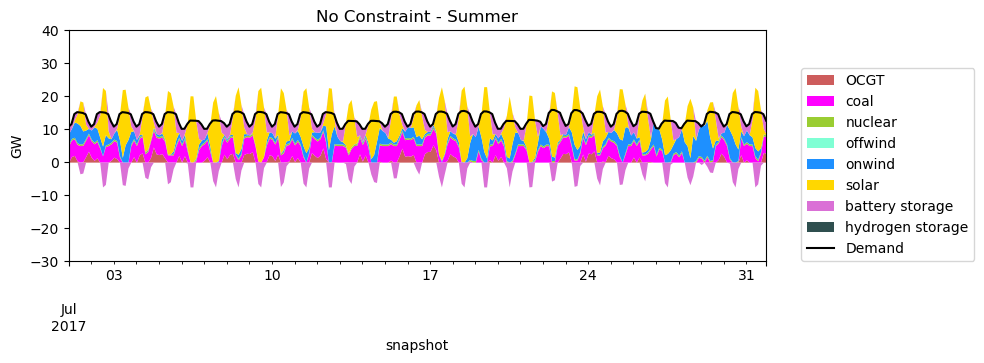

In [79]:
plot_dispatch(n_no_constraint, "2017-07", "No Constraint - Summer", "no_constraint_summer.png")

C:\Users\hiero\miniconda3\envs\esm-2024\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1794: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



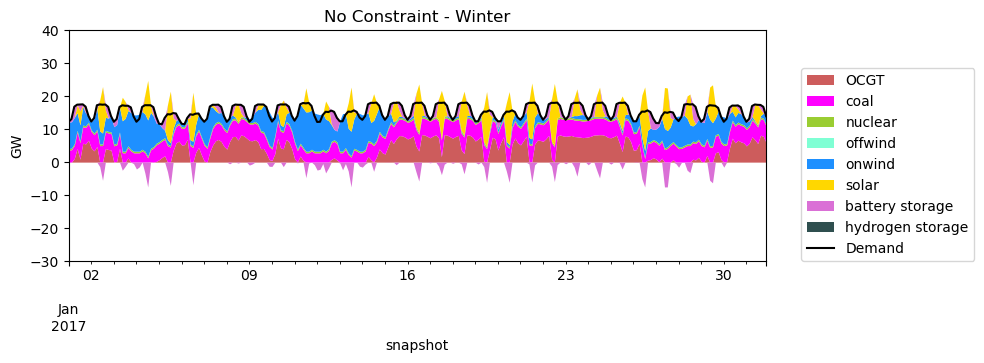

In [80]:
plot_dispatch(n_no_constraint, "2017-01", "No Constraint - Winter", "no_constraint_winter.png")

C:\Users\hiero\miniconda3\envs\esm-2024\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1794: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



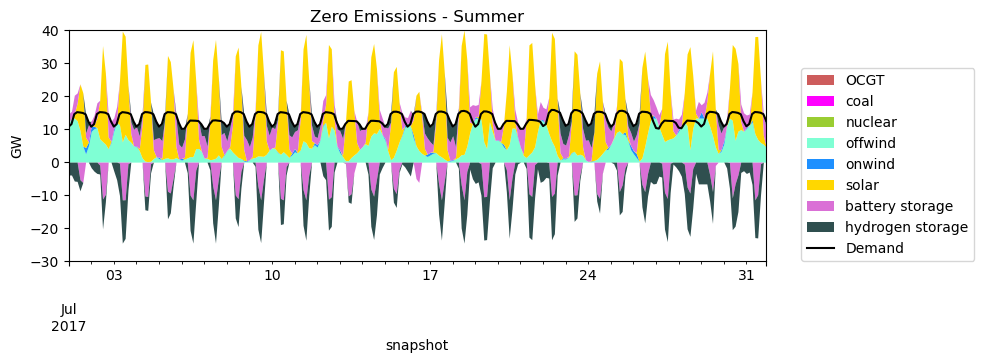

In [81]:
plot_dispatch(n_co2, "2017-07", "Zero Emissions - Summer", "zero_emissions_summer.png")

C:\Users\hiero\miniconda3\envs\esm-2024\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1794: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



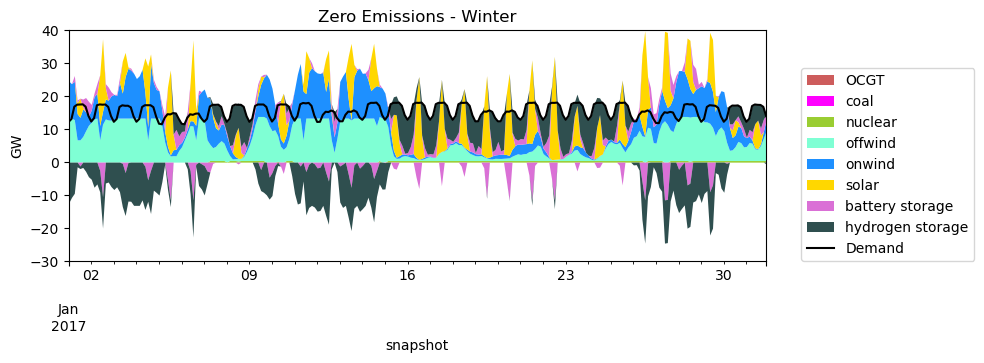

In [82]:
plot_dispatch(n_co2, "2017-01", "Zero Emissions - Winter", "zero_emissions_winter.png")

C:\Users\hiero\miniconda3\envs\esm-2024\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1794: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



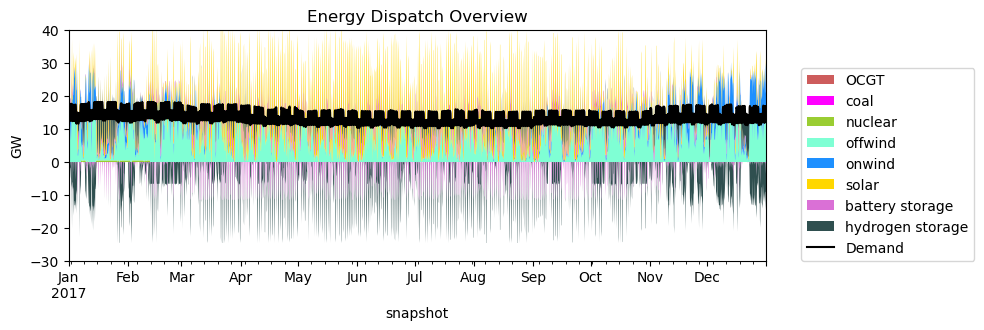

In [413]:
plot_dispatch(n_co2, "2017")#, "Zero Emissions - Winter", "zero_emissions_winter.png")

In [95]:
n_no_constraint.carriers

color  co2_emissions nice_name  \
Carrier                                                                
onwind                           dodgerblue            NaN             
offwind                          aquamarine            NaN             
solar                                  gold            NaN             
OCGT                              indianred         0.1980             
coal                                magenta         0.3361             
nuclear                         yellowgreen            NaN             
hydrogen storage underground  darkslategray            NaN             
battery storage                      orchid            NaN             
HVAC                                  brown         0.0000             

                              max_growth  max_relative_growth  
Carrier                                                        
onwind                               inf                  0.0  
offwind                              inf                  0.0  
solar                                inf                  0.0  
OCGT                                 inf                  0.0  
coal                                 inf                  0.0  
nuclear                              inf                  0.0  
hydrogen storage underground         inf                  0.0  
battery storage                      inf                  0.0  
HVAC                                 inf                  0.0

## system cost - done

In [381]:
def system_cost_total(n, title="System Cost Distribution", save_path=None):
    # Calculate total system cost
    #tsc = n.statistics.capex() + n.statistics.opex()
    #tsc_million_euro_per_year = tsc.droplevel(0).div(1e6)  # million €/a
    tsc = pd.concat([n.statistics.capex(), n.statistics.opex()], axis=1)
    tsc_million_euro_per_year = tsc.sum(axis=1).droplevel(0).div(1e6).round(2)

    # Filter out zero values to avoid displaying them in the pie chart
    tsc_nonzero = tsc_million_euro_per_year[tsc_million_euro_per_year > 0]

    # Define colors for carriers
    carrier_colors = {
        'onwind': 'dodgerblue',
        'offwind': 'aquamarine',
        'solar': 'gold',
        'OCGT': 'indianred',
        'coal': 'magenta',
        'nuclear': 'yellowgreen',
        'hydrogen storage underground': 'darkslategray',
        'battery storage': 'orchid',
        'HVAC': 'brown'
    }

    # Map carrier names to colors
    tsc_nonzero_colors = tsc_nonzero.index.map(lambda x: carrier_colors.get(x, 'gray'))

    # Plot pie chart
    fig, ax = plt.subplots()
    tsc_nonzero.plot.pie(
        ax=ax, 
        autopct=lambda pct: '{:.1f}%'.format(pct) if pct > 0 else '', 
        startangle=90, 
        colors=tsc_nonzero_colors,  # Use custom colors
        legend=False
    )
    ax.set_ylabel('')
    ax.set_title(title)

    # Calculate and display the sum of system cost below the plot
    total_cost = tsc_million_euro_per_year.sum()
    ax.text(0.5, -0.2, f'Total System Cost: {total_cost:.2f} million €/year', 
            horizontalalignment='center', verticalalignment='center', 
            transform=ax.transAxes, fontsize=10)

    # Save the figure if save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

    return tsc_million_euro_per_year

In [378]:
def system_cost_renewablesonly(n, title="System Cost Distribution", save_path=None):
    # Calculate total system cost
    tsc = n.statistics.capex() + n.statistics.opex()
    tsc_million_euro_per_year = tsc.droplevel(0).div(1e6)  # million €/a
    #tsc = pd.concat([n.statistics.capex(), n.statistics.opex()], axis=1)
    #tsc_million_euro_per_year = tsc.sum(axis=1).droplevel(0).div(1e6).round(2)
    print (tsc)

    # Filter out zero values to avoid displaying them in the pie chart
    tsc_nonzero = tsc_million_euro_per_year[tsc_million_euro_per_year > 0]

    # Define colors for carriers
    carrier_colors = {
        'onwind': 'dodgerblue',
        'offwind': 'aquamarine',
        'solar': 'gold',
        'OCGT': 'indianred',
        'coal': 'magenta',
        'nuclear': 'yellowgreen',
        'hydrogen storage underground': 'darkslategray',
        'battery storage': 'orchid',
        'HVAC': 'brown'
    }

    # Map carrier names to colors
    tsc_nonzero_colors = tsc_nonzero.index.map(lambda x: carrier_colors.get(x, 'gray'))

    # Plot pie chart
    fig, ax = plt.subplots()
    tsc_nonzero.plot.pie(
        ax=ax, 
        autopct=lambda pct: '{:.1f}%'.format(pct) if pct > 0 else '', 
        startangle=90, 
        colors=tsc_nonzero_colors,  # Use custom colors
        legend=False
    )
    ax.set_ylabel('')
    ax.set_title(title)

    # Calculate and display the sum of system cost below the plot
    total_cost = tsc_million_euro_per_year.sum()
    ax.text(0.5, -0.2, f'Total System Cost: {total_cost:.2f} million €/year', 
            horizontalalignment='center', verticalalignment='center', 
            transform=ax.transAxes, fontsize=10)

    # Save the figure if save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

    return tsc_million_euro_per_year

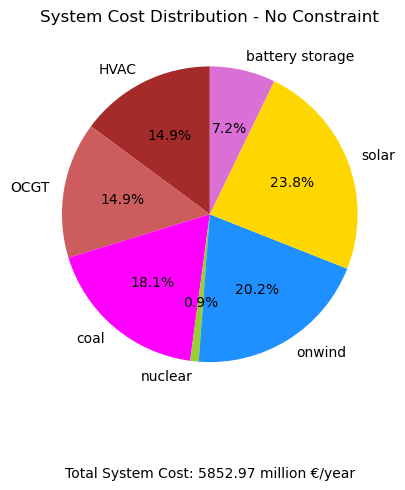

carrier
HVAC                             869.36
OCGT                             871.92
coal                            1061.02
nuclear                           54.03
offwind                            0.00
onwind                          1182.04
solar                           1394.75
battery storage                  419.85
hydrogen storage underground       0.00
dtype: float64

In [382]:
system_cost_total(n_no_constraint,"System Cost Distribution - No Constraint","no_constraint_syscost_tot.png" )

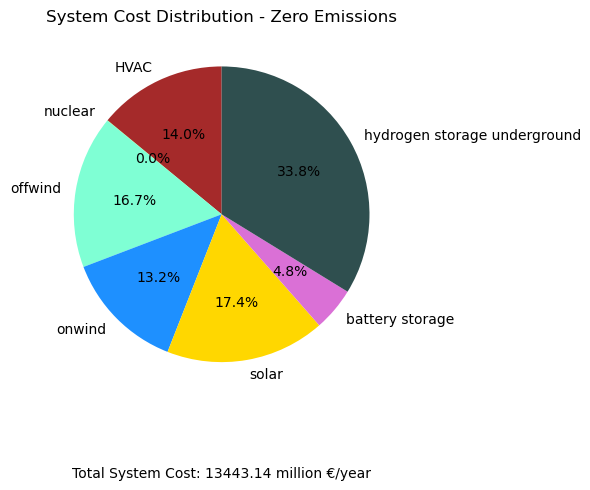

carrier
HVAC                            1886.61
OCGT                               0.00
coal                               0.00
nuclear                            4.87
offwind                         2248.71
onwind                          1780.20
solar                           2343.95
battery storage                  638.80
hydrogen storage underground    4540.00
dtype: float64

In [383]:
system_cost_total(n_co2,"System Cost Distribution - Zero Emissions","zero_emissions_syscost_tot.png" )

component    carrier                     
Generator    OCGT                            8.719201e+08
             coal                            1.061024e+09
             nuclear                         5.402942e+07
             offwind                                  NaN
             onwind                          1.182036e+09
             solar                           1.394746e+09
Link         HVAC                                     NaN
StorageUnit  battery storage                          NaN
             hydrogen storage underground             NaN
dtype: float64


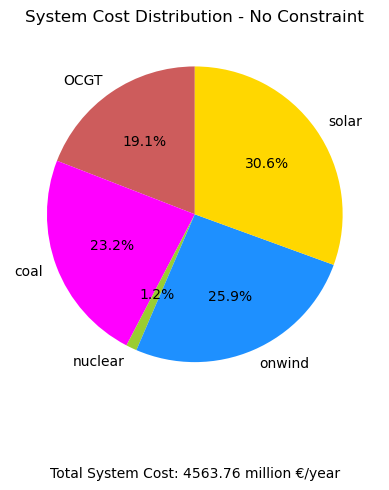

carrier
OCGT                             871.920121
coal                            1061.024278
nuclear                           54.029416
offwind                                 NaN
onwind                          1182.035625
solar                           1394.745746
HVAC                                    NaN
battery storage                         NaN
hydrogen storage underground            NaN
dtype: float64

In [380]:
system_cost_renewablesonly(n_no_constraint,"System Cost Distribution - No Constraint","no_constraint_syscost_renew.png" )

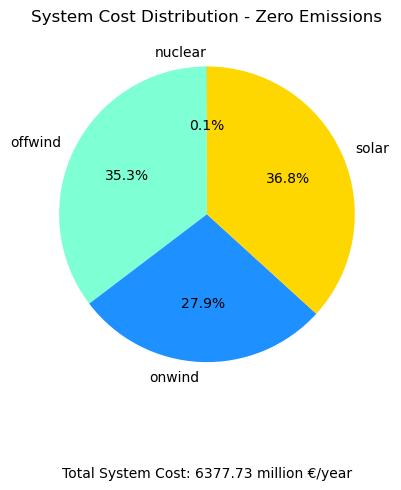

In [129]:
system_cost_renewablesonly(n_co2,"System Cost Distribution - Zero Emissions","zero_emissions_syscost_renew.png" )

## Storage Levels - done

In [156]:
#n_co2.storage_units_t.p.iloc[:, 0:5].head()

In [157]:
n_no_constraint.storage_units_t.p #ini adalah charge/discharge!

StorageUnit          battery storage region 1  battery storage region 2  \
snapshot                                                                  
2017-01-01 00:00:00                       0.0                 96.612502   
2017-01-01 03:00:00                       0.0                357.275364   
2017-01-01 06:00:00                       0.0                  0.000000   
2017-01-01 09:00:00                       0.0                  0.000000   
2017-01-01 12:00:00                       0.0                  0.000000   
...                                       ...                       ...   
2017-12-31 09:00:00                       0.0                  0.000000   
2017-12-31 12:00:00                       0.0                  0.000000   
2017-12-31 15:00:00                       0.0                  0.000000   
2017-12-31 18:00:00                       0.0                  0.000000   
2017-12-31 21:00:00                       0.0                  0.000000   

StorageUnit          battery storage region 3  battery storage region 4  \
snapshot                                                                  
2017-01-01 00:00:00                  0.000000                  0.000000   
2017-01-01 03:00:00                395.312995                 94.240567   
2017-01-01 06:00:00               1170.309147               2085.144494   
2017-01-01 09:00:00                  0.000000                  0.000000   
2017-01-01 12:00:00               1946.343634                  0.000000   
...                                       ...                       ...   
2017-12-31 09:00:00                  0.000000                -12.614342   
2017-12-31 12:00:00                  0.000000               -239.216386   
2017-12-31 15:00:00               1328.377748                613.745024   
2017-12-31 18:00:00                  0.000000                496.124308   
2017-12-31 21:00:00               -559.844567              -1204.285300   

StorageUnit          battery storage region 5  \
snapshot                                        
2017-01-01 00:00:00                       0.0   
2017-01-01 03:00:00                       0.0   
2017-01-01 06:00:00                       0.0   
2017-01-01 09:00:00                       0.0   
2017-01-01 12:00:00                       0.0   
...                                       ...   
2017-12-31 09:00:00                       0.0   
2017-12-31 12:00:00                       0.0   
2017-12-31 15:00:00                       0.0   
2017-12-31 18:00:00                       0.0   
2017-12-31 21:00:00                       0.0   

StorageUnit          hydrogen storage underground region 1  \
snapshot                                                     
2017-01-01 00:00:00                                    0.0   
2017-01-01 03:00:00                                    0.0   
2017-01-01 06:00:00                                    0.0   
2017-01-01 09:00:00                                    0.0   
2017-01-01 12:00:00                                    0.0   
...                                                    ...   
2017-12-31 09:00:00                                    0.0   
2017-12-31 12:00:00                                    0.0   
2017-12-31 15:00:00                                    0.0   
2017-12-31 18:00:00                                    0.0   
2017-12-31 21:00:00                                    0.0   

StorageUnit          hydrogen storage underground region 2  \
snapshot                                                     
2017-01-01 00:00:00                                    0.0   
2017-01-01 03:00:00                                    0.0   
2017-01-01 06:00:00                                    0.0   
2017-01-01 09:00:00                                    0.0   
2017-01-01 12:00:00                                    0.0   
...                                                    ...   
2017-12-31 09:00:00                                    0.0   
2017-12-31 12:00:00                          

In [158]:
n_no_constraint.storage_units_t.state_of_charge #ini adalah kapasitas lagi berapa

StorageUnit          battery storage region 1  battery storage region 2  \
snapshot                                                                  
2017-01-01 00:00:00                       0.0               2658.224185   
2017-01-01 03:00:00                       0.0               1541.738673   
2017-01-01 06:00:00                       0.0               1541.738673   
2017-01-01 09:00:00                       0.0               1541.738673   
2017-01-01 12:00:00                       0.0               1541.738673   
...                                       ...                       ...   
2017-12-31 09:00:00                       0.0               2960.138253   
2017-12-31 12:00:00                       0.0               2960.138253   
2017-12-31 15:00:00                       0.0               2960.138253   
2017-12-31 18:00:00                       0.0               2960.138253   
2017-12-31 21:00:00                       0.0               2960.138253   

StorageUnit          battery storage region 3  battery storage region 4  \
snapshot                                                                  
2017-01-01 00:00:00              13844.005075              19320.065556   
2017-01-01 03:00:00              12608.651966              19025.563784   
2017-01-01 06:00:00               8951.435881              12509.487240   
2017-01-01 09:00:00               8951.435881              12509.487240   
2017-01-01 12:00:00               2869.112025              12509.487240   
...                                       ...                       ...   
2017-12-31 09:00:00              16382.833184              18631.122363   
2017-12-31 12:00:00              16382.833184              19320.065556   
2017-12-31 15:00:00              12231.652722              17402.112354   
2017-12-31 18:00:00              12231.652722              15851.723893   
2017-12-31 21:00:00              13844.005075              19320.065556   

StorageUnit          battery storage region 5  \
snapshot                                        
2017-01-01 00:00:00                       0.0   
2017-01-01 03:00:00                       0.0   
2017-01-01 06:00:00                       0.0   
2017-01-01 09:00:00                       0.0   
2017-01-01 12:00:00                       0.0   
...                                       ...   
2017-12-31 09:00:00                       0.0   
2017-12-31 12:00:00                       0.0   
2017-12-31 15:00:00                       0.0   
2017-12-31 18:00:00                       0.0   
2017-12-31 21:00:00                       0.0   

StorageUnit          hydrogen storage underground region 1  \
snapshot                                                     
2017-01-01 00:00:00                                    0.0   
2017-01-01 03:00:00                                    0.0   
2017-01-01 06:00:00                                    0.0   
2017-01-01 09:00:00                                    0.0   
2017-01-01 12:00:00                                    0.0   
...                                                    ...   
2017-12-31 09:00:00                                    0.0   
2017-12-31 12:00:00                                    0.0   
2017-12-31 15:00:00                                    0.0   
2017-12-31 18:00:00                                    0.0   
2017-12-31 21:00:00                                    0.0   

StorageUnit          hydrogen storage underground region 2  \
snapshot                                                     
2017-01-01 00:00:00                                    0.0   
2017-01-01 03:00:00                                    0.0   
2017-01-01 06:00:00                                    0.0   
2017-01-01 09:00:00                                    0.0   
2017-01-01 12:00:00                                    0.0   
...                                                    ...   
2017-12-31 09:00:00                                    0.0   
2017-12-31 12:00:00                          

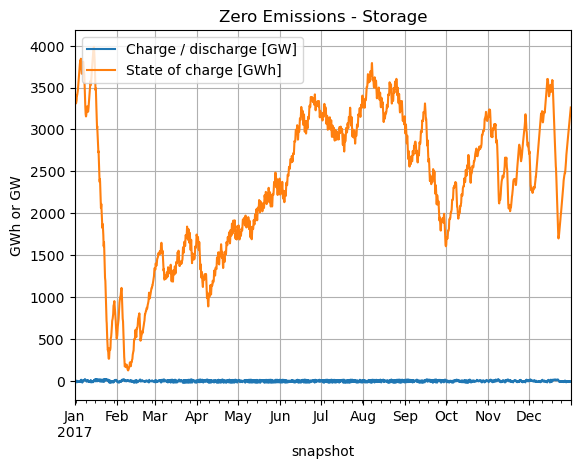

In [242]:
fig, ax = plt.subplots()

# Calculate p_storage and state_of_charge
p_storage = n_co2.storage_units_t.p.sum(axis=1).div(1e3)
state_of_charge = n_co2.storage_units_t.state_of_charge.sum(axis=1).div(1e3)

# Plotting the data
p_storage.plot(label="Charge / discharge [GW]", ax=ax)
state_of_charge.plot(label="State of charge [GWh]", ax=ax)

# Adding grid, legend, labels
ax.grid()
ax.legend()
ax.set_ylabel("GWh or GW")

# Adding title
ax.set_title("Zero Emissions - Storage")

# Save the figure to a specific path
save_path = 'zero_emissions_storage_state_of_charge.png'
plt.savefig(save_path)

# Display the plot
plt.show()

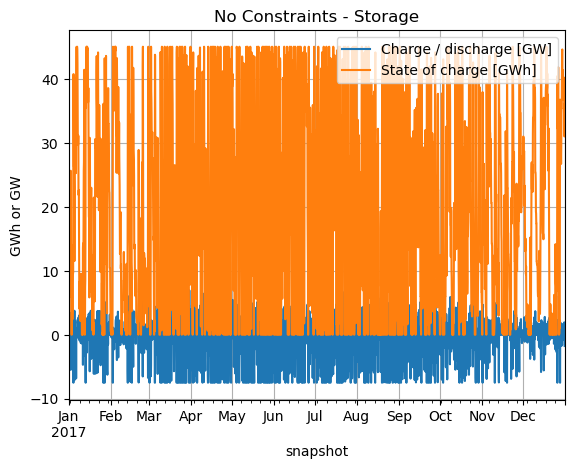

In [159]:
fig, ax = plt.subplots()

# Calculate p_storage and state_of_charge
p_storage = n_no_constraint.storage_units_t.p.sum(axis=1).div(1e3)
state_of_charge = n_no_constraint.storage_units_t.state_of_charge.sum(axis=1).div(1e3)

# Plotting the data
p_storage.plot(label="Charge / discharge [GW]", ax=ax)
state_of_charge.plot(label="State of charge [GWh]", ax=ax)

# Adding grid, legend, labels
ax.grid()
ax.legend()
ax.set_ylabel("GWh or GW")

# Adding title
ax.set_title("No Constraints - Storage")

# Save the figure to a specific path
save_path = 'n_no_constraint_storage_state_of_charge.png'
plt.savefig(save_path)

# Display the plot
plt.show()

## Sensitivity Analysis - done

In [160]:
n_co2 = pypsa.Network("optimized pypsa networks/n_co2.nc")
n_sens_075 = pypsa.Network("optimized pypsa networks/n_sens_075.nc")
n_sens_05 = pypsa.Network("optimized pypsa networks/n_sens_05.nc")
n_sens_025 = pypsa.Network("optimized pypsa networks/n_sens_025.nc")
n_sens_0 = pypsa.Network("optimized pypsa networks/n_sens_0.nc")

INFO:pypsa.io:Imported network n_co2.nc has buses, carriers, generators, global_constraints, links, loads, storage_units
INFO:pypsa.io:Imported network n_sens_075.nc has buses, carriers, generators, global_constraints, links, loads, storage_units
INFO:pypsa.io:Imported network n_sens_05.nc has buses, carriers, generators, global_constraints, links, loads, storage_units
INFO:pypsa.io:Imported network n_sens_025.nc has buses, carriers, generators, global_constraints, links, loads, storage_units
INFO:pypsa.io:Imported network n_sens_0.nc has buses, carriers, generators, global_constraints, links, loads, storage_units


#### system cost

In [227]:
sensitivity = [n_co2, n_sens_075, n_sens_05, n_sens_025, n_sens_0]

sens_obj = {}

key_names = ["1", ".75", ".5", ".25", "0"]

for key, s in zip(key_names, sensitivity):
    sens_obj[key] = s.objective

print(sens_obj)

{'1': 13443140342.651289, '.75': 12829617457.954344, '.5': 11981104278.16579, '.25': 10676232651.625961, '0': 7029210516.80288}


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


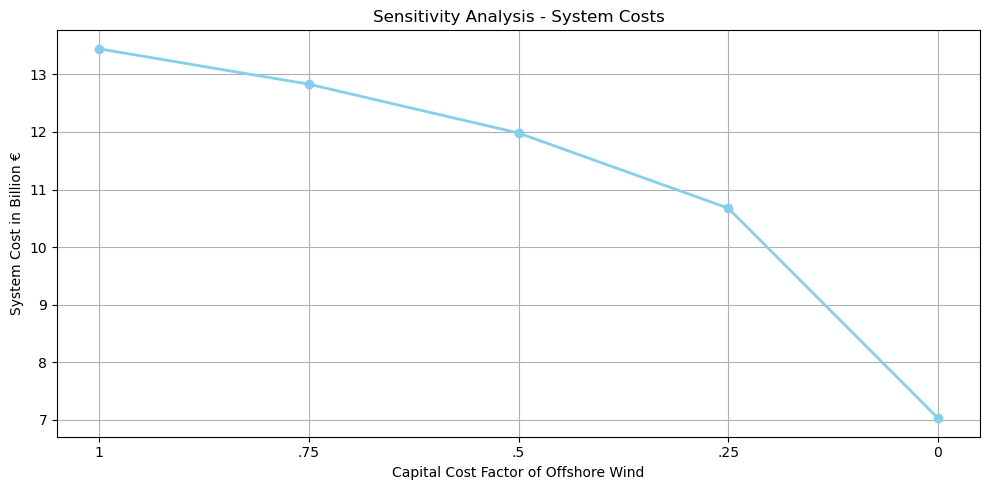

In [228]:
# Extract keys and values
model_names = list(sens_obj.keys())
objectives = list(sens_obj.values())

# Plotting as a line curve
plt.figure(figsize=(10, 5))
plt.plot(model_names, [obj / 1e9 for obj in objectives] , marker='o', linestyle='-', color='skyblue', linewidth=2)
plt.xlabel('Capital Cost Factor of Offshore Wind')
plt.ylabel('System Cost in Billion €')
plt.title('Sensitivity Analysis - System Costs')
plt.xticks#(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### p_nom_opt

In [229]:
sensitivity = [n_co2, n_sens_075, n_sens_05, n_sens_025, n_sens_0]

sens_p = {}

key_names = ["1", ".75", ".5", ".25", "0"]

for key, s in zip(key_names, sensitivity):
    sens_p[key] = s.generators.loc["Offshore region 5"].p_nom_opt

print(sens_p)

{'1': 14236.780699273917, '.75': 16695.574488876584, '.5': 27604.258412818348, '.25': 41762.8966830512, '0': 135318.06}


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


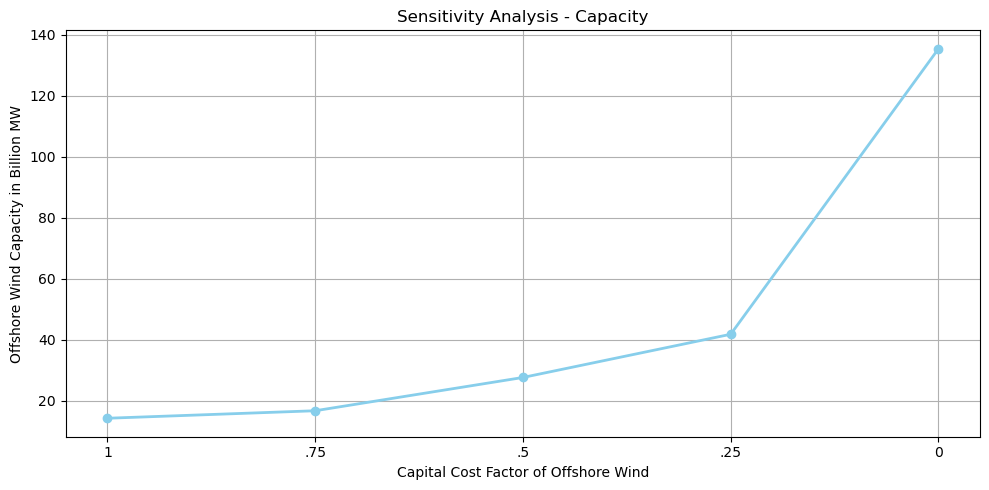

In [230]:
# Extract keys and values
model_names = list(sens_p.keys())
objectives = list(sens_p.values())

# Plotting as a line curve
plt.figure(figsize=(10, 5))
plt.plot(model_names, [obj / 1e3 for obj in objectives] , marker='o', linestyle='-', color='skyblue', linewidth=2)
plt.xlabel('Capital Cost Factor of Offshore Wind')
plt.ylabel('Offshore Wind Capacity in Billion MW')
plt.title('Sensitivity Analysis - Capacity')
plt.xticks#(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### battery storage

In [231]:
n_co2.storage_units["p_nom_opt"].iloc[0:5].sum() #battery storage

11435.580082600887

In [232]:
sensitivity = [n_co2, n_sens_075, n_sens_05, n_sens_025, n_sens_0]

sens_bat = {}

key_names = ["1", ".75", ".5", ".25", "0"]

for key, s in zip(key_names, sensitivity):
    sens_bat[key] = s.storage_units["p_nom_opt"].iloc[0:5].sum() #battery storage

print(sens_bat)

{'1': 11435.580082600887, '.75': 10332.012702345195, '.5': 8590.767970759247, '.25': 9880.650917785239, '0': 35119.54516940593}


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


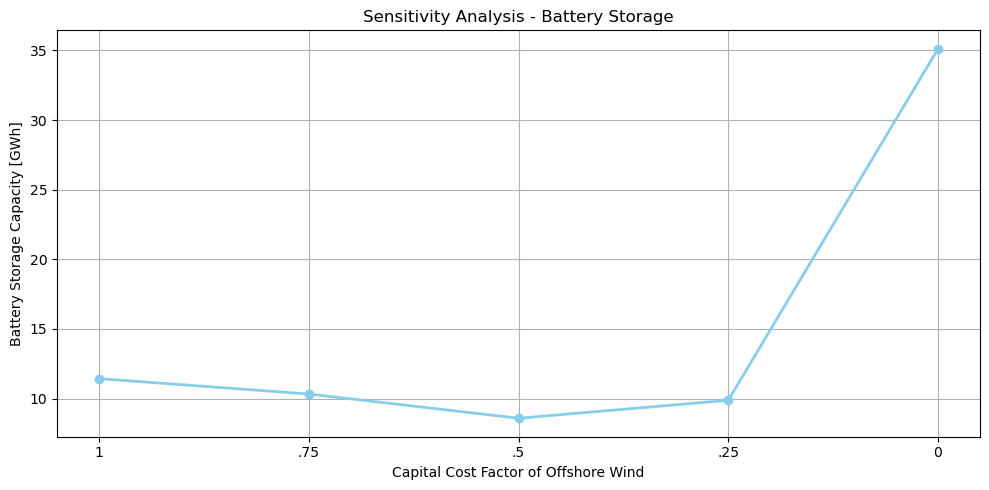

In [233]:
# Extract keys and values
model_names = list(sens_bat.keys())
objectives = list(sens_bat.values())

# Plotting as a line curve
plt.figure(figsize=(10, 5))
plt.plot(model_names, [obj / 1e3 for obj in objectives] , marker='o', linestyle='-', color='skyblue', linewidth=2)
plt.xlabel('Capital Cost Factor of Offshore Wind')
plt.ylabel('Battery Storage Capacity [GWh]')
plt.title('Sensitivity Analysis - Battery Storage')
plt.xticks#(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### hydrogen storage

In [234]:
n_co2.storage_units["p_nom_opt"].iloc[5:].sum() #hydrogen storage

13100.267624819435

In [235]:
sensitivity = [n_co2, n_sens_075, n_sens_05, n_sens_025, n_sens_0]

sens_hyd = {}

key_names = ["1", ".75", ".5", ".25", "0"]

for key, s in zip(key_names, sensitivity):
    sens_hyd[key] = s.storage_units["p_nom_opt"].iloc[5:].sum() #hydrogen storage

print(sens_hyd)

{'1': 13100.267624819435, '.75': 12344.538960705977, '.5': 10570.236231857209, '.25': 9265.422537335571, '0': 1106.1891638726258}


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


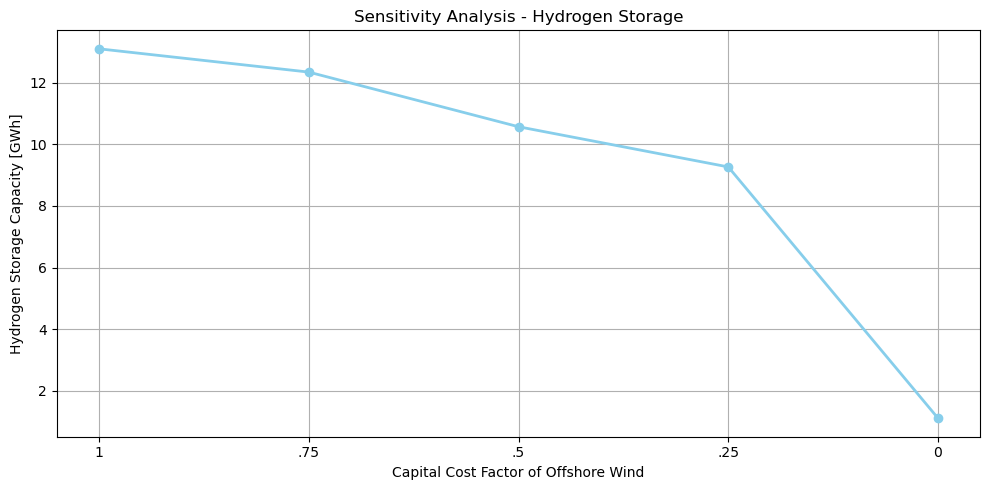

In [236]:
# Extract keys and values
model_names = list(sens_hyd.keys())
objectives = list(sens_hyd.values())

# Plotting as a line curve
plt.figure(figsize=(10, 5))
plt.plot(model_names, [obj / 1e3 for obj in objectives] , marker='o', linestyle='-', color='skyblue', linewidth=2)
plt.xlabel('Capital Cost Factor of Offshore Wind')
plt.ylabel('Hydrogen Storage Capacity [GWh]')
plt.title('Sensitivity Analysis - Hydrogen Storage')
plt.xticks#(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### combined

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

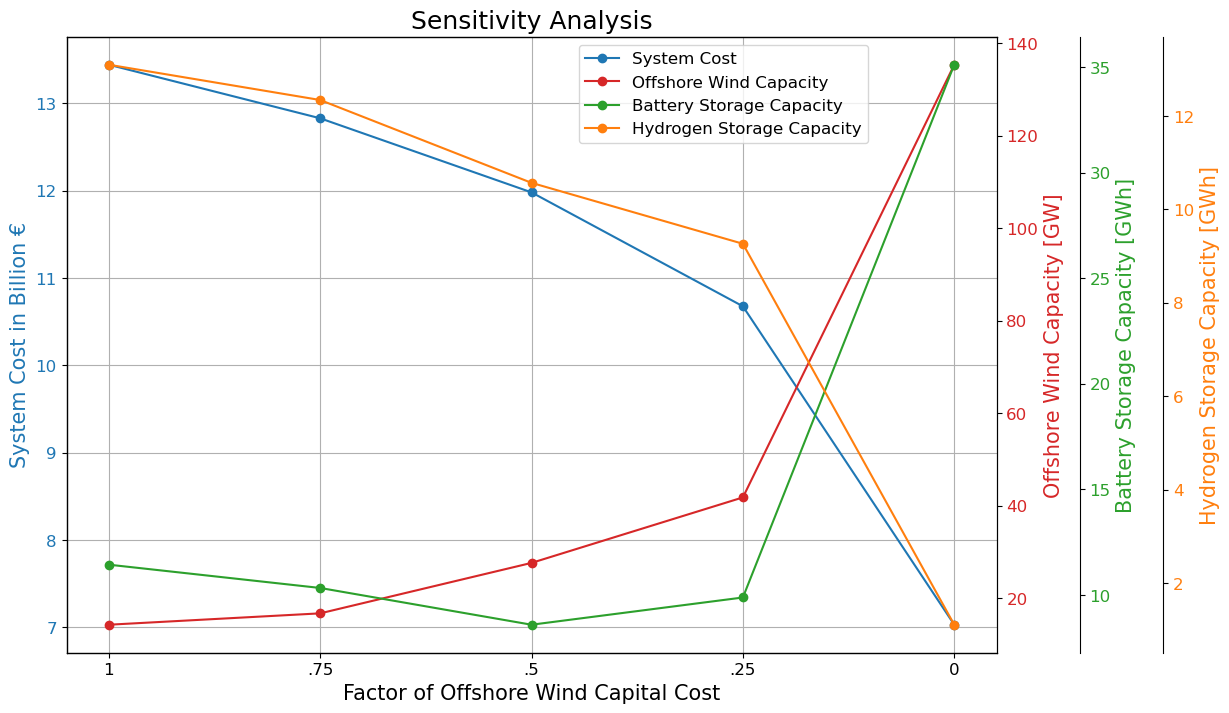

In [372]:
# Extract keys and values for objectives
model_names_obj = list(sens_obj.keys())
objectives_obj = list(sens_obj.values())

# Extract keys and values for capacity (p)
model_names_p = list(sens_p.keys())
objectives_p = list(sens_p.values())

# Extract keys and values for battery storage
model_names_bat = list(sens_bat.keys())
objectives_bat = list(sens_bat.values())

# Extract keys and values for hydrogen storage
model_names_hyd = list(sens_hyd.keys())
objectives_hyd = list(sens_hyd.values())

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plotting objectives (system costs)
color_obj = 'tab:blue'
ax1.set_xlabel('Factor of Offshore Wind Capital Cost', fontsize=15)  # Adjusted fontsize
ax1.set_ylabel('System Cost in Billion €', color=color_obj, fontsize=15)  # Adjusted fontsize
ax1.plot(model_names_obj, [obj / 1e9 for obj in objectives_obj], marker='o', linestyle='-', color=color_obj, label='System Cost')
ax1.tick_params(axis='y', labelcolor=color_obj, labelsize=12)  # Adjusted labelsize
ax1.tick_params(axis='x', labelsize=12)  # Adjusted labelsize
ax1.grid(True)
ax1.set_title('Sensitivity Analysis', fontsize=18)  # Adjusted fontsize

# Creating twin y-axis for p (capacity)
ax2 = ax1.twinx()
color_p = 'tab:red'
ax2.set_ylabel('Offshore Wind Capacity [GW]', color=color_p, fontsize=15)  # Adjusted fontsize
ax2.plot(model_names_p, [obj / 1e3 for obj in objectives_p], marker='o', linestyle='-', color=color_p, label='Offshore Wind Capacity')
ax2.tick_params(axis='y', labelcolor=color_p, labelsize=12)  # Adjusted labelsize

# Creating twin y-axis for battery storage
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
color_bat = 'tab:green'
ax3.set_ylabel('Battery Storage Capacity [GWh]', color=color_bat, fontsize=15)  # Adjusted fontsize
ax3.plot(model_names_bat, [obj / 1e3 for obj in objectives_bat], marker='o', linestyle='-', color=color_bat, label='Battery Storage Capacity')
ax3.tick_params(axis='y', labelcolor=color_bat, labelsize=12)  # Adjusted labelsize

# Creating twin y-axis for hydrogen storage
ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))
color_hyd = 'tab:orange'
ax4.set_ylabel('Hydrogen Storage Capacity [GWh]', color=color_hyd, fontsize=15)  # Adjusted fontsize
ax4.plot(model_names_hyd, [obj / 1e3 for obj in objectives_hyd], marker='o', linestyle='-', color=color_hyd, label='Hydrogen Storage Capacity')
ax4.tick_params(axis='y', labelcolor=color_hyd, labelsize=12)  # Adjusted labelsize

# Combine all legend handles and labels from all axes
handles, labels = [], []
for ax in [ax1, ax2, ax3, ax4]:
    ax_handles, ax_labels = ax.get_legend_handles_labels()
    handles.extend(ax_handles)
    labels.extend(ax_labels)

# Add legend at top right corner
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.8, 0.88), fontsize=12)

# Save the figure to a specific path
save_path = 'sensitivity.png'
plt.savefig(save_path)

plt.show()

### storage again

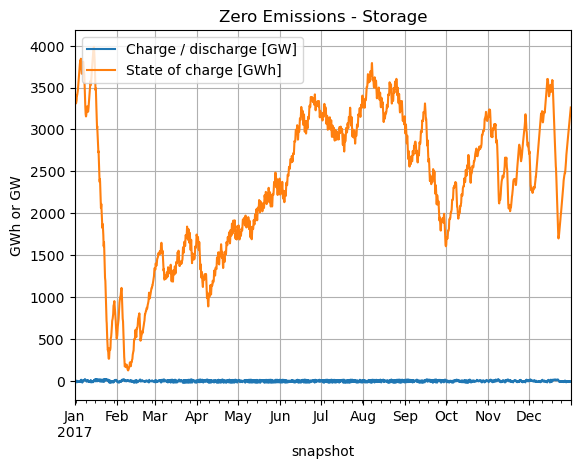

In [244]:
fig, ax = plt.subplots()

# Calculate p_storage and state_of_charge
p_storage = n_co2.storage_units_t.p.sum(axis=1).div(1e3)
state_of_charge = n_co2.storage_units_t.state_of_charge.sum(axis=1).div(1e3)

# Plotting the data
p_storage.plot(label="Charge / discharge [GW]", ax=ax)
state_of_charge.plot(label="State of charge [GWh]", ax=ax)

# Adding grid, legend, labels
ax.grid()
ax.legend()
ax.set_ylabel("GWh or GW")

# Adding title
ax.set_title("Zero Emissions - Storage")

# Save the figure to a specific path
save_path = 'zero_emissions_storage_state_of_charge.png'
plt.savefig(save_path)

# Display the plot
plt.show()

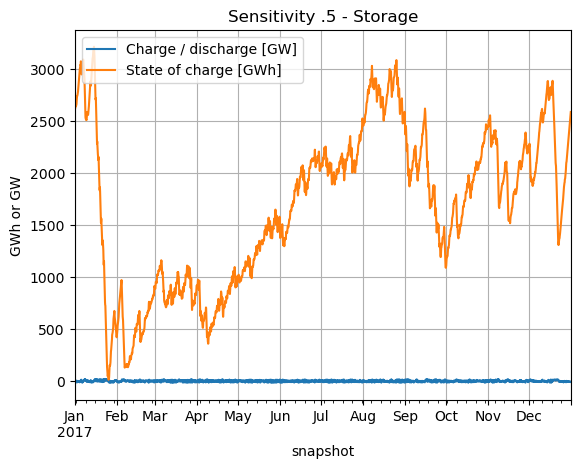

In [249]:
fig, ax = plt.subplots()

# Calculate p_storage and state_of_charge
p_storage = n_sens_05.storage_units_t.p.sum(axis=1).div(1e3)
state_of_charge = n_sens_05.storage_units_t.state_of_charge.sum(axis=1).div(1e3)

# Plotting the data
p_storage.plot(label="Charge / discharge [GW]", ax=ax)
state_of_charge.plot(label="State of charge [GWh]", ax=ax)

# Adding grid, legend, labels
ax.grid()
ax.legend()
ax.set_ylabel("GWh or GW")

# Adding title
ax.set_title("Sensitivity .5 - Storage")

# Save the figure to a specific path
save_path = 'sens05_storage_state_of_charge.png'
plt.savefig(save_path)

# Display the plot
plt.show()

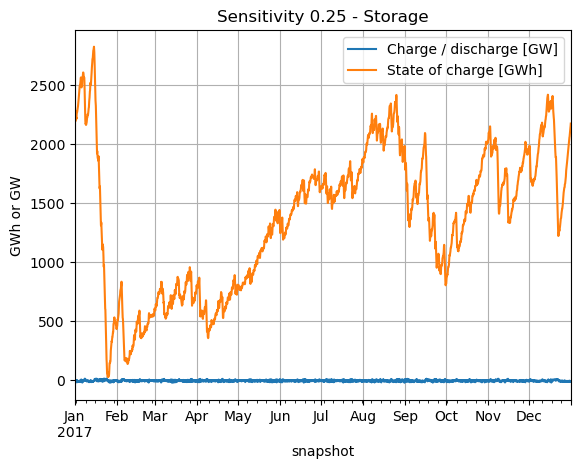

In [250]:
fig, ax = plt.subplots()

# Calculate p_storage and state_of_charge
p_storage = n_sens_025.storage_units_t.p.sum(axis=1).div(1e3)
state_of_charge = n_sens_025.storage_units_t.state_of_charge.sum(axis=1).div(1e3)

# Plotting the data
p_storage.plot(label="Charge / discharge [GW]", ax=ax)
state_of_charge.plot(label="State of charge [GWh]", ax=ax)

# Adding grid, legend, labels
ax.grid()
ax.legend()
ax.set_ylabel("GWh or GW")

# Adding title
ax.set_title("Sensitivity 0.25 - Storage")

# Save the figure to a specific path
save_path = 'sens0.25_storage_state_of_charge.png'
plt.savefig(save_path)

# Display the plot
plt.show()

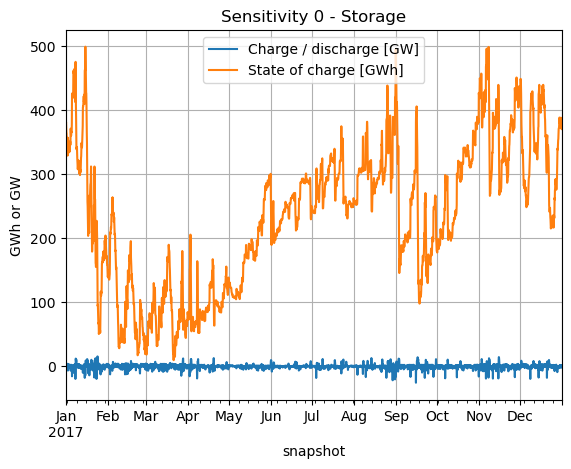

In [248]:
fig, ax = plt.subplots()

# Calculate p_storage and state_of_charge
p_storage = n_sens_0.storage_units_t.p.sum(axis=1).div(1e3)
state_of_charge = n_sens_0.storage_units_t.state_of_charge.sum(axis=1).div(1e3)

# Plotting the data
p_storage.plot(label="Charge / discharge [GW]", ax=ax)
state_of_charge.plot(label="State of charge [GWh]", ax=ax)

# Adding grid, legend, labels
ax.grid()
ax.legend()
ax.set_ylabel("GWh or GW")

# Adding title
ax.set_title("Sensitivity 0 - Storage")

# Save the figure to a specific path
save_path = 'sens0_storage_state_of_charge.png'
plt.savefig(save_path)

# Display the plot
plt.show()

## Electricity Mix / Region / Bus and Line Plot

In [343]:
x = n_co2.buses["x"]
y = n_co2.buses["y"]

In [357]:
n_test = n_co2.copy()
n_test.buses["x"] = y
n_test.buses["y"] = x

n_test_no_constraint = n_no_constraint.copy()
n_test_no_constraint.buses["x"] = y
n_test_no_constraint.buses["y"] = x

n_test_05 = n_sens_05.copy()
n_test_05.buses["x"] = y
n_test_05.buses["y"] = x

C:\Users\hiero\miniconda3\envs\esm-2024\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



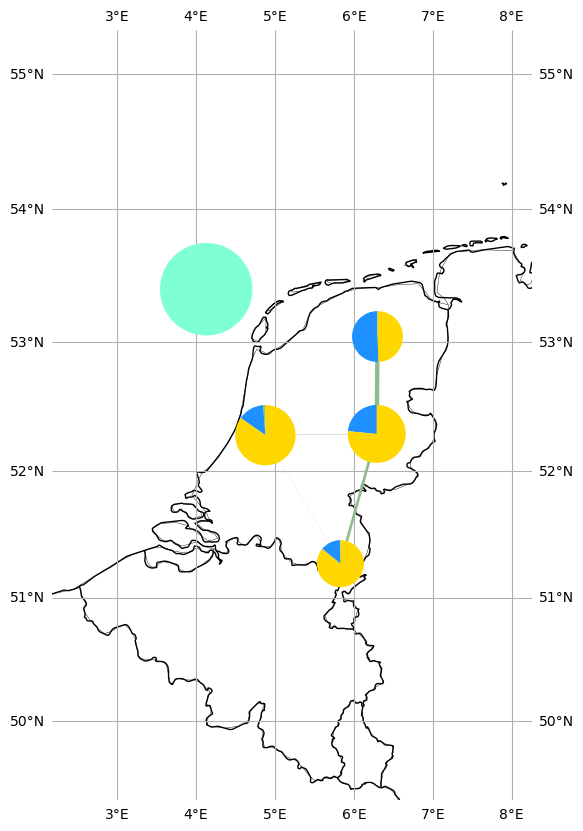

In [360]:
fig = plt.figure(figsize=(7, 10))
ax = plt.axes(projection=ccrs.Mercator())

# Normalize the link data for color mapping
norm = plt.Normalize(vmin=n_test_no_constraint.links_t.p0.iloc[0].abs().min(), vmax=n_test_no_constraint.links_t.p0.iloc[0].abs().max())

n_test_no_constraint.plot(
    ax=ax,
    margin=0.9,
    bus_sizes= capacities / 5e7 * 0.5,  # Adjust the scaling factor as needed
    link_norm=norm,
    link_cmap='jet',
    link_widths=n_test_no_constraint.links_t.p0.iloc[0].abs() / 1e3,
)

# Add gridlines and coastlines for better visualization
ax.gridlines(draw_labels=True)
ax.coastlines()
ax.add_feature(cfeature.BORDERS)

plt.show()

In [363]:
n_co2.generators

bus   p_nom  p_nom_extendable  p_nom_max  carrier  \
Generator                                                                   
onwind region 1    Region 1     0.0              True    7048.89   onwind   
onwind region 2    Region 2     0.0              True    5960.25   onwind   
onwind region 3    Region 3     0.0              True    3431.43   onwind   
onwind region 4    Region 4     0.0              True    2027.16   onwind   
solar_pv region 1  Region 1     0.0              True   18147.51    solar   
solar_pv region 2  Region 2     0.0              True   17715.51    solar   
solar_pv region 3  Region 3     0.0              True   18885.96    solar   
solar_pv region 4  Region 4     0.0              True   12247.20    solar   
Offshore region 5  Region 5     0.0              True  135318.06  offwind   
coal region 1      Region 1  1600.0             False        inf     coal   
coal region 2      Region 2   590.0             False        inf     coal   
coal region 3      Region 3  2825.0             False        inf     coal   
gas region 1       Region 1  4306.0             False        inf     OCGT   
gas region 2       Region 2  2228.0             False        inf     OCGT   
gas region 3       Region 3  2778.0             False        inf     OCGT   
Nuclear region 3   Region 3   485.0             False        inf  nuclear   

                   marginal_cost   capital_cost  efficiency     p_nom_opt  \
Generator                                                                   
onwind region 1         1.300000   94880.655596       1.000   7048.890000   
onwind region 2         1.300000   94880.655596       1.000   5960.250000   
onwind region 3         1.300000   94880.655596       1.000   3431.430000   
onwind region 4         1.300000   94880.655596       1.000   2027.160000   
solar_pv region 1       0.010600   41036.381341       1.000   8253.382018   
solar_pv region 2       0.010600   41036.381341       1.000  17715.510000   
solar_pv region 3       0.010600   41036.381341       1.000  18885.960000   
solar_pv region 4       0.010600   41036.381341       1.000  12247.200000   
Offshore region 5       0.021200  157857.008715       1.000  14236.780699   
coal region 1          32.213321       0.000000       0.330   1600.000000   
coal region 2          32.213321       0.000000       0.330    590.000000   
coal region 3          32.213321       0.000000       0.330   2825.000000   
gas region 1           62.569059       0.000000       0.425   4306.000000   
gas region 2           62.569059       0.000000       0.425   2228.000000   
gas region 3           62.569059       0.000000       0.425   2778.000000   
Nuclear region 3       14.013271       0.000000       0.326    485.000000   

                  control  ... stand_by_cost  min_up_time  min_down_time  \
Generator                  ...                                             
onwind region 1        PQ  ...           0.0            0              0   
onwind region 2        PQ  ...           0.0            0              0   
onwind region 3        PQ  ...           0.0            0              0   
onwind region 4        PQ  ...           0.0            0              0   
solar_pv region 1      PQ  ...           0.0            0              0   
solar_pv region 2      PQ  ...           0.0            0              0   
solar_pv region 3      PQ  ...           0.0            0              0   
solar_pv region 4      PQ  ...           0.0            0              0   
Offshore region 5      PQ  ...           0.0            0              0   
coal region 1          PQ  ...           0.0            0              0   
coal region 2          PQ  ...           0.0            0              0   
coal region 3          PQ  ...           0.0            0              0   
gas region 1           PQ  ...           0.0            0              0   
gas region 2           PQ  ...           0.0            0              0   
gas region 3           PQ  ...    

C:\Users\hiero\miniconda3\envs\esm-2024\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



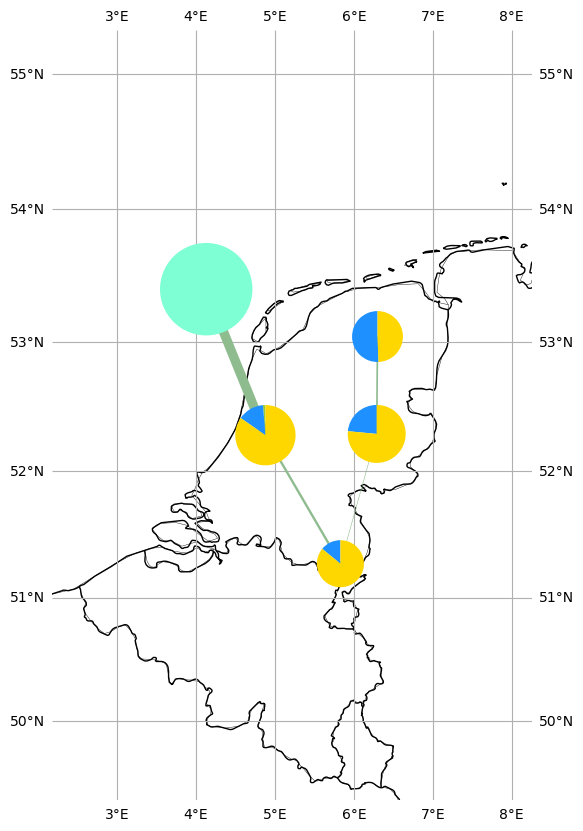

In [354]:
fig = plt.figure(figsize=(7, 10))
ax = plt.axes(projection=ccrs.Mercator())

# Normalize the link data for color mapping
norm = plt.Normalize(vmin=n_co2.links_t.p0.iloc[0].abs().min(), vmax=n_co2.links_t.p0.iloc[0].abs().max())

n_test.plot(
    ax=ax,
    margin=0.9,
    bus_sizes= capacities / 5e7 * 0.5,  # Adjust the scaling factor as needed
    link_norm=norm,
    link_cmap='jet',
    link_widths=n_co2.links_t.p0.iloc[0].abs() / 1e3,
)

# Add gridlines and coastlines for better visualization
ax.gridlines(draw_labels=True)
ax.coastlines()
ax.add_feature(cfeature.BORDERS)



plt.show()

C:\Users\hiero\miniconda3\envs\esm-2024\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



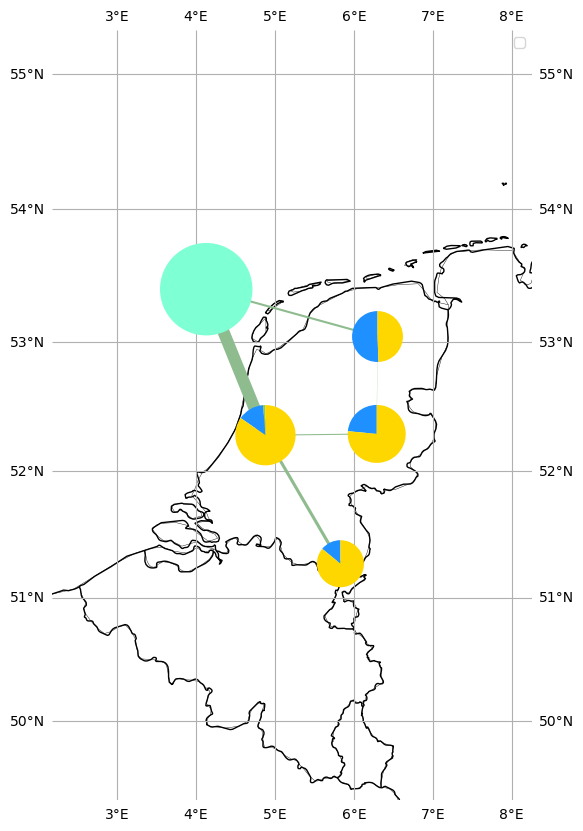

In [364]:
fig = plt.figure(figsize=(7, 10))
ax = plt.axes(projection=ccrs.Mercator())

# Normalize the link data for color mapping
norm = plt.Normalize(vmin=n_test_05.links_t.p0.iloc[0].abs().min(), vmax=n_test_05.links_t.p0.iloc[0].abs().max())

n_test_05.plot(
    ax=ax,
    margin=0.9,
    bus_sizes= capacities / 5e7 * 0.5,  # Adjust the scaling factor as needed
    link_norm=norm,
    link_cmap='jet',
    link_widths=n_test_05.links_t.p0.iloc[0].abs() / 1e3,
)

# Add gridlines and coastlines for better visualization
ax.gridlines(draw_labels=True)
ax.coastlines()
ax.add_feature(cfeature.BORDERS)

ax.legend()

# Save the figure to a specific path
save_path = 'transmission.png'
plt.savefig(save_path)

plt.show()

## Additional plots for the presentation

### ERA5 xarray wind and solar

<xarray.DataArray 'wnd100m' (time: 8760, y: 14, x: 17)> Size: 17MB
[2084880 values with dtype=float64]
Coordinates:
  * x        (x) float64 136B 3.25 3.5 3.75 4.0 4.25 ... 6.25 6.5 6.75 7.0 7.25
  * y        (y) float64 112B 50.5 50.75 51.0 51.25 ... 53.0 53.25 53.5 53.75
  * time     (time) datetime64[ns] 70kB 2017-01-01 ... 2017-12-31T23:00:00
    lon      (x) float64 136B ...
    lat      (y) float64 112B ...
Attributes:
    units:      m s**-1
    long_name:  100 metre wind speed
    module:     era5
    feature:    wind
[(6.307699560864975, 53.0394458775001), (6.292400568002548, 52.29567146350013), (4.882798003633604, 52.28966331550015), (5.831101490893536, 51.276088714500105), (4.137436989501846, 53.40210348408881)]


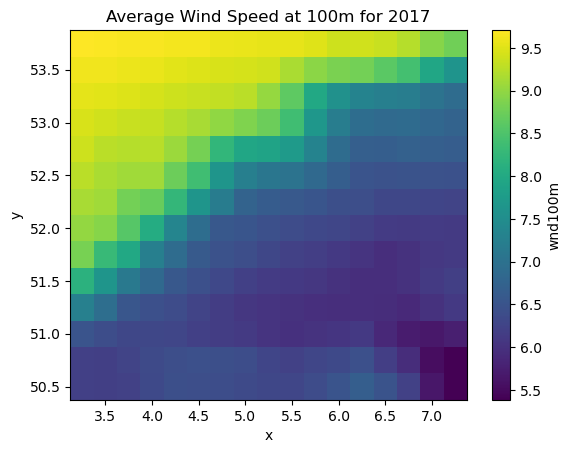

Average wind speed at 100m for 2017 at Region 1 (6.307699560864975, 53.0394458775001): 6.909188240551214 m/s
Average wind speed at 100m for 2017 at Region 2 (6.292400568002548, 52.29567146350013): 6.407384778681932 m/s
Average wind speed at 100m for 2017 at Region 3 (4.882798003633604, 52.28966331550015): 6.742001913283314 m/s
Average wind speed at 100m for 2017 at Region 4 (5.831101490893536, 51.276088714500105): 5.965029890718889 m/s
Average wind speed at 100m for 2017 at Region 5 (4.137436989501846, 53.40210348408881): 9.520054533751775 m/s


In [56]:
import xarray as xr
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Load the dataset using xarray
file_path = "era5-2017-nl.nc"
cutout = xr.open_dataset(file_path)

# Access wind speed data at 100 meters
wind_speed = cutout['wnd100m']

# Print the wind speed data
print(wind_speed)


fn = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fgadm&files=gadm_410-levels-ADM_1-NLD.gpkg"
regions = gpd.read_file(fn)
regions["regions"]= [1,2,1,2,1,2,4,4,3,2,3,3,3,3] 
regions
combined_regions = combined_regions.dissolve(by="Region")
points5 = combined_regions.representative_point()
points10 = points5.to_crs(3857)
coordinates = [(point.x, point.y) for point in points5]
average_wind_speed = wind_speed.mean(dim='time').compute()
print(coordinates)

# Visualize the average wind speed
average_wind_speed.plot()
plt.title('Average Wind Speed at 100m for 2017')
plt.show()

# Extract and print average wind speed for each coordinate
for i, (specific_x, specific_y) in enumerate(coordinates):
    # Find the nearest indexes for the specific coordinates
    nearest_point = average_wind_speed.sel(x=specific_x, y=specific_y, method='nearest')
    
    # Print average wind speed for the specific location
    print(f'Average wind speed at 100m for 2017 at Region {i+1} ({specific_x}, {specific_y}): {nearest_point.values} m/s')

<xarray.DataArray 'influx_toa' (time: 8760, y: 14, x: 17)> Size: 17MB
[2084880 values with dtype=float64]
Coordinates:
  * x        (x) float64 136B 3.25 3.5 3.75 4.0 4.25 ... 6.25 6.5 6.75 7.0 7.25
  * y        (y) float64 112B 50.5 50.75 51.0 51.25 ... 53.0 53.25 53.5 53.75
  * time     (time) datetime64[ns] 70kB 2017-01-01 ... 2017-12-31T23:00:00
    lon      (x) float64 136B ...
    lat      (y) float64 112B ...
Attributes:
    units:    W m**-2
    module:   era5
    feature:  influx


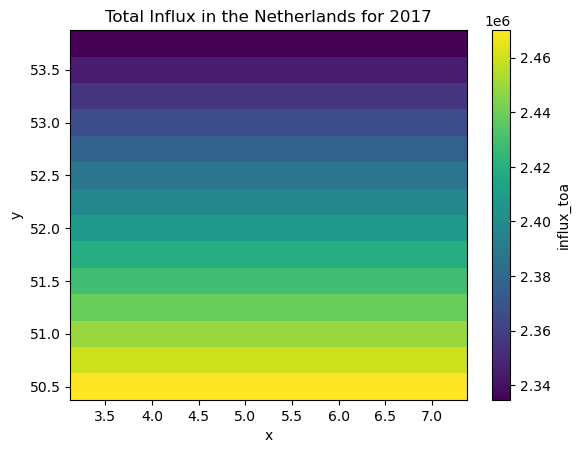

Total influx for 2017 at Region 1 (6.307699560864975, 53.0394458775001): 2.3661756435627814 MW/m^2
Total influx for 2017 at Region 2 (6.292400568002548, 52.29567146350013): 2.397512857889738 MW/m^2
Total influx for 2017 at Region 3 (4.882798003633604, 52.28966331550015): 2.3975176237611295 MW/m^2
Total influx for 2017 at Region 4 (5.831101490893536, 51.276088714500105): 2.4390873391391206 MW/m^2
Total influx for 2017 at Region 5 (4.137436989501846, 53.40210348408881): 2.3452191858044693 MW/m^2


In [57]:
cutout = xr.open_dataset(file_path)

influx = cutout['influx_toa']

# Print the wind speed data
print(influx)

fn = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fgadm&files=gadm_410-levels-ADM_1-NLD.gpkg"
regions = gpd.read_file(fn)
regions["regions"]= [1,2,1,2,1,2,4,4,3,2,3,3,3,3] 
regions
combined_regions = combined_regions.dissolve(by="Region")
points5 = combined_regions.representative_point()
points10 = points5.to_crs(3857)
coordinates = [(point.x, point.y) for point in points5]
total_influx = influx.sum(dim='time').compute()

# Visualize the average wind speed
total_influx.plot()
plt.title('Total Influx in the Netherlands for 2017')
plt.show()

# Extract and print average wind speed for each coordinate
for i, (specific_x, specific_y) in enumerate(coordinates):
    # Find the nearest indexes for the specific coordinates
    nearest_point = total_influx.sel(x=specific_x, y=specific_y, method='nearest')
    
    # Print average wind speed for the specific location
    print(f'Total influx for 2017 at Region {i+1} ({specific_x}, {specific_y}): {(nearest_point.values)/1000000} MW/m^2')

### capacity factor time series

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Region
Region 1                   0.375457
Region 2                   0.297305
Region 3                   0.356730
Region 4                   0.267765
Average Capacity Factor    0.324314
dtype: float64


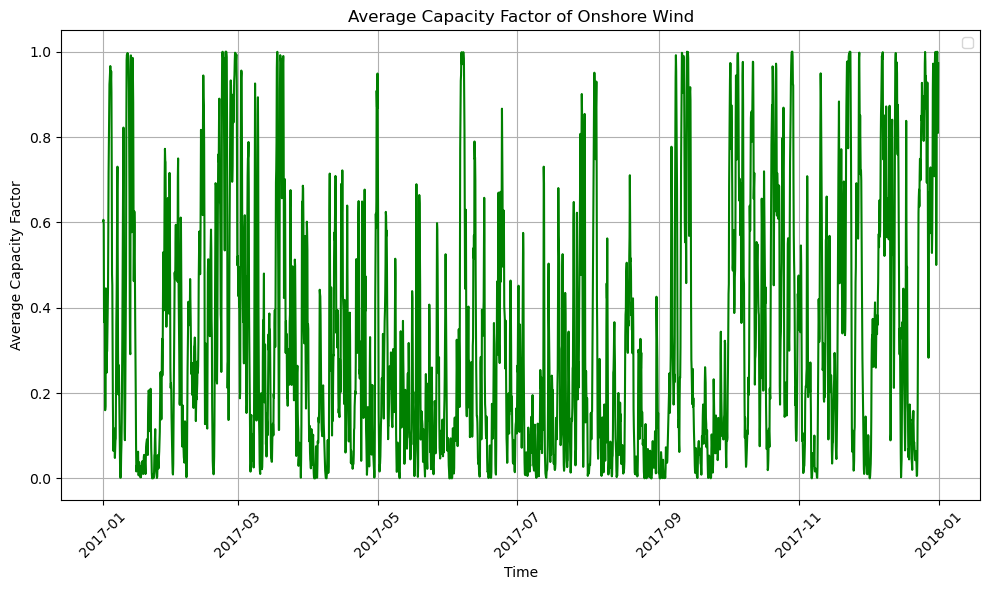

In [58]:
#onshore wind

ts_onwind = onwind
ts_onwind.head()
copy_onwind = ts_onwind.copy()

# Convert the copied data to a DataFrame
copy_onwind['Average Capacity Factor'] = copy_onwind.mean(axis=1)

# Plot the average capacity factor
plt.figure(figsize=(10, 6))
plt.plot(copy_onwind.index, copy_onwind['Average Capacity Factor'], color= "green")
plt.title('Average Capacity Factor of Onshore Wind')
plt.xlabel('Time')
plt.ylabel('Average Capacity Factor')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

print(copy_onwind.mean())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Region
Region 1                   0.130208
Region 2                   0.127631
Region 3                   0.136954
Region 4                   0.130872
Average Capacity Factor    0.131416
dtype: float64


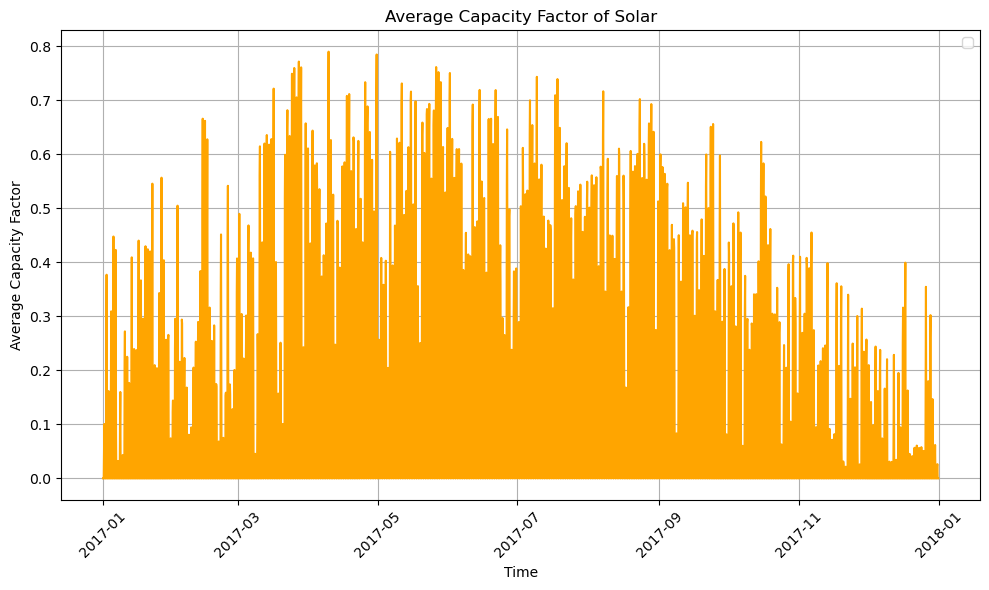

In [59]:
#solar pv

ts_pv = pv
ts_pv.head()
copy_pv = ts_pv.copy()

# Convert the copied data to a DataFrame
copy_pv['Average Capacity Factor'] = copy_pv.mean(axis=1)

# Plot the average capacity factor
plt.figure(figsize=(10, 6))
plt.plot(copy_pv.index, copy_pv['Average Capacity Factor'], color ="orange")
plt.title('Average Capacity Factor of Solar')
plt.xlabel('Time')
plt.ylabel('Average Capacity Factor')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

print(copy_pv.mean())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


dim_0
cf    0.551368
dtype: float64


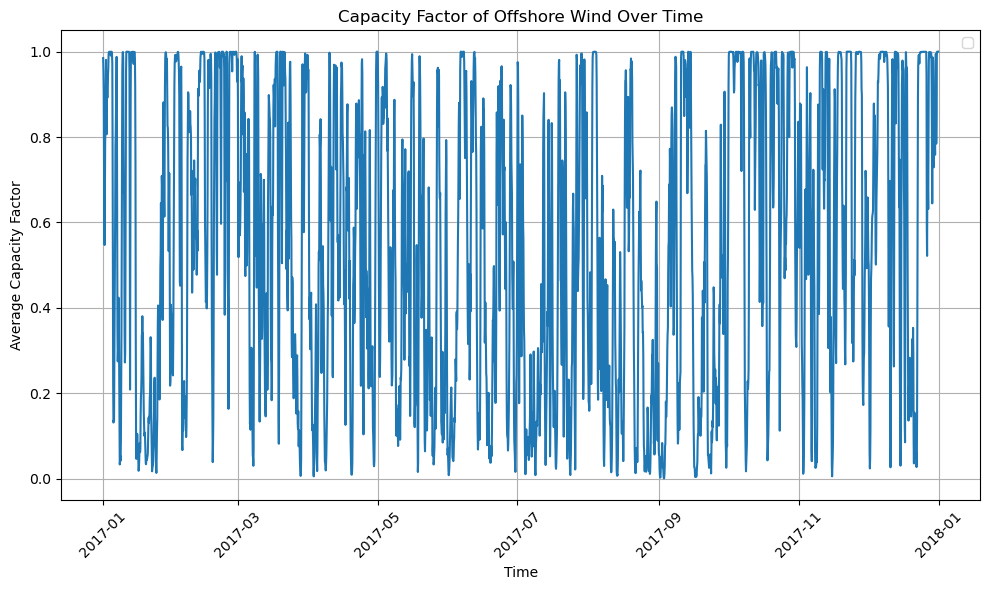

In [60]:
# offshore  wind

ts_offwind = offwind
ts_offwind.head()
plt.figure(figsize=(10, 6))
plt.plot(ts_offwind.index, ts_offwind['cf'])
plt.title('Capacity Factor of Offshore Wind Over Time')
plt.xlabel('Time')
plt.ylabel('Average Capacity Factor')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

print(ts_offwind.mean())

In [2]:
!jupyter nbconvert --to html Assignment4_GroupM.ipynb

[NbConvertApp] Converting notebook Assignment4_GroupM.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 41 image(s).
[NbConvertApp] Writing 9051652 bytes to Assignment4_GroupM.html
